In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from librosa.feature import chroma_stft
from librosa import load
import numpy as np
import os
import matplotlib.pyplot as plt

In [26]:
data_dim = 12
timesteps = 20
num_classes = 24

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(64, return_sequences=True,
               input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.2))
model.add(LSTM(32))  # return a single vector of dimension 32
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_7 (LSTM)                    (None, 20, 64)        19712       lstm_input_3[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 20, 64)        0           lstm_7[0][0]                     
____________________________________________________________________________________________________
lstm_8 (LSTM)                    (None, 20, 64)        33024       dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 20, 64)        0           lstm_8[0][0]                     
___________________________________________________________________________________________

In [27]:
key = ['A', 'B-', 'B', 'C', 'D-', 'D', 'E-', 'E', 'F', 'G-', 'G', 'A-']
tmp = [k.lower() for k in key]
key += tmp
inv_key_map = dict(zip(key, range(24)))

key2 = ['A', 'A+', 'B', 'C', 'C+', 'D', 'D+', 'E', 'F', 'F+', 'G', 'G+']
tmp = [k.lower() for k in key2]
key2 += tmp
for k, i in zip(key2, range(24)):
    if k not in inv_key_map:
        inv_key_map[k] = i
        
def mirex_evaluate(y, t):
    y_is_minor = y // 12
    t_is_minor = t // 12
    if y == t:
        return 1
    elif t_is_minor == y_is_minor and (t + 7) % 12 == y % 12:  # perfect fifth
        return 0.5
    elif y_is_minor > t_is_minor and (y + 3) % 12 == t % 12:  # relative minor
        return 0.3
    elif y_is_minor < t_is_minor and (t + 3) % 12 == y % 12:  # relative major
        return 0.3
    elif t_is_minor != y_is_minor and t % 12 == y % 12:  # parallel
        return 0.2
    else:
        # print("Wrong: ", key_map[t], "is not", key_map[y])
        return 0

sym2num = np.vectorize(inv_key_map.get)
evaluate_vec = np.vectorize(mirex_evaluate, otypes=[float])

train_set = [1, 3, 5, 11, 16, 19, 20, 22, 25, 26, 32]
val_set = [6, 13, 14, 21, 23, 31]
test_set = [8, 12, 18, 24, 27, 28]

data_dir = '/media/ycy/86A4D88BA4D87F5D/DataSet/BPS_piano'
ref_prefix = 'REF_key_'

In [28]:
train_data_list = []
train_target_list = []
val_data_list = []
val_target_list = []
test_data_list = []
test_target_list = []

file_names = [".".join(f.split(".")[:-1]) for f in os.listdir(data_dir) if f[-4:] == '.wav']

for f in file_names:
    label = np.loadtxt(os.path.join(data_dir, ref_prefix + f + '.txt'), dtype='str')
    t = sym2num(label[:, 1])
    t2 = np.zeros((len(t), num_classes))
    t2[(np.arange(len(t)), t)] = 1

    data, sr = load(os.path.join(data_dir, f + '.wav'), sr=None)
    hop_size = int(sr / timesteps)
    window_size = hop_size * 2

    chroma_a = chroma_stft(y=data, sr=sr, hop_length=hop_size, n_fft=window_size, base_c=False)
    if chroma_a.shape[1] > len(t) * timesteps:
        chroma_a = chroma_a[:, :len(t) * timesteps]
    elif chroma_a.shape[1] < len(t) * timesteps:
        chroma_a = np.column_stack((chroma_a, np.zeros((data_dim, len(t) * timesteps - chroma_a.shape[1]))))
    chroma_a = chroma_a.T.reshape(-1, timesteps, data_dim)
    
    if int(f) in train_set:
        train_data_list.append(chroma_a)
        train_target_list.append(t2)
    elif int(f) in val_set:
        val_data_list.append(chroma_a)
        val_target_list.append(t2)
    else:
        test_data_list.append(chroma_a)
        test_target_list.append(t2)
    
    print(f, chroma_a.shape, t2.shape)

print(len(train_data_list), len(val_data_list), len(test_data_list))

32 (836, 20, 12) (836, 24)


1 (800, 20, 12) (800, 24)


11 (1068, 20, 12) (1068, 24)


12 (365, 20, 12) (365, 24)


13 (390, 20, 12) (390, 24)


14 (276, 20, 12) (276, 24)


16 (872, 20, 12) (872, 24)


18 (1024, 20, 12) (1024, 24)


19 (290, 20, 12) (290, 24)


20 (996, 20, 12) (996, 24)


21 (1554, 20, 12) (1554, 24)


22 (555, 20, 12) (555, 24)


23 (1669, 20, 12) (1669, 24)


24 (816, 20, 12) (816, 24)


25 (1116, 20, 12) (1116, 24)


26 (1200, 20, 12) (1200, 24)


27 (735, 20, 12) (735, 24)


28 (306, 20, 12) (306, 24)


3 (1390, 20, 12) (1390, 24)


31 (348, 20, 12) (348, 24)


5 (1438, 20, 12) (1438, 24)


6 (808, 20, 12) (808, 24)


8 (1728, 20, 12) (1728, 24)
11 6 6


In [29]:
train_data = np.concatenate(train_data_list)
train_target = np.concatenate(train_target_list)
val_data = np.concatenate(val_data_list)
val_target = np.concatenate(val_target_list)
test_data = np.concatenate(test_data_list)
test_target = np.concatenate(test_target_list)

In [30]:
history = model.fit(train_data, train_target, batch_size=64, nb_epoch=20, validation_data=(val_data, val_target))

Train on 10561 samples, validate on 5045 samples
Epoch 1/20


   64/10561 [..............................] - ETA: 279s - loss: 3.1910 - acc: 0.0312

  128/10561 [..............................] - ETA: 143s - loss: 3.1394 - acc: 0.0781

  192/10561 [..............................] - ETA: 97s - loss: 3.0999 - acc: 0.0833 

  256/10561 [..............................] - ETA: 75s - loss: 3.0862 - acc: 0.0938

  320/10561 [..............................] - ETA: 61s - loss: 3.0474 - acc: 0.1031

  384/10561 [>.............................] - ETA: 52s - loss: 3.0279 - acc: 0.1146

  448/10561 [>.............................] - ETA: 45s - loss: 3.0012 - acc: 0.1116

  512/10561 [>.............................] - ETA: 40s - loss: 2.9917 - acc: 0.1074

  576/10561 [>.............................] - ETA: 37s - loss: 2.9641 - acc: 0.1076

  640/10561 [>.............................] - ETA: 33s - loss: 2.9380 - acc: 0.1187

  704/10561 [>.............................] - ETA: 31s - loss: 2.9213 - acc: 0.1222

  768/10561 [=>............................] - ETA: 29s - loss: 2.9178 - acc: 0.1211

  832/10561 [=>............................] - ETA: 27s - loss: 2.9104 - acc: 0.1214

  896/10561 [=>............................] - ETA: 26s - loss: 2.8983 - acc: 0.1205

  960/10561 [=>............................] - ETA: 24s - loss: 2.8833 - acc: 0.1250

 1024/10561 [=>............................] - ETA: 23s - loss: 2.8621 - acc: 0.1318

 1152/10561 [==>...........................] - ETA: 21s - loss: 2.8418 - acc: 0.1363

 1216/10561 [==>...........................] - ETA: 20s - loss: 2.8334 - acc: 0.1406

 1280/10561 [==>...........................] - ETA: 19s - loss: 2.8361 - acc: 0.1383

 1344/10561 [==>...........................] - ETA: 19s - loss: 2.8248 - acc: 0.1406

 1408/10561 [==>...........................] - ETA: 18s - loss: 2.8222 - acc: 0.1428

 1472/10561 [===>..........................] - ETA: 17s - loss: 2.8154 - acc: 0.1413

 1536/10561 [===>..........................] - ETA: 17s - loss: 2.8113 - acc: 0.1419

 1600/10561 [===>..........................] - ETA: 16s - loss: 2.8102 - acc: 0.1425

 1664/10561 [===>..........................] - ETA: 16s - loss: 2.8052 - acc: 0.1418

 1728/10561 [===>..........................] - ETA: 15s - loss: 2.7990 - acc: 0.1435

 1792/10561 [====>.........................] - ETA: 15s - loss: 2.7947 - acc: 0.1445

 1856/10561 [====>.........................] - ETA: 15s - loss: 2.7908 - acc: 0.1466

 1920/10561 [====>.........................] - ETA: 14s - loss: 2.7879 - acc: 0.1464

 1984/10561 [====>.........................] - ETA: 14s - loss: 2.7779 - acc: 0.1502

 2048/10561 [====>.........................] - ETA: 14s - loss: 2.7710 - acc: 0.1514

 2112/10561 [====>.........................] - ETA: 13s - loss: 2.7646 - acc: 0.1529

 2240/10561 [=====>........................] - ETA: 13s - loss: 2.7502 - acc: 0.1554

 2304/10561 [=====>........................] - ETA: 12s - loss: 2.7450 - acc: 0.1558

 2368/10561 [=====>........................] - ETA: 12s - loss: 2.7376 - acc: 0.1567

 2432/10561 [=====>........................] - ETA: 12s - loss: 2.7322 - acc: 0.1571

 2496/10561 [======>.......................] - ETA: 12s - loss: 2.7323 - acc: 0.1587

 2560/10561 [======>.......................] - ETA: 11s - loss: 2.7316 - acc: 0.1594

 2624/10561 [======>.......................] - ETA: 11s - loss: 2.7258 - acc: 0.1608

 2688/10561 [======>.......................] - ETA: 11s - loss: 2.7222 - acc: 0.1615

 2752/10561 [======>.......................] - ETA: 11s - loss: 2.7222 - acc: 0.1613

 2816/10561 [======>.......................] - ETA: 11s - loss: 2.7184 - acc: 0.1634

 2880/10561 [=======>......................] - ETA: 10s - loss: 2.7118 - acc: 0.1639

 2944/10561 [=======>......................] - ETA: 10s - loss: 2.7072 - acc: 0.1658

 3008/10561 [=======>......................] - ETA: 10s - loss: 2.7029 - acc: 0.1669

 3072/10561 [=======>......................] - ETA: 10s - loss: 2.6987 - acc: 0.1683

 3200/10561 [========>.....................] - ETA: 10s - loss: 2.6865 - acc: 0.1700

 3264/10561 [========>.....................] - ETA: 9s - loss: 2.6827 - acc: 0.1713 

 3328/10561 [========>.....................] - ETA: 9s - loss: 2.6801 - acc: 0.1719

 3392/10561 [========>.....................] - ETA: 9s - loss: 2.6759 - acc: 0.1739

 3456/10561 [========>.....................] - ETA: 9s - loss: 2.6678 - acc: 0.1771

 3520/10561 [========>.....................] - ETA: 9s - loss: 2.6643 - acc: 0.1778

 3584/10561 [=========>....................] - ETA: 9s - loss: 2.6600 - acc: 0.1794

 3648/10561 [=========>....................] - ETA: 9s - loss: 2.6582 - acc: 0.1809

 3712/10561 [=========>....................] - ETA: 8s - loss: 2.6532 - acc: 0.1808

 3776/10561 [=========>....................] - ETA: 8s - loss: 2.6481 - acc: 0.1825

 3840/10561 [=========>....................] - ETA: 8s - loss: 2.6470 - acc: 0.1836

 3904/10561 [==========>...................] - ETA: 8s - loss: 2.6428 - acc: 0.1852

 3968/10561 [==========>...................] - ETA: 8s - loss: 2.6382 - acc: 0.1880

 4032/10561 [==========>...................] - ETA: 8s - loss: 2.6345 - acc: 0.1895

 4096/10561 [==========>...................] - ETA: 8s - loss: 2.6279 - acc: 0.1907

 4160/10561 [==========>...................] - ETA: 8s - loss: 2.6239 - acc: 0.1928

 4224/10561 [==========>...................] - ETA: 7s - loss: 2.6216 - acc: 0.1934

 4288/10561 [===========>..................] - ETA: 7s - loss: 2.6211 - acc: 0.1929

 4352/10561 [===========>..................] - ETA: 7s - loss: 2.6160 - acc: 0.1946

 4416/10561 [===========>..................] - ETA: 7s - loss: 2.6130 - acc: 0.1947

 4480/10561 [===========>..................] - ETA: 7s - loss: 2.6101 - acc: 0.1969

 4544/10561 [===========>..................] - ETA: 7s - loss: 2.6059 - acc: 0.1978

 4608/10561 [============>.................] - ETA: 7s - loss: 2.6019 - acc: 0.1990

 4672/10561 [============>.................] - ETA: 7s - loss: 2.6008 - acc: 0.1997

 4736/10561 [============>.................] - ETA: 7s - loss: 2.5995 - acc: 0.2000

 4800/10561 [============>.................] - ETA: 6s - loss: 2.5962 - acc: 0.2000

 4864/10561 [============>.................] - ETA: 6s - loss: 2.5949 - acc: 0.1988

 4928/10561 [============>.................] - ETA: 6s - loss: 2.5925 - acc: 0.1997

 4992/10561 [=============>................] - ETA: 6s - loss: 2.5920 - acc: 0.2001

 5056/10561 [=============>................] - ETA: 6s - loss: 2.5925 - acc: 0.2011

 5120/10561 [=============>................] - ETA: 6s - loss: 2.5873 - acc: 0.2025

 5184/10561 [=============>................] - ETA: 6s - loss: 2.5839 - acc: 0.2029

 5248/10561 [=============>................] - ETA: 6s - loss: 2.5813 - acc: 0.2029

 5312/10561 [==============>...............] - ETA: 6s - loss: 2.5790 - acc: 0.2033

 5376/10561 [==============>...............] - ETA: 6s - loss: 2.5758 - acc: 0.2042

 5440/10561 [==============>...............] - ETA: 5s - loss: 2.5729 - acc: 0.2046

 5504/10561 [==============>...............] - ETA: 5s - loss: 2.5736 - acc: 0.2042

 5568/10561 [==============>...............] - ETA: 5s - loss: 2.5701 - acc: 0.2051

 5632/10561 [==============>...............] - ETA: 5s - loss: 2.5675 - acc: 0.2053

 5696/10561 [===============>..............] - ETA: 5s - loss: 2.5660 - acc: 0.2059

 5760/10561 [===============>..............] - ETA: 5s - loss: 2.5655 - acc: 0.2068

 5824/10561 [===============>..............] - ETA: 5s - loss: 2.5626 - acc: 0.2071

 5888/10561 [===============>..............] - ETA: 5s - loss: 2.5609 - acc: 0.2072

 5952/10561 [===============>..............] - ETA: 5s - loss: 2.5603 - acc: 0.2088

 6016/10561 [================>.............] - ETA: 5s - loss: 2.5573 - acc: 0.2101

 6080/10561 [================>.............] - ETA: 5s - loss: 2.5541 - acc: 0.2117

 6144/10561 [================>.............] - ETA: 4s - loss: 2.5532 - acc: 0.2121

 6208/10561 [================>.............] - ETA: 4s - loss: 2.5523 - acc: 0.2130

 6272/10561 [================>.............] - ETA: 4s - loss: 2.5491 - acc: 0.2141

 6336/10561 [================>.............] - ETA: 4s - loss: 2.5478 - acc: 0.2139

 6400/10561 [=================>............] - ETA: 4s - loss: 2.5463 - acc: 0.2145

 6464/10561 [=================>............] - ETA: 4s - loss: 2.5431 - acc: 0.2153

 6528/10561 [=================>............] - ETA: 4s - loss: 2.5415 - acc: 0.2158

 6592/10561 [=================>............] - ETA: 4s - loss: 2.5406 - acc: 0.2156

 6656/10561 [=================>............] - ETA: 4s - loss: 2.5384 - acc: 0.2156

 6720/10561 [==================>...........] - ETA: 4s - loss: 2.5361 - acc: 0.2164

 6784/10561 [==================>...........] - ETA: 4s - loss: 2.5342 - acc: 0.2173

 6848/10561 [==================>...........] - ETA: 4s - loss: 2.5341 - acc: 0.2169

 6912/10561 [==================>...........] - ETA: 4s - loss: 2.5319 - acc: 0.2182

 6976/10561 [==================>...........] - ETA: 3s - loss: 2.5306 - acc: 0.2189

 7040/10561 [==================>...........] - ETA: 3s - loss: 2.5293 - acc: 0.2190

 7104/10561 [===================>..........] - ETA: 3s - loss: 2.5268 - acc: 0.2197

 7168/10561 [===================>..........] - ETA: 3s - loss: 2.5253 - acc: 0.2203

 7232/10561 [===================>..........] - ETA: 3s - loss: 2.5259 - acc: 0.2203

 7296/10561 [===================>..........] - ETA: 3s - loss: 2.5235 - acc: 0.2214

 7360/10561 [===================>..........] - ETA: 3s - loss: 2.5203 - acc: 0.2220

 7424/10561 [====================>.........] - ETA: 3s - loss: 2.5195 - acc: 0.2216

 7488/10561 [====================>.........] - ETA: 3s - loss: 2.5166 - acc: 0.2216

 7552/10561 [====================>.........] - ETA: 3s - loss: 2.5151 - acc: 0.2218

 7616/10561 [====================>.........] - ETA: 3s - loss: 2.5130 - acc: 0.2224

 7680/10561 [====================>.........] - ETA: 3s - loss: 2.5113 - acc: 0.2230

 7744/10561 [====================>.........] - ETA: 3s - loss: 2.5095 - acc: 0.2240

 7808/10561 [=====================>........] - ETA: 2s - loss: 2.5075 - acc: 0.2244

 7872/10561 [=====================>........] - ETA: 2s - loss: 2.5069 - acc: 0.2248

 7936/10561 [=====================>........] - ETA: 2s - loss: 2.5068 - acc: 0.2254

 8000/10561 [=====================>........] - ETA: 2s - loss: 2.5031 - acc: 0.2271

 8064/10561 [=====================>........] - ETA: 2s - loss: 2.5030 - acc: 0.2271

 8128/10561 [======================>.......] - ETA: 2s - loss: 2.5015 - acc: 0.2279

 8192/10561 [======================>.......] - ETA: 2s - loss: 2.4989 - acc: 0.2279

 8256/10561 [======================>.......] - ETA: 2s - loss: 2.4966 - acc: 0.2282

 8320/10561 [======================>.......] - ETA: 2s - loss: 2.4941 - acc: 0.2286

 8384/10561 [======================>.......] - ETA: 2s - loss: 2.4938 - acc: 0.2283

 8448/10561 [======================>.......] - ETA: 2s - loss: 2.4924 - acc: 0.2286

 8512/10561 [=======================>......] - ETA: 2s - loss: 2.4922 - acc: 0.2289

 8576/10561 [=======================>......] - ETA: 2s - loss: 2.4917 - acc: 0.2295

 8640/10561 [=======================>......] - ETA: 2s - loss: 2.4904 - acc: 0.2302

 8704/10561 [=======================>......] - ETA: 1s - loss: 2.4885 - acc: 0.2304

 8768/10561 [=======================>......] - ETA: 1s - loss: 2.4876 - acc: 0.2306

 8832/10561 [========================>.....] - ETA: 1s - loss: 2.4849 - acc: 0.2320

 8896/10561 [========================>.....] - ETA: 1s - loss: 2.4854 - acc: 0.2313

 8960/10561 [========================>.....] - ETA: 1s - loss: 2.4845 - acc: 0.2315

 9024/10561 [========================>.....] - ETA: 1s - loss: 2.4828 - acc: 0.2320

 9088/10561 [========================>.....] - ETA: 1s - loss: 2.4803 - acc: 0.2331

 9152/10561 [========================>.....] - ETA: 1s - loss: 2.4783 - acc: 0.2337

 9216/10561 [=========================>....] - ETA: 1s - loss: 2.4754 - acc: 0.2351

 9280/10561 [=========================>....] - ETA: 1s - loss: 2.4729 - acc: 0.2357

 9344/10561 [=========================>....] - ETA: 1s - loss: 2.4709 - acc: 0.2366

 9408/10561 [=========================>....] - ETA: 1s - loss: 2.4700 - acc: 0.2366

 9472/10561 [=========================>....] - ETA: 1s - loss: 2.4695 - acc: 0.2369

 9536/10561 [==========================>...] - ETA: 1s - loss: 2.4688 - acc: 0.2371

 9600/10561 [==========================>...] - ETA: 0s - loss: 2.4673 - acc: 0.2375

 9664/10561 [==========================>...] - ETA: 0s - loss: 2.4662 - acc: 0.2381

 9728/10561 [==========================>...] - ETA: 0s - loss: 2.4639 - acc: 0.2382

 9792/10561 [==========================>...] - ETA: 0s - loss: 2.4620 - acc: 0.2386

 9856/10561 [==========================>...] - ETA: 0s - loss: 2.4620 - acc: 0.2384

 9920/10561 [===========================>..] - ETA: 0s - loss: 2.4602 - acc: 0.2392

 9984/10561 [===========================>..] - ETA: 0s - loss: 2.4584 - acc: 0.2393

10048/10561 [===========================>..] - ETA: 0s - loss: 2.4570 - acc: 0.2397

10112/10561 [===========================>..] - ETA: 0s - loss: 2.4555 - acc: 0.2404

10176/10561 [===========================>..] - ETA: 0s - loss: 2.4537 - acc: 0.2410

10240/10561 [============================>.] - ETA: 0s - loss: 2.4534 - acc: 0.2409

10304/10561 [============================>.] - ETA: 0s - loss: 2.4525 - acc: 0.2410

10368/10561 [============================>.] - ETA: 0s - loss: 2.4518 - acc: 0.2406

10432/10561 [============================>.] - ETA: 0s - loss: 2.4497 - acc: 0.2411

10496/10561 [============================>.] - ETA: 0s - loss: 2.4499 - acc: 0.2411

10560/10561 [============================>.] - ETA: 0s - loss: 2.4477 - acc: 0.2419

10561/10561 [==============================] - 12s - loss: 2.4477 - acc: 0.2418 - val_loss: 3.0967 - val_acc: 0.1273


Epoch 2/20
   64/10561 [..............................] - ETA: 8s - loss: 2.2343 - acc: 0.2812

  128/10561 [..............................] - ETA: 9s - loss: 2.3219 - acc: 0.2188

  192/10561 [..............................] - ETA: 8s - loss: 2.2452 - acc: 0.2448

  256/10561 [..............................] - ETA: 8s - loss: 2.3008 - acc: 0.2383

  320/10561 [..............................] - ETA: 8s - loss: 2.3182 - acc: 0.2375

  384/10561 [>.............................] - ETA: 8s - loss: 2.3310 - acc: 0.2370

  448/10561 [>.............................] - ETA: 9s - loss: 2.3317 - acc: 0.2411

  512/10561 [>.............................] - ETA: 9s - loss: 2.3083 - acc: 0.2480

  576/10561 [>.............................] - ETA: 9s - loss: 2.2812 - acc: 0.2587

  640/10561 [>.............................] - ETA: 8s - loss: 2.2879 - acc: 0.2578

  704/10561 [>.............................] - ETA: 8s - loss: 2.2646 - acc: 0.2699

  768/10561 [=>............................] - ETA: 8s - loss: 2.2440 - acc: 0.2812

  832/10561 [=>............................] - ETA: 8s - loss: 2.2418 - acc: 0.2849

  896/10561 [=>............................] - ETA: 8s - loss: 2.2403 - acc: 0.2846

  960/10561 [=>............................] - ETA: 8s - loss: 2.2311 - acc: 0.2833

 1024/10561 [=>............................] - ETA: 8s - loss: 2.2361 - acc: 0.2852

 1088/10561 [==>...........................] - ETA: 8s - loss: 2.2315 - acc: 0.2895

 1152/10561 [==>...........................] - ETA: 8s - loss: 2.2258 - acc: 0.2899

 1216/10561 [==>...........................] - ETA: 8s - loss: 2.2257 - acc: 0.2887

 1280/10561 [==>...........................] - ETA: 8s - loss: 2.2327 - acc: 0.2852

 1344/10561 [==>...........................] - ETA: 8s - loss: 2.2330 - acc: 0.2872

 1408/10561 [==>...........................] - ETA: 8s - loss: 2.2273 - acc: 0.2919

 1472/10561 [===>..........................] - ETA: 7s - loss: 2.2252 - acc: 0.2928

 1536/10561 [===>..........................] - ETA: 7s - loss: 2.2229 - acc: 0.2962

 1600/10561 [===>..........................] - ETA: 7s - loss: 2.2234 - acc: 0.2963

 1664/10561 [===>..........................] - ETA: 7s - loss: 2.2150 - acc: 0.3011

 1728/10561 [===>..........................] - ETA: 7s - loss: 2.2181 - acc: 0.3003

 1792/10561 [====>.........................] - ETA: 7s - loss: 2.2204 - acc: 0.2974

 1856/10561 [====>.........................] - ETA: 7s - loss: 2.2184 - acc: 0.2996

 1920/10561 [====>.........................] - ETA: 7s - loss: 2.2135 - acc: 0.3026

 1984/10561 [====>.........................] - ETA: 7s - loss: 2.2086 - acc: 0.3044

 2048/10561 [====>.........................] - ETA: 7s - loss: 2.2010 - acc: 0.3066

 2112/10561 [====>.........................] - ETA: 7s - loss: 2.2061 - acc: 0.3054

 2176/10561 [=====>........................] - ETA: 7s - loss: 2.2075 - acc: 0.3038

 2240/10561 [=====>........................] - ETA: 7s - loss: 2.2068 - acc: 0.3063

 2304/10561 [=====>........................] - ETA: 7s - loss: 2.2099 - acc: 0.3051

 2368/10561 [=====>........................] - ETA: 7s - loss: 2.2100 - acc: 0.3045

 2432/10561 [=====>........................] - ETA: 7s - loss: 2.2049 - acc: 0.3067

 2496/10561 [======>.......................] - ETA: 7s - loss: 2.2029 - acc: 0.3093

 2560/10561 [======>.......................] - ETA: 7s - loss: 2.2042 - acc: 0.3098

 2624/10561 [======>.......................] - ETA: 6s - loss: 2.2030 - acc: 0.3095

 2688/10561 [======>.......................] - ETA: 6s - loss: 2.1996 - acc: 0.3103

 2752/10561 [======>.......................] - ETA: 6s - loss: 2.1987 - acc: 0.3107

 2816/10561 [======>.......................] - ETA: 6s - loss: 2.1947 - acc: 0.3139

 2880/10561 [=======>......................] - ETA: 6s - loss: 2.1975 - acc: 0.3125

 2944/10561 [=======>......................] - ETA: 6s - loss: 2.1948 - acc: 0.3115

 3008/10561 [=======>......................] - ETA: 6s - loss: 2.1901 - acc: 0.3128

 3072/10561 [=======>......................] - ETA: 6s - loss: 2.1893 - acc: 0.3132

 3136/10561 [=======>......................] - ETA: 6s - loss: 2.1891 - acc: 0.3119

 3200/10561 [========>.....................] - ETA: 6s - loss: 2.1907 - acc: 0.3119

 3264/10561 [========>.....................] - ETA: 6s - loss: 2.1907 - acc: 0.3134

 3328/10561 [========>.....................] - ETA: 6s - loss: 2.1915 - acc: 0.3122

 3392/10561 [========>.....................] - ETA: 6s - loss: 2.1946 - acc: 0.3093

 3456/10561 [========>.....................] - ETA: 6s - loss: 2.1920 - acc: 0.3096

 3520/10561 [========>.....................] - ETA: 6s - loss: 2.1954 - acc: 0.3097

 3584/10561 [=========>....................] - ETA: 6s - loss: 2.1949 - acc: 0.3103

 3648/10561 [=========>....................] - ETA: 6s - loss: 2.1943 - acc: 0.3114

 3712/10561 [=========>....................] - ETA: 6s - loss: 2.1942 - acc: 0.3112

 3776/10561 [=========>....................] - ETA: 6s - loss: 2.1944 - acc: 0.3112

 3840/10561 [=========>....................] - ETA: 5s - loss: 2.1939 - acc: 0.3117

 3904/10561 [==========>...................] - ETA: 5s - loss: 2.1947 - acc: 0.3107

 3968/10561 [==========>...................] - ETA: 5s - loss: 2.1979 - acc: 0.3092

 4032/10561 [==========>...................] - ETA: 5s - loss: 2.1994 - acc: 0.3085

 4096/10561 [==========>...................] - ETA: 5s - loss: 2.1990 - acc: 0.3091

 4160/10561 [==========>...................] - ETA: 5s - loss: 2.1956 - acc: 0.3096

 4224/10561 [==========>...................] - ETA: 5s - loss: 2.1915 - acc: 0.3099

 4288/10561 [===========>..................] - ETA: 5s - loss: 2.1909 - acc: 0.3095

 4352/10561 [===========>..................] - ETA: 5s - loss: 2.1893 - acc: 0.3104

 4416/10561 [===========>..................] - ETA: 5s - loss: 2.1898 - acc: 0.3105

 4480/10561 [===========>..................] - ETA: 5s - loss: 2.1890 - acc: 0.3109

 4544/10561 [===========>..................] - ETA: 5s - loss: 2.1879 - acc: 0.3110

 4608/10561 [============>.................] - ETA: 5s - loss: 2.1856 - acc: 0.3116

 4672/10561 [============>.................] - ETA: 5s - loss: 2.1858 - acc: 0.3116

 4736/10561 [============>.................] - ETA: 5s - loss: 2.1865 - acc: 0.3108

 4800/10561 [============>.................] - ETA: 5s - loss: 2.1854 - acc: 0.3106

 4864/10561 [============>.................] - ETA: 5s - loss: 2.1881 - acc: 0.3100

 4928/10561 [============>.................] - ETA: 5s - loss: 2.1828 - acc: 0.3115

 4992/10561 [=============>................] - ETA: 4s - loss: 2.1824 - acc: 0.3115

 5056/10561 [=============>................] - ETA: 4s - loss: 2.1819 - acc: 0.3111

 5120/10561 [=============>................] - ETA: 4s - loss: 2.1818 - acc: 0.3111

 5184/10561 [=============>................] - ETA: 4s - loss: 2.1826 - acc: 0.3110

 5248/10561 [=============>................] - ETA: 4s - loss: 2.1812 - acc: 0.3110

 5312/10561 [==============>...............] - ETA: 4s - loss: 2.1797 - acc: 0.3116

 5376/10561 [==============>...............] - ETA: 4s - loss: 2.1796 - acc: 0.3121

 5440/10561 [==============>...............] - ETA: 4s - loss: 2.1808 - acc: 0.3108

 5504/10561 [==============>...............] - ETA: 4s - loss: 2.1799 - acc: 0.3110

 5568/10561 [==============>...............] - ETA: 4s - loss: 2.1805 - acc: 0.3102

 5632/10561 [==============>...............] - ETA: 4s - loss: 2.1813 - acc: 0.3104

 5696/10561 [===============>..............] - ETA: 4s - loss: 2.1805 - acc: 0.3095

 5760/10561 [===============>..............] - ETA: 4s - loss: 2.1804 - acc: 0.3099

 5824/10561 [===============>..............] - ETA: 4s - loss: 2.1783 - acc: 0.3108

 5888/10561 [===============>..............] - ETA: 4s - loss: 2.1773 - acc: 0.3111

 5952/10561 [===============>..............] - ETA: 4s - loss: 2.1783 - acc: 0.3105

 6016/10561 [================>.............] - ETA: 4s - loss: 2.1778 - acc: 0.3107

 6080/10561 [================>.............] - ETA: 4s - loss: 2.1793 - acc: 0.3105

 6144/10561 [================>.............] - ETA: 3s - loss: 2.1787 - acc: 0.3110

 6208/10561 [================>.............] - ETA: 3s - loss: 2.1766 - acc: 0.3122

 6272/10561 [================>.............] - ETA: 3s - loss: 2.1747 - acc: 0.3120

 6336/10561 [================>.............] - ETA: 3s - loss: 2.1771 - acc: 0.3120

 6400/10561 [=================>............] - ETA: 3s - loss: 2.1779 - acc: 0.3123

 6464/10561 [=================>............] - ETA: 3s - loss: 2.1786 - acc: 0.3117

 6528/10561 [=================>............] - ETA: 3s - loss: 2.1797 - acc: 0.3119

 6592/10561 [=================>............] - ETA: 3s - loss: 2.1776 - acc: 0.3128

 6656/10561 [=================>............] - ETA: 3s - loss: 2.1763 - acc: 0.3128

 6720/10561 [==================>...........] - ETA: 3s - loss: 2.1751 - acc: 0.3137

 6784/10561 [==================>...........] - ETA: 3s - loss: 2.1759 - acc: 0.3132

 6848/10561 [==================>...........] - ETA: 3s - loss: 2.1761 - acc: 0.3132

 6912/10561 [==================>...........] - ETA: 3s - loss: 2.1733 - acc: 0.3142

 6976/10561 [==================>...........] - ETA: 3s - loss: 2.1710 - acc: 0.3154

 7040/10561 [==================>...........] - ETA: 3s - loss: 2.1700 - acc: 0.3162

 7104/10561 [===================>..........] - ETA: 3s - loss: 2.1694 - acc: 0.3162

 7168/10561 [===================>..........] - ETA: 3s - loss: 2.1695 - acc: 0.3160

 7232/10561 [===================>..........] - ETA: 2s - loss: 2.1701 - acc: 0.3153

 7296/10561 [===================>..........] - ETA: 2s - loss: 2.1688 - acc: 0.3155

 7360/10561 [===================>..........] - ETA: 2s - loss: 2.1671 - acc: 0.3162

 7424/10561 [====================>.........] - ETA: 2s - loss: 2.1673 - acc: 0.3163

 7488/10561 [====================>.........] - ETA: 2s - loss: 2.1667 - acc: 0.3157

 7552/10561 [====================>.........] - ETA: 2s - loss: 2.1658 - acc: 0.3163

 7616/10561 [====================>.........] - ETA: 2s - loss: 2.1675 - acc: 0.3158

 7680/10561 [====================>.........] - ETA: 2s - loss: 2.1666 - acc: 0.3163

 7744/10561 [====================>.........] - ETA: 2s - loss: 2.1651 - acc: 0.3165

 7808/10561 [=====================>........] - ETA: 2s - loss: 2.1634 - acc: 0.3169

 7872/10561 [=====================>........] - ETA: 2s - loss: 2.1636 - acc: 0.3167

 7936/10561 [=====================>........] - ETA: 2s - loss: 2.1642 - acc: 0.3158

 8000/10561 [=====================>........] - ETA: 2s - loss: 2.1634 - acc: 0.3162

 8064/10561 [=====================>........] - ETA: 2s - loss: 2.1647 - acc: 0.3161

 8128/10561 [======================>.......] - ETA: 2s - loss: 2.1636 - acc: 0.3161

 8192/10561 [======================>.......] - ETA: 2s - loss: 2.1627 - acc: 0.3164

 8256/10561 [======================>.......] - ETA: 2s - loss: 2.1610 - acc: 0.3169

 8320/10561 [======================>.......] - ETA: 1s - loss: 2.1615 - acc: 0.3173

 8384/10561 [======================>.......] - ETA: 1s - loss: 2.1627 - acc: 0.3169

 8448/10561 [======================>.......] - ETA: 1s - loss: 2.1617 - acc: 0.3171

 8512/10561 [=======================>......] - ETA: 1s - loss: 2.1597 - acc: 0.3180

 8576/10561 [=======================>......] - ETA: 1s - loss: 2.1616 - acc: 0.3177

 8640/10561 [=======================>......] - ETA: 1s - loss: 2.1613 - acc: 0.3176

 8704/10561 [=======================>......] - ETA: 1s - loss: 2.1610 - acc: 0.3178

 8768/10561 [=======================>......] - ETA: 1s - loss: 2.1611 - acc: 0.3173

 8832/10561 [========================>.....] - ETA: 1s - loss: 2.1605 - acc: 0.3177

 8896/10561 [========================>.....] - ETA: 1s - loss: 2.1614 - acc: 0.3172

 8960/10561 [========================>.....] - ETA: 1s - loss: 2.1611 - acc: 0.3177

 9024/10561 [========================>.....] - ETA: 1s - loss: 2.1597 - acc: 0.3177

 9088/10561 [========================>.....] - ETA: 1s - loss: 2.1609 - acc: 0.3177

 9152/10561 [========================>.....] - ETA: 1s - loss: 2.1598 - acc: 0.3179

 9216/10561 [=========================>....] - ETA: 1s - loss: 2.1575 - acc: 0.3188

 9280/10561 [=========================>....] - ETA: 1s - loss: 2.1568 - acc: 0.3189

 9344/10561 [=========================>....] - ETA: 1s - loss: 2.1558 - acc: 0.3189

 9408/10561 [=========================>....] - ETA: 1s - loss: 2.1552 - acc: 0.3190

 9472/10561 [=========================>....] - ETA: 0s - loss: 2.1524 - acc: 0.3195

 9536/10561 [==========================>...] - ETA: 0s - loss: 2.1516 - acc: 0.3194

 9600/10561 [==========================>...] - ETA: 0s - loss: 2.1502 - acc: 0.3202

 9664/10561 [==========================>...] - ETA: 0s - loss: 2.1491 - acc: 0.3203

 9728/10561 [==========================>...] - ETA: 0s - loss: 2.1482 - acc: 0.3207

 9792/10561 [==========================>...] - ETA: 0s - loss: 2.1468 - acc: 0.3211

 9856/10561 [==========================>...] - ETA: 0s - loss: 2.1489 - acc: 0.3210

 9984/10561 [===========================>..] - ETA: 0s - loss: 2.1479 - acc: 0.3210

10048/10561 [===========================>..] - ETA: 0s - loss: 2.1469 - acc: 0.3219

10112/10561 [===========================>..] - ETA: 0s - loss: 2.1473 - acc: 0.3219

10176/10561 [===========================>..] - ETA: 0s - loss: 2.1463 - acc: 0.3221

10240/10561 [============================>.] - ETA: 0s - loss: 2.1462 - acc: 0.3222

10304/10561 [============================>.] - ETA: 0s - loss: 2.1468 - acc: 0.3225

10368/10561 [============================>.] - ETA: 0s - loss: 2.1466 - acc: 0.3222

10432/10561 [============================>.] - ETA: 0s - loss: 2.1455 - acc: 0.3226

10496/10561 [============================>.] - ETA: 0s - loss: 2.1465 - acc: 0.3227

10560/10561 [============================>.] - ETA: 0s - loss: 2.1452 - acc: 0.3230

10561/10561 [==============================] - 10s - loss: 2.1451 - acc: 0.3231 - val_loss: 3.0992 - val_acc: 0.1958


Epoch 3/20
   64/10561 [..............................] - ETA: 8s - loss: 1.9598 - acc: 0.4062

  128/10561 [..............................] - ETA: 9s - loss: 2.0945 - acc: 0.3281

  192/10561 [..............................] - ETA: 8s - loss: 1.9457 - acc: 0.3698

  256/10561 [..............................] - ETA: 8s - loss: 1.9625 - acc: 0.3477

  320/10561 [..............................] - ETA: 8s - loss: 1.9919 - acc: 0.3281

  384/10561 [>.............................] - ETA: 8s - loss: 2.0032 - acc: 0.3307

  448/10561 [>.............................] - ETA: 8s - loss: 2.0134 - acc: 0.3326

  512/10561 [>.............................] - ETA: 8s - loss: 2.0114 - acc: 0.3379

  576/10561 [>.............................] - ETA: 8s - loss: 2.0075 - acc: 0.3420

  640/10561 [>.............................] - ETA: 8s - loss: 2.0065 - acc: 0.3328

  704/10561 [>.............................] - ETA: 8s - loss: 1.9943 - acc: 0.3395

  768/10561 [=>............................] - ETA: 8s - loss: 1.9956 - acc: 0.3424

  832/10561 [=>............................] - ETA: 8s - loss: 1.9973 - acc: 0.3413

  896/10561 [=>............................] - ETA: 8s - loss: 2.0101 - acc: 0.3382

  960/10561 [=>............................] - ETA: 8s - loss: 2.0067 - acc: 0.3385

 1024/10561 [=>............................] - ETA: 8s - loss: 2.0125 - acc: 0.3389

 1088/10561 [==>...........................] - ETA: 8s - loss: 1.9979 - acc: 0.3456

 1152/10561 [==>...........................] - ETA: 8s - loss: 1.9954 - acc: 0.3472

 1216/10561 [==>...........................] - ETA: 8s - loss: 1.9870 - acc: 0.3536

 1280/10561 [==>...........................] - ETA: 8s - loss: 1.9913 - acc: 0.3523

 1344/10561 [==>...........................] - ETA: 7s - loss: 1.9975 - acc: 0.3497

 1408/10561 [==>...........................] - ETA: 7s - loss: 1.9965 - acc: 0.3494

 1472/10561 [===>..........................] - ETA: 7s - loss: 1.9831 - acc: 0.3560

 1536/10561 [===>..........................] - ETA: 7s - loss: 1.9778 - acc: 0.3568

 1600/10561 [===>..........................] - ETA: 7s - loss: 1.9702 - acc: 0.3644

 1664/10561 [===>..........................] - ETA: 7s - loss: 1.9815 - acc: 0.3624

 1728/10561 [===>..........................] - ETA: 7s - loss: 1.9868 - acc: 0.3611

 1792/10561 [====>.........................] - ETA: 7s - loss: 1.9937 - acc: 0.3594

 1856/10561 [====>.........................] - ETA: 7s - loss: 1.9960 - acc: 0.3599

 1920/10561 [====>.........................] - ETA: 7s - loss: 1.9909 - acc: 0.3609

 1984/10561 [====>.........................] - ETA: 7s - loss: 1.9957 - acc: 0.3609

 2048/10561 [====>.........................] - ETA: 7s - loss: 1.9932 - acc: 0.3613

 2112/10561 [====>.........................] - ETA: 7s - loss: 1.9900 - acc: 0.3641

 2176/10561 [=====>........................] - ETA: 7s - loss: 1.9896 - acc: 0.3658

 2240/10561 [=====>........................] - ETA: 7s - loss: 1.9931 - acc: 0.3638

 2304/10561 [=====>........................] - ETA: 7s - loss: 1.9913 - acc: 0.3633

 2368/10561 [=====>........................] - ETA: 7s - loss: 1.9992 - acc: 0.3628

 2432/10561 [=====>........................] - ETA: 7s - loss: 1.9996 - acc: 0.3639

 2496/10561 [======>.......................] - ETA: 7s - loss: 2.0030 - acc: 0.3634

 2560/10561 [======>.......................] - ETA: 7s - loss: 2.0007 - acc: 0.3637

 2624/10561 [======>.......................] - ETA: 7s - loss: 2.0028 - acc: 0.3647

 2688/10561 [======>.......................] - ETA: 6s - loss: 1.9981 - acc: 0.3661

 2752/10561 [======>.......................] - ETA: 6s - loss: 2.0053 - acc: 0.3637

 2816/10561 [======>.......................] - ETA: 6s - loss: 2.0020 - acc: 0.3665

 2880/10561 [=======>......................] - ETA: 6s - loss: 2.0036 - acc: 0.3649

 2944/10561 [=======>......................] - ETA: 6s - loss: 2.0071 - acc: 0.3635

 3008/10561 [=======>......................] - ETA: 6s - loss: 2.0067 - acc: 0.3640

 3072/10561 [=======>......................] - ETA: 6s - loss: 2.0094 - acc: 0.3643

 3136/10561 [=======>......................] - ETA: 6s - loss: 2.0135 - acc: 0.3629

 3200/10561 [========>.....................] - ETA: 6s - loss: 2.0116 - acc: 0.3622

 3264/10561 [========>.....................] - ETA: 6s - loss: 2.0127 - acc: 0.3621

 3328/10561 [========>.....................] - ETA: 6s - loss: 2.0078 - acc: 0.3645

 3392/10561 [========>.....................] - ETA: 6s - loss: 2.0103 - acc: 0.3632

 3456/10561 [========>.....................] - ETA: 6s - loss: 2.0123 - acc: 0.3634

 3520/10561 [========>.....................] - ETA: 6s - loss: 2.0137 - acc: 0.3625

 3584/10561 [=========>....................] - ETA: 6s - loss: 2.0131 - acc: 0.3622

 3648/10561 [=========>....................] - ETA: 6s - loss: 2.0126 - acc: 0.3624

 3712/10561 [=========>....................] - ETA: 6s - loss: 2.0157 - acc: 0.3605

 3776/10561 [=========>....................] - ETA: 5s - loss: 2.0197 - acc: 0.3596

 3840/10561 [=========>....................] - ETA: 5s - loss: 2.0201 - acc: 0.3589

 3904/10561 [==========>...................] - ETA: 5s - loss: 2.0208 - acc: 0.3594

 3968/10561 [==========>...................] - ETA: 5s - loss: 2.0238 - acc: 0.3584

 4032/10561 [==========>...................] - ETA: 5s - loss: 2.0225 - acc: 0.3569

 4096/10561 [==========>...................] - ETA: 5s - loss: 2.0227 - acc: 0.3579

 4160/10561 [==========>...................] - ETA: 5s - loss: 2.0208 - acc: 0.3587

 4224/10561 [==========>...................] - ETA: 5s - loss: 2.0197 - acc: 0.3587

 4288/10561 [===========>..................] - ETA: 5s - loss: 2.0174 - acc: 0.3594

 4352/10561 [===========>..................] - ETA: 5s - loss: 2.0207 - acc: 0.3575

 4416/10561 [===========>..................] - ETA: 5s - loss: 2.0209 - acc: 0.3580

 4480/10561 [===========>..................] - ETA: 5s - loss: 2.0190 - acc: 0.3589

 4544/10561 [===========>..................] - ETA: 5s - loss: 2.0201 - acc: 0.3581

 4608/10561 [============>.................] - ETA: 5s - loss: 2.0198 - acc: 0.3587

 4672/10561 [============>.................] - ETA: 5s - loss: 2.0166 - acc: 0.3604

 4736/10561 [============>.................] - ETA: 5s - loss: 2.0194 - acc: 0.3600

 4800/10561 [============>.................] - ETA: 5s - loss: 2.0207 - acc: 0.3594

 4864/10561 [============>.................] - ETA: 5s - loss: 2.0241 - acc: 0.3588

 4928/10561 [============>.................] - ETA: 4s - loss: 2.0256 - acc: 0.3582

 4992/10561 [=============>................] - ETA: 4s - loss: 2.0265 - acc: 0.3568

 5056/10561 [=============>................] - ETA: 4s - loss: 2.0256 - acc: 0.3568

 5120/10561 [=============>................] - ETA: 4s - loss: 2.0267 - acc: 0.3563

 5184/10561 [=============>................] - ETA: 4s - loss: 2.0261 - acc: 0.3563

 5248/10561 [=============>................] - ETA: 4s - loss: 2.0256 - acc: 0.3558

 5312/10561 [==============>...............] - ETA: 4s - loss: 2.0257 - acc: 0.3558

 5376/10561 [==============>...............] - ETA: 4s - loss: 2.0260 - acc: 0.3557

 5440/10561 [==============>...............] - ETA: 4s - loss: 2.0270 - acc: 0.3559

 5504/10561 [==============>...............] - ETA: 4s - loss: 2.0260 - acc: 0.3566

 5568/10561 [==============>...............] - ETA: 4s - loss: 2.0243 - acc: 0.3569

 5632/10561 [==============>...............] - ETA: 4s - loss: 2.0237 - acc: 0.3565

 5696/10561 [===============>..............] - ETA: 4s - loss: 2.0258 - acc: 0.3557

 5760/10561 [===============>..............] - ETA: 4s - loss: 2.0232 - acc: 0.3573

 5824/10561 [===============>..............] - ETA: 4s - loss: 2.0232 - acc: 0.3578

 5888/10561 [===============>..............] - ETA: 4s - loss: 2.0214 - acc: 0.3589

 5952/10561 [===============>..............] - ETA: 4s - loss: 2.0191 - acc: 0.3599

 6016/10561 [================>.............] - ETA: 3s - loss: 2.0156 - acc: 0.3600

 6080/10561 [================>.............] - ETA: 3s - loss: 2.0156 - acc: 0.3599

 6144/10561 [================>.............] - ETA: 3s - loss: 2.0136 - acc: 0.3605

 6208/10561 [================>.............] - ETA: 3s - loss: 2.0108 - acc: 0.3611

 6272/10561 [================>.............] - ETA: 3s - loss: 2.0100 - acc: 0.3611

 6400/10561 [=================>............] - ETA: 3s - loss: 2.0133 - acc: 0.3595

 6464/10561 [=================>............] - ETA: 3s - loss: 2.0129 - acc: 0.3600

 6528/10561 [=================>............] - ETA: 3s - loss: 2.0127 - acc: 0.3597

 6656/10561 [=================>............] - ETA: 3s - loss: 2.0121 - acc: 0.3594

 6720/10561 [==================>...........] - ETA: 3s - loss: 2.0125 - acc: 0.3589

 6784/10561 [==================>...........] - ETA: 3s - loss: 2.0132 - acc: 0.3585

 6848/10561 [==================>...........] - ETA: 3s - loss: 2.0131 - acc: 0.3586

 6912/10561 [==================>...........] - ETA: 3s - loss: 2.0143 - acc: 0.3587

 6976/10561 [==================>...........] - ETA: 3s - loss: 2.0137 - acc: 0.3582

 7040/10561 [==================>...........] - ETA: 3s - loss: 2.0148 - acc: 0.3582

 7104/10561 [===================>..........] - ETA: 3s - loss: 2.0132 - acc: 0.3591

 7168/10561 [===================>..........] - ETA: 2s - loss: 2.0134 - acc: 0.3595

 7232/10561 [===================>..........] - ETA: 2s - loss: 2.0127 - acc: 0.3601

 7296/10561 [===================>..........] - ETA: 2s - loss: 2.0118 - acc: 0.3606

 7360/10561 [===================>..........] - ETA: 2s - loss: 2.0114 - acc: 0.3605

 7424/10561 [====================>.........] - ETA: 2s - loss: 2.0114 - acc: 0.3613

 7488/10561 [====================>.........] - ETA: 2s - loss: 2.0103 - acc: 0.3619

 7552/10561 [====================>.........] - ETA: 2s - loss: 2.0119 - acc: 0.3610

 7616/10561 [====================>.........] - ETA: 2s - loss: 2.0100 - acc: 0.3615

 7680/10561 [====================>.........] - ETA: 2s - loss: 2.0097 - acc: 0.3612

 7744/10561 [====================>.........] - ETA: 2s - loss: 2.0113 - acc: 0.3614

 7808/10561 [=====================>........] - ETA: 2s - loss: 2.0105 - acc: 0.3618

 7872/10561 [=====================>........] - ETA: 2s - loss: 2.0098 - acc: 0.3614

 7936/10561 [=====================>........] - ETA: 2s - loss: 2.0106 - acc: 0.3615

 8000/10561 [=====================>........] - ETA: 2s - loss: 2.0106 - acc: 0.3613

 8064/10561 [=====================>........] - ETA: 2s - loss: 2.0119 - acc: 0.3612

 8128/10561 [======================>.......] - ETA: 2s - loss: 2.0122 - acc: 0.3615

 8192/10561 [======================>.......] - ETA: 2s - loss: 2.0128 - acc: 0.3616

 8256/10561 [======================>.......] - ETA: 2s - loss: 2.0113 - acc: 0.3628

 8320/10561 [======================>.......] - ETA: 1s - loss: 2.0107 - acc: 0.3630

 8384/10561 [======================>.......] - ETA: 1s - loss: 2.0081 - acc: 0.3637

 8448/10561 [======================>.......] - ETA: 1s - loss: 2.0064 - acc: 0.3643

 8512/10561 [=======================>......] - ETA: 1s - loss: 2.0043 - acc: 0.3649

 8576/10561 [=======================>......] - ETA: 1s - loss: 2.0040 - acc: 0.3643

 8640/10561 [=======================>......] - ETA: 1s - loss: 2.0037 - acc: 0.3639

 8704/10561 [=======================>......] - ETA: 1s - loss: 2.0027 - acc: 0.3644

 8768/10561 [=======================>......] - ETA: 1s - loss: 2.0017 - acc: 0.3650

 8832/10561 [========================>.....] - ETA: 1s - loss: 2.0025 - acc: 0.3648

 8896/10561 [========================>.....] - ETA: 1s - loss: 2.0046 - acc: 0.3642

 8960/10561 [========================>.....] - ETA: 1s - loss: 2.0052 - acc: 0.3642

 9024/10561 [========================>.....] - ETA: 1s - loss: 2.0056 - acc: 0.3644

 9088/10561 [========================>.....] - ETA: 1s - loss: 2.0051 - acc: 0.3649

 9152/10561 [========================>.....] - ETA: 1s - loss: 2.0058 - acc: 0.3646

 9216/10561 [=========================>....] - ETA: 1s - loss: 2.0050 - acc: 0.3652

 9280/10561 [=========================>....] - ETA: 1s - loss: 2.0056 - acc: 0.3649

 9344/10561 [=========================>....] - ETA: 1s - loss: 2.0047 - acc: 0.3647

 9408/10561 [=========================>....] - ETA: 1s - loss: 2.0055 - acc: 0.3645

 9472/10561 [=========================>....] - ETA: 0s - loss: 2.0031 - acc: 0.3651

 9536/10561 [==========================>...] - ETA: 0s - loss: 2.0022 - acc: 0.3654

 9600/10561 [==========================>...] - ETA: 0s - loss: 2.0021 - acc: 0.3652

 9664/10561 [==========================>...] - ETA: 0s - loss: 2.0004 - acc: 0.3664

 9728/10561 [==========================>...] - ETA: 0s - loss: 2.0007 - acc: 0.3662

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.9995 - acc: 0.3664

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.9988 - acc: 0.3664

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.9989 - acc: 0.3663

 9984/10561 [===========================>..] - ETA: 0s - loss: 2.0000 - acc: 0.3657

10048/10561 [===========================>..] - ETA: 0s - loss: 1.9997 - acc: 0.3662

10112/10561 [===========================>..] - ETA: 0s - loss: 2.0000 - acc: 0.3670

10176/10561 [===========================>..] - ETA: 0s - loss: 2.0010 - acc: 0.3667

10240/10561 [============================>.] - ETA: 0s - loss: 2.0024 - acc: 0.3665

10304/10561 [============================>.] - ETA: 0s - loss: 2.0028 - acc: 0.3662

10368/10561 [============================>.] - ETA: 0s - loss: 2.0045 - acc: 0.3654

10432/10561 [============================>.] - ETA: 0s - loss: 2.0048 - acc: 0.3657

10496/10561 [============================>.] - ETA: 0s - loss: 2.0050 - acc: 0.3655

10560/10561 [============================>.] - ETA: 0s - loss: 2.0063 - acc: 0.3650

10561/10561 [==============================] - 10s - loss: 2.0064 - acc: 0.3649 - val_loss: 3.2043 - val_acc: 0.1776


Epoch 4/20
   64/10561 [..............................] - ETA: 8s - loss: 2.0499 - acc: 0.3438

  128/10561 [..............................] - ETA: 9s - loss: 1.9586 - acc: 0.3594

  192/10561 [..............................] - ETA: 9s - loss: 1.9401 - acc: 0.3854

  256/10561 [..............................] - ETA: 9s - loss: 1.9171 - acc: 0.3867

  320/10561 [..............................] - ETA: 9s - loss: 1.9010 - acc: 0.4000

  384/10561 [>.............................] - ETA: 9s - loss: 1.9119 - acc: 0.3802

  448/10561 [>.............................] - ETA: 9s - loss: 1.9049 - acc: 0.3795

  512/10561 [>.............................] - ETA: 8s - loss: 1.8977 - acc: 0.3789

  576/10561 [>.............................] - ETA: 8s - loss: 1.9046 - acc: 0.3854

  640/10561 [>.............................] - ETA: 8s - loss: 1.9154 - acc: 0.3891

  704/10561 [>.............................] - ETA: 8s - loss: 1.9067 - acc: 0.3977

  768/10561 [=>............................] - ETA: 8s - loss: 1.9154 - acc: 0.3932

  832/10561 [=>............................] - ETA: 8s - loss: 1.9377 - acc: 0.3954

  896/10561 [=>............................] - ETA: 8s - loss: 1.9407 - acc: 0.3962

  960/10561 [=>............................] - ETA: 8s - loss: 1.9351 - acc: 0.3937

 1024/10561 [=>............................] - ETA: 8s - loss: 1.9231 - acc: 0.3994

 1088/10561 [==>...........................] - ETA: 8s - loss: 1.9271 - acc: 0.3980

 1152/10561 [==>...........................] - ETA: 8s - loss: 1.9367 - acc: 0.3984

 1216/10561 [==>...........................] - ETA: 8s - loss: 1.9375 - acc: 0.3923

 1280/10561 [==>...........................] - ETA: 8s - loss: 1.9331 - acc: 0.3953

 1344/10561 [==>...........................] - ETA: 8s - loss: 1.9217 - acc: 0.3958

 1408/10561 [==>...........................] - ETA: 8s - loss: 1.9120 - acc: 0.3977

 1472/10561 [===>..........................] - ETA: 8s - loss: 1.9063 - acc: 0.3995

 1536/10561 [===>..........................] - ETA: 7s - loss: 1.9104 - acc: 0.3984

 1600/10561 [===>..........................] - ETA: 7s - loss: 1.9120 - acc: 0.3975

 1664/10561 [===>..........................] - ETA: 7s - loss: 1.9170 - acc: 0.3966

 1728/10561 [===>..........................] - ETA: 7s - loss: 1.9119 - acc: 0.3987

 1792/10561 [====>.........................] - ETA: 7s - loss: 1.9153 - acc: 0.3979

 1856/10561 [====>.........................] - ETA: 7s - loss: 1.9113 - acc: 0.4009

 1920/10561 [====>.........................] - ETA: 7s - loss: 1.9127 - acc: 0.3995

 1984/10561 [====>.........................] - ETA: 7s - loss: 1.9163 - acc: 0.3977

 2048/10561 [====>.........................] - ETA: 7s - loss: 1.9206 - acc: 0.3984

 2112/10561 [====>.........................] - ETA: 7s - loss: 1.9223 - acc: 0.3977

 2176/10561 [=====>........................] - ETA: 7s - loss: 1.9234 - acc: 0.3975

 2240/10561 [=====>........................] - ETA: 7s - loss: 1.9247 - acc: 0.3973

 2304/10561 [=====>........................] - ETA: 7s - loss: 1.9222 - acc: 0.3980

 2368/10561 [=====>........................] - ETA: 7s - loss: 1.9280 - acc: 0.3970

 2432/10561 [=====>........................] - ETA: 7s - loss: 1.9204 - acc: 0.3993

 2496/10561 [======>.......................] - ETA: 7s - loss: 1.9252 - acc: 0.3970

 2560/10561 [======>.......................] - ETA: 7s - loss: 1.9223 - acc: 0.3992

 2624/10561 [======>.......................] - ETA: 7s - loss: 1.9246 - acc: 0.3990

 2688/10561 [======>.......................] - ETA: 6s - loss: 1.9211 - acc: 0.3992

 2752/10561 [======>.......................] - ETA: 6s - loss: 1.9259 - acc: 0.3975

 2880/10561 [=======>......................] - ETA: 6s - loss: 1.9168 - acc: 0.3990

 2944/10561 [=======>......................] - ETA: 6s - loss: 1.9149 - acc: 0.3984

 3008/10561 [=======>......................] - ETA: 6s - loss: 1.9230 - acc: 0.3983

 3072/10561 [=======>......................] - ETA: 6s - loss: 1.9212 - acc: 0.3991

 3136/10561 [=======>......................] - ETA: 6s - loss: 1.9189 - acc: 0.3973

 3200/10561 [========>.....................] - ETA: 6s - loss: 1.9197 - acc: 0.3972

 3264/10561 [========>.....................] - ETA: 6s - loss: 1.9239 - acc: 0.3958

 3328/10561 [========>.....................] - ETA: 6s - loss: 1.9187 - acc: 0.3969

 3392/10561 [========>.....................] - ETA: 6s - loss: 1.9189 - acc: 0.3968

 3456/10561 [========>.....................] - ETA: 6s - loss: 1.9205 - acc: 0.3967

 3520/10561 [========>.....................] - ETA: 6s - loss: 1.9224 - acc: 0.3957

 3584/10561 [=========>....................] - ETA: 6s - loss: 1.9189 - acc: 0.3962

 3648/10561 [=========>....................] - ETA: 6s - loss: 1.9186 - acc: 0.3964

 3712/10561 [=========>....................] - ETA: 6s - loss: 1.9182 - acc: 0.3960

 3776/10561 [=========>....................] - ETA: 5s - loss: 1.9199 - acc: 0.3959

 3840/10561 [=========>....................] - ETA: 5s - loss: 1.9172 - acc: 0.3969

 3904/10561 [==========>...................] - ETA: 5s - loss: 1.9125 - acc: 0.3981

 3968/10561 [==========>...................] - ETA: 5s - loss: 1.9095 - acc: 0.3977

 4032/10561 [==========>...................] - ETA: 5s - loss: 1.9109 - acc: 0.3963

 4096/10561 [==========>...................] - ETA: 5s - loss: 1.9151 - acc: 0.3950

 4160/10561 [==========>...................] - ETA: 5s - loss: 1.9175 - acc: 0.3950

 4224/10561 [==========>...................] - ETA: 5s - loss: 1.9174 - acc: 0.3963

 4288/10561 [===========>..................] - ETA: 5s - loss: 1.9159 - acc: 0.3958

 4352/10561 [===========>..................] - ETA: 5s - loss: 1.9160 - acc: 0.3959

 4416/10561 [===========>..................] - ETA: 5s - loss: 1.9122 - acc: 0.3979

 4480/10561 [===========>..................] - ETA: 5s - loss: 1.9128 - acc: 0.3978

 4544/10561 [===========>..................] - ETA: 5s - loss: 1.9153 - acc: 0.3979

 4608/10561 [============>.................] - ETA: 5s - loss: 1.9179 - acc: 0.3969

 4672/10561 [============>.................] - ETA: 5s - loss: 1.9191 - acc: 0.3960

 4736/10561 [============>.................] - ETA: 5s - loss: 1.9185 - acc: 0.3972

 4800/10561 [============>.................] - ETA: 5s - loss: 1.9209 - acc: 0.3958

 4864/10561 [============>.................] - ETA: 5s - loss: 1.9219 - acc: 0.3958

 4928/10561 [============>.................] - ETA: 4s - loss: 1.9215 - acc: 0.3953

 4992/10561 [=============>................] - ETA: 4s - loss: 1.9201 - acc: 0.3950

 5056/10561 [=============>................] - ETA: 4s - loss: 1.9205 - acc: 0.3948

 5120/10561 [=============>................] - ETA: 4s - loss: 1.9215 - acc: 0.3937

 5184/10561 [=============>................] - ETA: 4s - loss: 1.9204 - acc: 0.3943

 5248/10561 [=============>................] - ETA: 4s - loss: 1.9197 - acc: 0.3946

 5312/10561 [==============>...............] - ETA: 4s - loss: 1.9172 - acc: 0.3946

 5376/10561 [==============>...............] - ETA: 4s - loss: 1.9173 - acc: 0.3942

 5440/10561 [==============>...............] - ETA: 4s - loss: 1.9184 - acc: 0.3937

 5504/10561 [==============>...............] - ETA: 4s - loss: 1.9215 - acc: 0.3924

 5568/10561 [==============>...............] - ETA: 4s - loss: 1.9224 - acc: 0.3910

 5632/10561 [==============>...............] - ETA: 4s - loss: 1.9219 - acc: 0.3912

 5696/10561 [===============>..............] - ETA: 4s - loss: 1.9209 - acc: 0.3913

 5760/10561 [===============>..............] - ETA: 4s - loss: 1.9222 - acc: 0.3905

 5824/10561 [===============>..............] - ETA: 4s - loss: 1.9229 - acc: 0.3899

 5888/10561 [===============>..............] - ETA: 4s - loss: 1.9237 - acc: 0.3896

 5952/10561 [===============>..............] - ETA: 4s - loss: 1.9231 - acc: 0.3894

 6016/10561 [================>.............] - ETA: 3s - loss: 1.9257 - acc: 0.3881

 6080/10561 [================>.............] - ETA: 3s - loss: 1.9242 - acc: 0.3900

 6144/10561 [================>.............] - ETA: 3s - loss: 1.9225 - acc: 0.3906

 6208/10561 [================>.............] - ETA: 3s - loss: 1.9222 - acc: 0.3900

 6272/10561 [================>.............] - ETA: 3s - loss: 1.9203 - acc: 0.3903

 6336/10561 [================>.............] - ETA: 3s - loss: 1.9206 - acc: 0.3898

 6400/10561 [=================>............] - ETA: 3s - loss: 1.9192 - acc: 0.3906

 6464/10561 [=================>............] - ETA: 3s - loss: 1.9202 - acc: 0.3908

 6528/10561 [=================>............] - ETA: 3s - loss: 1.9200 - acc: 0.3908

 6592/10561 [=================>............] - ETA: 3s - loss: 1.9200 - acc: 0.3908

 6656/10561 [=================>............] - ETA: 3s - loss: 1.9193 - acc: 0.3920

 6720/10561 [==================>...........] - ETA: 3s - loss: 1.9178 - acc: 0.3924

 6784/10561 [==================>...........] - ETA: 3s - loss: 1.9165 - acc: 0.3920

 6848/10561 [==================>...........] - ETA: 3s - loss: 1.9156 - acc: 0.3928

 6912/10561 [==================>...........] - ETA: 3s - loss: 1.9156 - acc: 0.3922

 6976/10561 [==================>...........] - ETA: 3s - loss: 1.9146 - acc: 0.3923

 7040/10561 [==================>...........] - ETA: 3s - loss: 1.9149 - acc: 0.3922

 7104/10561 [===================>..........] - ETA: 3s - loss: 1.9148 - acc: 0.3915

 7168/10561 [===================>..........] - ETA: 2s - loss: 1.9140 - acc: 0.3917

 7232/10561 [===================>..........] - ETA: 2s - loss: 1.9158 - acc: 0.3916

 7296/10561 [===================>..........] - ETA: 2s - loss: 1.9166 - acc: 0.3910

 7360/10561 [===================>..........] - ETA: 2s - loss: 1.9198 - acc: 0.3902

 7424/10561 [====================>.........] - ETA: 2s - loss: 1.9201 - acc: 0.3902

 7488/10561 [====================>.........] - ETA: 2s - loss: 1.9226 - acc: 0.3896

 7552/10561 [====================>.........] - ETA: 2s - loss: 1.9210 - acc: 0.3897

 7616/10561 [====================>.........] - ETA: 2s - loss: 1.9230 - acc: 0.3890

 7680/10561 [====================>.........] - ETA: 2s - loss: 1.9216 - acc: 0.3889

 7744/10561 [====================>.........] - ETA: 2s - loss: 1.9215 - acc: 0.3886

 7808/10561 [=====================>........] - ETA: 2s - loss: 1.9206 - acc: 0.3890

 7872/10561 [=====================>........] - ETA: 2s - loss: 1.9216 - acc: 0.3887

 7936/10561 [=====================>........] - ETA: 2s - loss: 1.9206 - acc: 0.3887

 8000/10561 [=====================>........] - ETA: 2s - loss: 1.9189 - acc: 0.3891

 8064/10561 [=====================>........] - ETA: 2s - loss: 1.9181 - acc: 0.3893

 8128/10561 [======================>.......] - ETA: 2s - loss: 1.9182 - acc: 0.3901

 8192/10561 [======================>.......] - ETA: 2s - loss: 1.9184 - acc: 0.3900

 8256/10561 [======================>.......] - ETA: 2s - loss: 1.9176 - acc: 0.3899

 8320/10561 [======================>.......] - ETA: 1s - loss: 1.9180 - acc: 0.3898

 8384/10561 [======================>.......] - ETA: 1s - loss: 1.9193 - acc: 0.3893

 8448/10561 [======================>.......] - ETA: 1s - loss: 1.9200 - acc: 0.3893

 8512/10561 [=======================>......] - ETA: 1s - loss: 1.9182 - acc: 0.3902

 8576/10561 [=======================>......] - ETA: 1s - loss: 1.9190 - acc: 0.3896

 8640/10561 [=======================>......] - ETA: 1s - loss: 1.9170 - acc: 0.3903

 8704/10561 [=======================>......] - ETA: 1s - loss: 1.9164 - acc: 0.3904

 8768/10561 [=======================>......] - ETA: 1s - loss: 1.9187 - acc: 0.3898

 8832/10561 [========================>.....] - ETA: 1s - loss: 1.9198 - acc: 0.3885

 8896/10561 [========================>.....] - ETA: 1s - loss: 1.9188 - acc: 0.3885

 8960/10561 [========================>.....] - ETA: 1s - loss: 1.9177 - acc: 0.3894

 9024/10561 [========================>.....] - ETA: 1s - loss: 1.9182 - acc: 0.3893

 9088/10561 [========================>.....] - ETA: 1s - loss: 1.9208 - acc: 0.3882

 9152/10561 [========================>.....] - ETA: 1s - loss: 1.9226 - acc: 0.3879

 9216/10561 [=========================>....] - ETA: 1s - loss: 1.9226 - acc: 0.3880

 9280/10561 [=========================>....] - ETA: 1s - loss: 1.9237 - acc: 0.3878

 9344/10561 [=========================>....] - ETA: 1s - loss: 1.9236 - acc: 0.3878

 9408/10561 [=========================>....] - ETA: 1s - loss: 1.9244 - acc: 0.3878

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.9253 - acc: 0.3877

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.9254 - acc: 0.3876

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.9253 - acc: 0.3875

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.9237 - acc: 0.3875

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.9244 - acc: 0.3874

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.9227 - acc: 0.3881

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.9213 - acc: 0.3881

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.9203 - acc: 0.3881

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.9197 - acc: 0.3887

10048/10561 [===========================>..] - ETA: 0s - loss: 1.9199 - acc: 0.3886

10112/10561 [===========================>..] - ETA: 0s - loss: 1.9183 - acc: 0.3893

10176/10561 [===========================>..] - ETA: 0s - loss: 1.9171 - acc: 0.3897

10240/10561 [============================>.] - ETA: 0s - loss: 1.9150 - acc: 0.3906

10304/10561 [============================>.] - ETA: 0s - loss: 1.9156 - acc: 0.3909

10368/10561 [============================>.] - ETA: 0s - loss: 1.9150 - acc: 0.3908

10432/10561 [============================>.] - ETA: 0s - loss: 1.9143 - acc: 0.3909

10496/10561 [============================>.] - ETA: 0s - loss: 1.9140 - acc: 0.3908

10560/10561 [============================>.] - ETA: 0s - loss: 1.9129 - acc: 0.3908

10561/10561 [==============================] - 11s - loss: 1.9131 - acc: 0.3908 - val_loss: 3.0524 - val_acc: 0.2264


Epoch 5/20
   64/10561 [..............................] - ETA: 10s - loss: 1.8454 - acc: 0.3750

  128/10561 [..............................] - ETA: 12s - loss: 1.8769 - acc: 0.4375

  192/10561 [..............................] - ETA: 11s - loss: 1.8505 - acc: 0.4427

  256/10561 [..............................] - ETA: 11s - loss: 1.9765 - acc: 0.3867

  320/10561 [..............................] - ETA: 11s - loss: 1.9525 - acc: 0.3844

  384/10561 [>.............................] - ETA: 10s - loss: 1.9792 - acc: 0.3776

  448/10561 [>.............................] - ETA: 10s - loss: 1.9594 - acc: 0.3839

  512/10561 [>.............................] - ETA: 10s - loss: 1.9630 - acc: 0.3945

  576/10561 [>.............................] - ETA: 10s - loss: 1.9518 - acc: 0.4062

  640/10561 [>.............................] - ETA: 10s - loss: 1.9501 - acc: 0.4062

  704/10561 [>.............................] - ETA: 10s - loss: 1.9405 - acc: 0.4006

  768/10561 [=>............................] - ETA: 10s - loss: 1.9290 - acc: 0.3971

  832/10561 [=>............................] - ETA: 10s - loss: 1.9142 - acc: 0.3978

  896/10561 [=>............................] - ETA: 10s - loss: 1.9150 - acc: 0.3962

  960/10561 [=>............................] - ETA: 9s - loss: 1.8982 - acc: 0.3979 

 1024/10561 [=>............................] - ETA: 9s - loss: 1.8985 - acc: 0.4004

 1088/10561 [==>...........................] - ETA: 9s - loss: 1.8829 - acc: 0.4026

 1152/10561 [==>...........................] - ETA: 9s - loss: 1.8935 - acc: 0.4028

 1216/10561 [==>...........................] - ETA: 9s - loss: 1.8935 - acc: 0.4038

 1280/10561 [==>...........................] - ETA: 9s - loss: 1.8816 - acc: 0.4047

 1344/10561 [==>...........................] - ETA: 9s - loss: 1.8953 - acc: 0.4010

 1408/10561 [==>...........................] - ETA: 8s - loss: 1.8864 - acc: 0.4034

 1472/10561 [===>..........................] - ETA: 8s - loss: 1.8755 - acc: 0.4076

 1536/10561 [===>..........................] - ETA: 8s - loss: 1.8829 - acc: 0.4049

 1600/10561 [===>..........................] - ETA: 8s - loss: 1.8765 - acc: 0.4094

 1664/10561 [===>..........................] - ETA: 8s - loss: 1.8762 - acc: 0.4099

 1728/10561 [===>..........................] - ETA: 8s - loss: 1.8775 - acc: 0.4149

 1792/10561 [====>.........................] - ETA: 8s - loss: 1.8707 - acc: 0.4180

 1856/10561 [====>.........................] - ETA: 8s - loss: 1.8799 - acc: 0.4165

 1920/10561 [====>.........................] - ETA: 8s - loss: 1.8886 - acc: 0.4120

 1984/10561 [====>.........................] - ETA: 8s - loss: 1.8815 - acc: 0.4128

 2048/10561 [====>.........................] - ETA: 8s - loss: 1.8846 - acc: 0.4102

 2112/10561 [====>.........................] - ETA: 7s - loss: 1.8875 - acc: 0.4091

 2176/10561 [=====>........................] - ETA: 7s - loss: 1.8784 - acc: 0.4136

 2240/10561 [=====>........................] - ETA: 7s - loss: 1.8793 - acc: 0.4138

 2304/10561 [=====>........................] - ETA: 7s - loss: 1.8776 - acc: 0.4132

 2432/10561 [=====>........................] - ETA: 7s - loss: 1.8845 - acc: 0.4132

 2496/10561 [======>.......................] - ETA: 7s - loss: 1.8836 - acc: 0.4123

 2560/10561 [======>.......................] - ETA: 7s - loss: 1.8853 - acc: 0.4137

 2624/10561 [======>.......................] - ETA: 7s - loss: 1.8812 - acc: 0.4162

 2688/10561 [======>.......................] - ETA: 7s - loss: 1.8785 - acc: 0.4170

 2752/10561 [======>.......................] - ETA: 7s - loss: 1.8754 - acc: 0.4172

 2816/10561 [======>.......................] - ETA: 7s - loss: 1.8734 - acc: 0.4183

 2880/10561 [=======>......................] - ETA: 7s - loss: 1.8724 - acc: 0.4191

 2944/10561 [=======>......................] - ETA: 6s - loss: 1.8754 - acc: 0.4192

 3008/10561 [=======>......................] - ETA: 6s - loss: 1.8717 - acc: 0.4199

 3072/10561 [=======>......................] - ETA: 6s - loss: 1.8694 - acc: 0.4186

 3136/10561 [=======>......................] - ETA: 6s - loss: 1.8687 - acc: 0.4171

 3200/10561 [========>.....................] - ETA: 6s - loss: 1.8720 - acc: 0.4156

 3264/10561 [========>.....................] - ETA: 6s - loss: 1.8733 - acc: 0.4136

 3328/10561 [========>.....................] - ETA: 6s - loss: 1.8718 - acc: 0.4132

 3392/10561 [========>.....................] - ETA: 6s - loss: 1.8683 - acc: 0.4142

 3456/10561 [========>.....................] - ETA: 6s - loss: 1.8667 - acc: 0.4146

 3520/10561 [========>.....................] - ETA: 6s - loss: 1.8671 - acc: 0.4151

 3584/10561 [=========>....................] - ETA: 6s - loss: 1.8662 - acc: 0.4160

 3648/10561 [=========>....................] - ETA: 6s - loss: 1.8678 - acc: 0.4145

 3712/10561 [=========>....................] - ETA: 6s - loss: 1.8725 - acc: 0.4138

 3776/10561 [=========>....................] - ETA: 6s - loss: 1.8759 - acc: 0.4126

 3840/10561 [=========>....................] - ETA: 6s - loss: 1.8794 - acc: 0.4102

 3904/10561 [==========>...................] - ETA: 6s - loss: 1.8820 - acc: 0.4096

 3968/10561 [==========>...................] - ETA: 6s - loss: 1.8810 - acc: 0.4093

 4032/10561 [==========>...................] - ETA: 5s - loss: 1.8821 - acc: 0.4090

 4096/10561 [==========>...................] - ETA: 5s - loss: 1.8847 - acc: 0.4084

 4160/10561 [==========>...................] - ETA: 5s - loss: 1.8826 - acc: 0.4094

 4224/10561 [==========>...................] - ETA: 5s - loss: 1.8820 - acc: 0.4091

 4288/10561 [===========>..................] - ETA: 5s - loss: 1.8829 - acc: 0.4097

 4352/10561 [===========>..................] - ETA: 5s - loss: 1.8809 - acc: 0.4113

 4416/10561 [===========>..................] - ETA: 5s - loss: 1.8817 - acc: 0.4101

 4480/10561 [===========>..................] - ETA: 5s - loss: 1.8810 - acc: 0.4100

 4544/10561 [===========>..................] - ETA: 5s - loss: 1.8809 - acc: 0.4102

 4608/10561 [============>.................] - ETA: 5s - loss: 1.8778 - acc: 0.4112

 4672/10561 [============>.................] - ETA: 5s - loss: 1.8776 - acc: 0.4118

 4736/10561 [============>.................] - ETA: 5s - loss: 1.8779 - acc: 0.4120

 4800/10561 [============>.................] - ETA: 5s - loss: 1.8772 - acc: 0.4121

 4864/10561 [============>.................] - ETA: 5s - loss: 1.8759 - acc: 0.4118

 4928/10561 [============>.................] - ETA: 5s - loss: 1.8741 - acc: 0.4123

 4992/10561 [=============>................] - ETA: 5s - loss: 1.8756 - acc: 0.4111

 5056/10561 [=============>................] - ETA: 5s - loss: 1.8731 - acc: 0.4116

 5120/10561 [=============>................] - ETA: 4s - loss: 1.8737 - acc: 0.4119

 5184/10561 [=============>................] - ETA: 4s - loss: 1.8732 - acc: 0.4118

 5248/10561 [=============>................] - ETA: 4s - loss: 1.8739 - acc: 0.4120

 5312/10561 [==============>...............] - ETA: 4s - loss: 1.8727 - acc: 0.4119

 5376/10561 [==============>...............] - ETA: 4s - loss: 1.8726 - acc: 0.4115

 5440/10561 [==============>...............] - ETA: 4s - loss: 1.8707 - acc: 0.4127

 5504/10561 [==============>...............] - ETA: 4s - loss: 1.8686 - acc: 0.4128

 5568/10561 [==============>...............] - ETA: 4s - loss: 1.8670 - acc: 0.4133

 5632/10561 [==============>...............] - ETA: 4s - loss: 1.8673 - acc: 0.4139

 5696/10561 [===============>..............] - ETA: 4s - loss: 1.8659 - acc: 0.4142

 5760/10561 [===============>..............] - ETA: 4s - loss: 1.8635 - acc: 0.4146

 5824/10561 [===============>..............] - ETA: 4s - loss: 1.8641 - acc: 0.4140

 5888/10561 [===============>..............] - ETA: 4s - loss: 1.8617 - acc: 0.4146

 5952/10561 [===============>..............] - ETA: 4s - loss: 1.8595 - acc: 0.4155

 6016/10561 [================>.............] - ETA: 4s - loss: 1.8581 - acc: 0.4154

 6080/10561 [================>.............] - ETA: 4s - loss: 1.8591 - acc: 0.4150

 6144/10561 [================>.............] - ETA: 4s - loss: 1.8601 - acc: 0.4141

 6208/10561 [================>.............] - ETA: 3s - loss: 1.8606 - acc: 0.4141

 6272/10561 [================>.............] - ETA: 3s - loss: 1.8595 - acc: 0.4147

 6336/10561 [================>.............] - ETA: 3s - loss: 1.8584 - acc: 0.4141

 6400/10561 [=================>............] - ETA: 3s - loss: 1.8598 - acc: 0.4130

 6464/10561 [=================>............] - ETA: 3s - loss: 1.8613 - acc: 0.4121

 6592/10561 [=================>............] - ETA: 3s - loss: 1.8634 - acc: 0.4110

 6656/10561 [=================>............] - ETA: 3s - loss: 1.8633 - acc: 0.4111

 6720/10561 [==================>...........] - ETA: 3s - loss: 1.8626 - acc: 0.4113

 6784/10561 [==================>...........] - ETA: 3s - loss: 1.8629 - acc: 0.4108

 6848/10561 [==================>...........] - ETA: 3s - loss: 1.8607 - acc: 0.4118

 6912/10561 [==================>...........] - ETA: 3s - loss: 1.8605 - acc: 0.4115

 6976/10561 [==================>...........] - ETA: 3s - loss: 1.8607 - acc: 0.4120

 7040/10561 [==================>...........] - ETA: 3s - loss: 1.8596 - acc: 0.4129

 7104/10561 [===================>..........] - ETA: 3s - loss: 1.8600 - acc: 0.4127

 7168/10561 [===================>..........] - ETA: 3s - loss: 1.8588 - acc: 0.4135

 7232/10561 [===================>..........] - ETA: 3s - loss: 1.8569 - acc: 0.4148

 7296/10561 [===================>..........] - ETA: 2s - loss: 1.8579 - acc: 0.4139

 7360/10561 [===================>..........] - ETA: 2s - loss: 1.8566 - acc: 0.4144

 7424/10561 [====================>.........] - ETA: 2s - loss: 1.8537 - acc: 0.4143

 7488/10561 [====================>.........] - ETA: 2s - loss: 1.8536 - acc: 0.4137

 7552/10561 [====================>.........] - ETA: 2s - loss: 1.8527 - acc: 0.4141

 7616/10561 [====================>.........] - ETA: 2s - loss: 1.8548 - acc: 0.4137

 7680/10561 [====================>.........] - ETA: 2s - loss: 1.8534 - acc: 0.4135

 7744/10561 [====================>.........] - ETA: 2s - loss: 1.8513 - acc: 0.4141

 7872/10561 [=====================>........] - ETA: 2s - loss: 1.8495 - acc: 0.4139

 7936/10561 [=====================>........] - ETA: 2s - loss: 1.8502 - acc: 0.4133

 8000/10561 [=====================>........] - ETA: 2s - loss: 1.8502 - acc: 0.4133

 8064/10561 [=====================>........] - ETA: 2s - loss: 1.8508 - acc: 0.4127

 8192/10561 [======================>.......] - ETA: 2s - loss: 1.8500 - acc: 0.4132

 8256/10561 [======================>.......] - ETA: 2s - loss: 1.8520 - acc: 0.4121

 8320/10561 [======================>.......] - ETA: 2s - loss: 1.8561 - acc: 0.4112

 8384/10561 [======================>.......] - ETA: 1s - loss: 1.8563 - acc: 0.4109

 8512/10561 [=======================>......] - ETA: 1s - loss: 1.8555 - acc: 0.4106

 8576/10561 [=======================>......] - ETA: 1s - loss: 1.8543 - acc: 0.4110

 8640/10561 [=======================>......] - ETA: 1s - loss: 1.8551 - acc: 0.4105

 8704/10561 [=======================>......] - ETA: 1s - loss: 1.8556 - acc: 0.4107

 8768/10561 [=======================>......] - ETA: 1s - loss: 1.8561 - acc: 0.4108

 8832/10561 [========================>.....] - ETA: 1s - loss: 1.8564 - acc: 0.4107

 8896/10561 [========================>.....] - ETA: 1s - loss: 1.8553 - acc: 0.4111

 8960/10561 [========================>.....] - ETA: 1s - loss: 1.8555 - acc: 0.4110

 9024/10561 [========================>.....] - ETA: 1s - loss: 1.8545 - acc: 0.4112

 9088/10561 [========================>.....] - ETA: 1s - loss: 1.8544 - acc: 0.4102

 9152/10561 [========================>.....] - ETA: 1s - loss: 1.8551 - acc: 0.4101

 9216/10561 [=========================>....] - ETA: 1s - loss: 1.8563 - acc: 0.4095

 9280/10561 [=========================>....] - ETA: 1s - loss: 1.8551 - acc: 0.4098

 9344/10561 [=========================>....] - ETA: 1s - loss: 1.8560 - acc: 0.4094

 9408/10561 [=========================>....] - ETA: 1s - loss: 1.8551 - acc: 0.4097

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.8548 - acc: 0.4096

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.8561 - acc: 0.4090

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.8556 - acc: 0.4086

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.8543 - acc: 0.4093

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.8548 - acc: 0.4094

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.8556 - acc: 0.4088

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.8559 - acc: 0.4089

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.8553 - acc: 0.4090

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.8550 - acc: 0.4089

10048/10561 [===========================>..] - ETA: 0s - loss: 1.8560 - acc: 0.4087

10112/10561 [===========================>..] - ETA: 0s - loss: 1.8541 - acc: 0.4093

10176/10561 [===========================>..] - ETA: 0s - loss: 1.8531 - acc: 0.4094

10240/10561 [============================>.] - ETA: 0s - loss: 1.8534 - acc: 0.4093

10304/10561 [============================>.] - ETA: 0s - loss: 1.8546 - acc: 0.4089

10368/10561 [============================>.] - ETA: 0s - loss: 1.8553 - acc: 0.4085

10432/10561 [============================>.] - ETA: 0s - loss: 1.8557 - acc: 0.4085

10496/10561 [============================>.] - ETA: 0s - loss: 1.8560 - acc: 0.4084

10560/10561 [============================>.] - ETA: 0s - loss: 1.8564 - acc: 0.4080

10561/10561 [==============================] - 11s - loss: 1.8564 - acc: 0.4079 - val_loss: 3.4404 - val_acc: 0.1637


Epoch 6/20
   64/10561 [..............................] - ETA: 8s - loss: 1.9993 - acc: 0.3281

  128/10561 [..............................] - ETA: 9s - loss: 2.0051 - acc: 0.3672

  192/10561 [..............................] - ETA: 8s - loss: 1.9935 - acc: 0.3594

  256/10561 [..............................] - ETA: 8s - loss: 1.9647 - acc: 0.3867

  384/10561 [>.............................] - ETA: 8s - loss: 1.9728 - acc: 0.3776

  512/10561 [>.............................] - ETA: 8s - loss: 1.9378 - acc: 0.3828

  576/10561 [>.............................] - ETA: 8s - loss: 1.9266 - acc: 0.3872

  640/10561 [>.............................] - ETA: 8s - loss: 1.8964 - acc: 0.4000

  704/10561 [>.............................] - ETA: 9s - loss: 1.8786 - acc: 0.4048

  768/10561 [=>............................] - ETA: 9s - loss: 1.8498 - acc: 0.4128

  832/10561 [=>............................] - ETA: 9s - loss: 1.8654 - acc: 0.4062

  896/10561 [=>............................] - ETA: 9s - loss: 1.8462 - acc: 0.4074

  960/10561 [=>............................] - ETA: 8s - loss: 1.8532 - acc: 0.4042

 1024/10561 [=>............................] - ETA: 8s - loss: 1.8543 - acc: 0.4062

 1088/10561 [==>...........................] - ETA: 8s - loss: 1.8566 - acc: 0.4062

 1152/10561 [==>...........................] - ETA: 8s - loss: 1.8561 - acc: 0.4019

 1216/10561 [==>...........................] - ETA: 8s - loss: 1.8511 - acc: 0.4030

 1344/10561 [==>...........................] - ETA: 8s - loss: 1.8300 - acc: 0.4107

 1472/10561 [===>..........................] - ETA: 8s - loss: 1.8081 - acc: 0.4164

 1536/10561 [===>..........................] - ETA: 8s - loss: 1.8051 - acc: 0.4160

 1600/10561 [===>..........................] - ETA: 7s - loss: 1.8120 - acc: 0.4119

 1664/10561 [===>..........................] - ETA: 7s - loss: 1.8108 - acc: 0.4141

 1728/10561 [===>..........................] - ETA: 7s - loss: 1.8234 - acc: 0.4074

 1792/10561 [====>.........................] - ETA: 7s - loss: 1.8217 - acc: 0.4074

 1856/10561 [====>.........................] - ETA: 7s - loss: 1.8147 - acc: 0.4106

 1920/10561 [====>.........................] - ETA: 7s - loss: 1.8170 - acc: 0.4115

 1984/10561 [====>.........................] - ETA: 7s - loss: 1.8134 - acc: 0.4128

 2048/10561 [====>.........................] - ETA: 7s - loss: 1.8068 - acc: 0.4155

 2112/10561 [====>.........................] - ETA: 7s - loss: 1.8057 - acc: 0.4181

 2176/10561 [=====>........................] - ETA: 7s - loss: 1.8078 - acc: 0.4182

 2240/10561 [=====>........................] - ETA: 7s - loss: 1.8056 - acc: 0.4183

 2304/10561 [=====>........................] - ETA: 7s - loss: 1.8071 - acc: 0.4184

 2368/10561 [=====>........................] - ETA: 7s - loss: 1.8114 - acc: 0.4168

 2432/10561 [=====>........................] - ETA: 7s - loss: 1.8131 - acc: 0.4149

 2496/10561 [======>.......................] - ETA: 7s - loss: 1.8140 - acc: 0.4143

 2560/10561 [======>.......................] - ETA: 7s - loss: 1.8152 - acc: 0.4141

 2624/10561 [======>.......................] - ETA: 6s - loss: 1.8160 - acc: 0.4131

 2688/10561 [======>.......................] - ETA: 6s - loss: 1.8138 - acc: 0.4137

 2752/10561 [======>.......................] - ETA: 6s - loss: 1.8101 - acc: 0.4153

 2816/10561 [======>.......................] - ETA: 6s - loss: 1.8073 - acc: 0.4173

 2880/10561 [=======>......................] - ETA: 6s - loss: 1.8014 - acc: 0.4201

 2944/10561 [=======>......................] - ETA: 6s - loss: 1.8024 - acc: 0.4195

 3008/10561 [=======>......................] - ETA: 6s - loss: 1.7982 - acc: 0.4209

 3072/10561 [=======>......................] - ETA: 6s - loss: 1.8005 - acc: 0.4202

 3136/10561 [=======>......................] - ETA: 6s - loss: 1.8025 - acc: 0.4203

 3200/10561 [========>.....................] - ETA: 6s - loss: 1.8057 - acc: 0.4203

 3264/10561 [========>.....................] - ETA: 6s - loss: 1.8054 - acc: 0.4200

 3328/10561 [========>.....................] - ETA: 6s - loss: 1.8056 - acc: 0.4204

 3392/10561 [========>.....................] - ETA: 6s - loss: 1.8032 - acc: 0.4219

 3456/10561 [========>.....................] - ETA: 6s - loss: 1.8033 - acc: 0.4207

 3520/10561 [========>.....................] - ETA: 6s - loss: 1.8006 - acc: 0.4216

 3584/10561 [=========>....................] - ETA: 6s - loss: 1.8022 - acc: 0.4210

 3648/10561 [=========>....................] - ETA: 6s - loss: 1.8001 - acc: 0.4216

 3712/10561 [=========>....................] - ETA: 5s - loss: 1.7984 - acc: 0.4219

 3840/10561 [=========>....................] - ETA: 5s - loss: 1.7980 - acc: 0.4216

 3968/10561 [==========>...................] - ETA: 5s - loss: 1.7985 - acc: 0.4221

 4032/10561 [==========>...................] - ETA: 5s - loss: 1.8012 - acc: 0.4211

 4096/10561 [==========>...................] - ETA: 5s - loss: 1.7996 - acc: 0.4214

 4160/10561 [==========>...................] - ETA: 5s - loss: 1.8004 - acc: 0.4221

 4224/10561 [==========>...................] - ETA: 5s - loss: 1.8011 - acc: 0.4212

 4288/10561 [===========>..................] - ETA: 5s - loss: 1.8000 - acc: 0.4216

 4352/10561 [===========>..................] - ETA: 5s - loss: 1.7995 - acc: 0.4219

 4416/10561 [===========>..................] - ETA: 5s - loss: 1.8016 - acc: 0.4205

 4480/10561 [===========>..................] - ETA: 5s - loss: 1.7987 - acc: 0.4214

 4544/10561 [===========>..................] - ETA: 5s - loss: 1.7995 - acc: 0.4210

 4608/10561 [============>.................] - ETA: 5s - loss: 1.7986 - acc: 0.4214

 4672/10561 [============>.................] - ETA: 5s - loss: 1.8022 - acc: 0.4212

 4736/10561 [============>.................] - ETA: 5s - loss: 1.8006 - acc: 0.4223

 4800/10561 [============>.................] - ETA: 5s - loss: 1.7998 - acc: 0.4221

 4864/10561 [============>.................] - ETA: 5s - loss: 1.8001 - acc: 0.4213

 4928/10561 [============>.................] - ETA: 4s - loss: 1.8029 - acc: 0.4209

 4992/10561 [=============>................] - ETA: 4s - loss: 1.8016 - acc: 0.4217

 5056/10561 [=============>................] - ETA: 4s - loss: 1.8019 - acc: 0.4213

 5120/10561 [=============>................] - ETA: 4s - loss: 1.8035 - acc: 0.4209

 5184/10561 [=============>................] - ETA: 4s - loss: 1.8058 - acc: 0.4201

 5248/10561 [=============>................] - ETA: 4s - loss: 1.8100 - acc: 0.4190

 5312/10561 [==============>...............] - ETA: 4s - loss: 1.8115 - acc: 0.4187

 5376/10561 [==============>...............] - ETA: 4s - loss: 1.8139 - acc: 0.4172

 5440/10561 [==============>...............] - ETA: 4s - loss: 1.8147 - acc: 0.4160

 5504/10561 [==============>...............] - ETA: 4s - loss: 1.8147 - acc: 0.4164

 5568/10561 [==============>...............] - ETA: 4s - loss: 1.8148 - acc: 0.4165

 5632/10561 [==============>...............] - ETA: 4s - loss: 1.8124 - acc: 0.4178

 5696/10561 [===============>..............] - ETA: 4s - loss: 1.8127 - acc: 0.4178

 5760/10561 [===============>..............] - ETA: 4s - loss: 1.8128 - acc: 0.4182

 5824/10561 [===============>..............] - ETA: 4s - loss: 1.8123 - acc: 0.4178

 5888/10561 [===============>..............] - ETA: 4s - loss: 1.8122 - acc: 0.4171

 5952/10561 [===============>..............] - ETA: 4s - loss: 1.8142 - acc: 0.4175

 6080/10561 [================>.............] - ETA: 3s - loss: 1.8138 - acc: 0.4184

 6144/10561 [================>.............] - ETA: 3s - loss: 1.8149 - acc: 0.4180

 6208/10561 [================>.............] - ETA: 3s - loss: 1.8155 - acc: 0.4182

 6272/10561 [================>.............] - ETA: 3s - loss: 1.8148 - acc: 0.4182

 6336/10561 [================>.............] - ETA: 3s - loss: 1.8110 - acc: 0.4197

 6400/10561 [=================>............] - ETA: 3s - loss: 1.8098 - acc: 0.4205

 6464/10561 [=================>............] - ETA: 3s - loss: 1.8087 - acc: 0.4200

 6528/10561 [=================>............] - ETA: 3s - loss: 1.8071 - acc: 0.4213

 6592/10561 [=================>............] - ETA: 3s - loss: 1.8056 - acc: 0.4211

 6656/10561 [=================>............] - ETA: 3s - loss: 1.8054 - acc: 0.4216

 6720/10561 [==================>...........] - ETA: 3s - loss: 1.8057 - acc: 0.4211

 6784/10561 [==================>...........] - ETA: 3s - loss: 1.8045 - acc: 0.4213

 6848/10561 [==================>...........] - ETA: 3s - loss: 1.8063 - acc: 0.4209

 6912/10561 [==================>...........] - ETA: 3s - loss: 1.8064 - acc: 0.4213

 6976/10561 [==================>...........] - ETA: 3s - loss: 1.8066 - acc: 0.4216

 7040/10561 [==================>...........] - ETA: 3s - loss: 1.8066 - acc: 0.4214

 7104/10561 [===================>..........] - ETA: 3s - loss: 1.8063 - acc: 0.4216

 7168/10561 [===================>..........] - ETA: 2s - loss: 1.8070 - acc: 0.4222

 7232/10561 [===================>..........] - ETA: 2s - loss: 1.8058 - acc: 0.4220

 7296/10561 [===================>..........] - ETA: 2s - loss: 1.8055 - acc: 0.4227

 7360/10561 [===================>..........] - ETA: 2s - loss: 1.8045 - acc: 0.4231

 7424/10561 [====================>.........] - ETA: 2s - loss: 1.8059 - acc: 0.4221

 7488/10561 [====================>.........] - ETA: 2s - loss: 1.8066 - acc: 0.4216

 7552/10561 [====================>.........] - ETA: 2s - loss: 1.8065 - acc: 0.4215

 7616/10561 [====================>.........] - ETA: 2s - loss: 1.8071 - acc: 0.4216

 7744/10561 [====================>.........] - ETA: 2s - loss: 1.8054 - acc: 0.4228

 7808/10561 [=====================>........] - ETA: 2s - loss: 1.8069 - acc: 0.4223

 7872/10561 [=====================>........] - ETA: 2s - loss: 1.8074 - acc: 0.4219

 7936/10561 [=====================>........] - ETA: 2s - loss: 1.8051 - acc: 0.4225

 8000/10561 [=====================>........] - ETA: 2s - loss: 1.8023 - acc: 0.4239

 8064/10561 [=====================>........] - ETA: 2s - loss: 1.8033 - acc: 0.4241

 8128/10561 [======================>.......] - ETA: 2s - loss: 1.8013 - acc: 0.4245

 8192/10561 [======================>.......] - ETA: 2s - loss: 1.8018 - acc: 0.4241

 8256/10561 [======================>.......] - ETA: 2s - loss: 1.7996 - acc: 0.4245

 8320/10561 [======================>.......] - ETA: 1s - loss: 1.8008 - acc: 0.4245

 8384/10561 [======================>.......] - ETA: 1s - loss: 1.7994 - acc: 0.4252

 8512/10561 [=======================>......] - ETA: 1s - loss: 1.8002 - acc: 0.4245

 8576/10561 [=======================>......] - ETA: 1s - loss: 1.7992 - acc: 0.4247

 8640/10561 [=======================>......] - ETA: 1s - loss: 1.7993 - acc: 0.4251

 8704/10561 [=======================>......] - ETA: 1s - loss: 1.7992 - acc: 0.4249

 8768/10561 [=======================>......] - ETA: 1s - loss: 1.7979 - acc: 0.4250

 8832/10561 [========================>.....] - ETA: 1s - loss: 1.7965 - acc: 0.4252

 8896/10561 [========================>.....] - ETA: 1s - loss: 1.7979 - acc: 0.4250

 8960/10561 [========================>.....] - ETA: 1s - loss: 1.7990 - acc: 0.4239

 9024/10561 [========================>.....] - ETA: 1s - loss: 1.7993 - acc: 0.4234

 9088/10561 [========================>.....] - ETA: 1s - loss: 1.8006 - acc: 0.4232

 9152/10561 [========================>.....] - ETA: 1s - loss: 1.8002 - acc: 0.4233

 9216/10561 [=========================>....] - ETA: 1s - loss: 1.7986 - acc: 0.4237

 9280/10561 [=========================>....] - ETA: 1s - loss: 1.7991 - acc: 0.4235

 9344/10561 [=========================>....] - ETA: 1s - loss: 1.8004 - acc: 0.4232

 9408/10561 [=========================>....] - ETA: 1s - loss: 1.8004 - acc: 0.4233

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.7983 - acc: 0.4239

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.7988 - acc: 0.4234

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.8015 - acc: 0.4224

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.8013 - acc: 0.4231

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.7999 - acc: 0.4233

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.8023 - acc: 0.4222

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.8027 - acc: 0.4223

10048/10561 [===========================>..] - ETA: 0s - loss: 1.8015 - acc: 0.4228

10112/10561 [===========================>..] - ETA: 0s - loss: 1.8006 - acc: 0.4230

10176/10561 [===========================>..] - ETA: 0s - loss: 1.8002 - acc: 0.4234

10240/10561 [============================>.] - ETA: 0s - loss: 1.8022 - acc: 0.4229

10304/10561 [============================>.] - ETA: 0s - loss: 1.8041 - acc: 0.4222

10368/10561 [============================>.] - ETA: 0s - loss: 1.8040 - acc: 0.4218

10432/10561 [============================>.] - ETA: 0s - loss: 1.8036 - acc: 0.4216

10496/10561 [============================>.] - ETA: 0s - loss: 1.8035 - acc: 0.4216

10560/10561 [============================>.] - ETA: 0s - loss: 1.8036 - acc: 0.4215

10561/10561 [==============================] - 10s - loss: 1.8035 - acc: 0.4216 - val_loss: 3.1348 - val_acc: 0.2605


Epoch 7/20
   64/10561 [..............................] - ETA: 10s - loss: 1.8877 - acc: 0.3750

  128/10561 [..............................] - ETA: 10s - loss: 1.9808 - acc: 0.3516

  192/10561 [..............................] - ETA: 10s - loss: 1.9602 - acc: 0.3542

  256/10561 [..............................] - ETA: 9s - loss: 1.9152 - acc: 0.3711 

  320/10561 [..............................] - ETA: 9s - loss: 1.9074 - acc: 0.3875

  384/10561 [>.............................] - ETA: 9s - loss: 1.8510 - acc: 0.4010

  448/10561 [>.............................] - ETA: 9s - loss: 1.8094 - acc: 0.4018

  576/10561 [>.............................] - ETA: 9s - loss: 1.7903 - acc: 0.4097

  640/10561 [>.............................] - ETA: 8s - loss: 1.7750 - acc: 0.4109

  704/10561 [>.............................] - ETA: 8s - loss: 1.7688 - acc: 0.4162

  768/10561 [=>............................] - ETA: 8s - loss: 1.7851 - acc: 0.4180

  832/10561 [=>............................] - ETA: 8s - loss: 1.7831 - acc: 0.4207

  896/10561 [=>............................] - ETA: 8s - loss: 1.7762 - acc: 0.4219

  960/10561 [=>............................] - ETA: 8s - loss: 1.7720 - acc: 0.4250

 1088/10561 [==>...........................] - ETA: 8s - loss: 1.7768 - acc: 0.4265

 1152/10561 [==>...........................] - ETA: 8s - loss: 1.7760 - acc: 0.4288

 1216/10561 [==>...........................] - ETA: 8s - loss: 1.7710 - acc: 0.4317

 1280/10561 [==>...........................] - ETA: 8s - loss: 1.7515 - acc: 0.4398

 1344/10561 [==>...........................] - ETA: 8s - loss: 1.7680 - acc: 0.4382

 1408/10561 [==>...........................] - ETA: 7s - loss: 1.7667 - acc: 0.4375

 1472/10561 [===>..........................] - ETA: 7s - loss: 1.7640 - acc: 0.4382

 1536/10561 [===>..........................] - ETA: 7s - loss: 1.7675 - acc: 0.4375

 1600/10561 [===>..........................] - ETA: 7s - loss: 1.7757 - acc: 0.4356

 1664/10561 [===>..........................] - ETA: 7s - loss: 1.7709 - acc: 0.4363

 1728/10561 [===>..........................] - ETA: 7s - loss: 1.7757 - acc: 0.4346

 1792/10561 [====>.........................] - ETA: 7s - loss: 1.7778 - acc: 0.4347

 1856/10561 [====>.........................] - ETA: 7s - loss: 1.7805 - acc: 0.4343

 1920/10561 [====>.........................] - ETA: 7s - loss: 1.7740 - acc: 0.4365

 1984/10561 [====>.........................] - ETA: 7s - loss: 1.7767 - acc: 0.4365

 2048/10561 [====>.........................] - ETA: 7s - loss: 1.7670 - acc: 0.4395

 2112/10561 [====>.........................] - ETA: 7s - loss: 1.7658 - acc: 0.4394

 2176/10561 [=====>........................] - ETA: 7s - loss: 1.7623 - acc: 0.4380

 2240/10561 [=====>........................] - ETA: 7s - loss: 1.7582 - acc: 0.4384

 2304/10561 [=====>........................] - ETA: 7s - loss: 1.7713 - acc: 0.4358

 2368/10561 [=====>........................] - ETA: 7s - loss: 1.7695 - acc: 0.4371

 2432/10561 [=====>........................] - ETA: 7s - loss: 1.7675 - acc: 0.4350

 2496/10561 [======>.......................] - ETA: 6s - loss: 1.7671 - acc: 0.4355

 2560/10561 [======>.......................] - ETA: 6s - loss: 1.7711 - acc: 0.4355

 2624/10561 [======>.......................] - ETA: 6s - loss: 1.7740 - acc: 0.4345

 2688/10561 [======>.......................] - ETA: 6s - loss: 1.7736 - acc: 0.4312

 2816/10561 [======>.......................] - ETA: 6s - loss: 1.7703 - acc: 0.4339

 2880/10561 [=======>......................] - ETA: 6s - loss: 1.7780 - acc: 0.4316

 2944/10561 [=======>......................] - ETA: 6s - loss: 1.7775 - acc: 0.4310

 3008/10561 [=======>......................] - ETA: 6s - loss: 1.7777 - acc: 0.4302

 3072/10561 [=======>......................] - ETA: 6s - loss: 1.7789 - acc: 0.4297

 3136/10561 [=======>......................] - ETA: 6s - loss: 1.7760 - acc: 0.4318

 3264/10561 [========>.....................] - ETA: 6s - loss: 1.7717 - acc: 0.4332

 3392/10561 [========>.....................] - ETA: 6s - loss: 1.7729 - acc: 0.4328

 3456/10561 [========>.....................] - ETA: 6s - loss: 1.7742 - acc: 0.4346

 3520/10561 [========>.....................] - ETA: 6s - loss: 1.7728 - acc: 0.4344

 3584/10561 [=========>....................] - ETA: 5s - loss: 1.7692 - acc: 0.4355

 3648/10561 [=========>....................] - ETA: 5s - loss: 1.7679 - acc: 0.4350

 3712/10561 [=========>....................] - ETA: 5s - loss: 1.7682 - acc: 0.4351

 3776/10561 [=========>....................] - ETA: 5s - loss: 1.7748 - acc: 0.4330

 3840/10561 [=========>....................] - ETA: 5s - loss: 1.7799 - acc: 0.4336

 3904/10561 [==========>...................] - ETA: 5s - loss: 1.7813 - acc: 0.4334

 3968/10561 [==========>...................] - ETA: 5s - loss: 1.7780 - acc: 0.4350

 4032/10561 [==========>...................] - ETA: 5s - loss: 1.7785 - acc: 0.4343

 4096/10561 [==========>...................] - ETA: 5s - loss: 1.7759 - acc: 0.4343

 4160/10561 [==========>...................] - ETA: 5s - loss: 1.7762 - acc: 0.4346

 4224/10561 [==========>...................] - ETA: 5s - loss: 1.7759 - acc: 0.4344

 4288/10561 [===========>..................] - ETA: 5s - loss: 1.7796 - acc: 0.4324

 4352/10561 [===========>..................] - ETA: 5s - loss: 1.7829 - acc: 0.4313

 4416/10561 [===========>..................] - ETA: 5s - loss: 1.7798 - acc: 0.4323

 4480/10561 [===========>..................] - ETA: 5s - loss: 1.7827 - acc: 0.4310

 4544/10561 [===========>..................] - ETA: 5s - loss: 1.7807 - acc: 0.4316

 4608/10561 [============>.................] - ETA: 5s - loss: 1.7835 - acc: 0.4308

 4672/10561 [============>.................] - ETA: 5s - loss: 1.7871 - acc: 0.4296

 4736/10561 [============>.................] - ETA: 5s - loss: 1.7853 - acc: 0.4293

 4800/10561 [============>.................] - ETA: 5s - loss: 1.7828 - acc: 0.4306

 4864/10561 [============>.................] - ETA: 5s - loss: 1.7817 - acc: 0.4305

 4928/10561 [============>.................] - ETA: 5s - loss: 1.7827 - acc: 0.4308

 4992/10561 [=============>................] - ETA: 4s - loss: 1.7825 - acc: 0.4299

 5056/10561 [=============>................] - ETA: 4s - loss: 1.7831 - acc: 0.4298

 5120/10561 [=============>................] - ETA: 4s - loss: 1.7828 - acc: 0.4303

 5184/10561 [=============>................] - ETA: 4s - loss: 1.7815 - acc: 0.4309

 5248/10561 [=============>................] - ETA: 4s - loss: 1.7816 - acc: 0.4303

 5312/10561 [==============>...............] - ETA: 4s - loss: 1.7800 - acc: 0.4309

 5376/10561 [==============>...............] - ETA: 4s - loss: 1.7798 - acc: 0.4306

 5440/10561 [==============>...............] - ETA: 4s - loss: 1.7785 - acc: 0.4318

 5568/10561 [==============>...............] - ETA: 4s - loss: 1.7764 - acc: 0.4328

 5632/10561 [==============>...............] - ETA: 4s - loss: 1.7764 - acc: 0.4322

 5696/10561 [===============>..............] - ETA: 4s - loss: 1.7770 - acc: 0.4317

 5760/10561 [===============>..............] - ETA: 4s - loss: 1.7776 - acc: 0.4321

 5824/10561 [===============>..............] - ETA: 4s - loss: 1.7782 - acc: 0.4311

 5888/10561 [===============>..............] - ETA: 4s - loss: 1.7771 - acc: 0.4305

 5952/10561 [===============>..............] - ETA: 4s - loss: 1.7773 - acc: 0.4304

 6016/10561 [================>.............] - ETA: 4s - loss: 1.7780 - acc: 0.4299

 6080/10561 [================>.............] - ETA: 4s - loss: 1.7765 - acc: 0.4311

 6144/10561 [================>.............] - ETA: 4s - loss: 1.7760 - acc: 0.4315

 6208/10561 [================>.............] - ETA: 3s - loss: 1.7759 - acc: 0.4320

 6272/10561 [================>.............] - ETA: 3s - loss: 1.7759 - acc: 0.4318

 6336/10561 [================>.............] - ETA: 3s - loss: 1.7752 - acc: 0.4324

 6400/10561 [=================>............] - ETA: 3s - loss: 1.7742 - acc: 0.4333

 6464/10561 [=================>............] - ETA: 3s - loss: 1.7713 - acc: 0.4343

 6528/10561 [=================>............] - ETA: 3s - loss: 1.7707 - acc: 0.4340

 6592/10561 [=================>............] - ETA: 3s - loss: 1.7680 - acc: 0.4355

 6656/10561 [=================>............] - ETA: 3s - loss: 1.7683 - acc: 0.4360

 6720/10561 [==================>...........] - ETA: 3s - loss: 1.7687 - acc: 0.4357

 6784/10561 [==================>...........] - ETA: 3s - loss: 1.7680 - acc: 0.4356

 6848/10561 [==================>...........] - ETA: 3s - loss: 1.7677 - acc: 0.4349

 6912/10561 [==================>...........] - ETA: 3s - loss: 1.7658 - acc: 0.4355

 6976/10561 [==================>...........] - ETA: 3s - loss: 1.7658 - acc: 0.4352

 7104/10561 [===================>..........] - ETA: 3s - loss: 1.7637 - acc: 0.4354

 7168/10561 [===================>..........] - ETA: 3s - loss: 1.7639 - acc: 0.4354

 7232/10561 [===================>..........] - ETA: 3s - loss: 1.7648 - acc: 0.4349

 7296/10561 [===================>..........] - ETA: 3s - loss: 1.7663 - acc: 0.4339

 7360/10561 [===================>..........] - ETA: 2s - loss: 1.7667 - acc: 0.4332

 7424/10561 [====================>.........] - ETA: 2s - loss: 1.7666 - acc: 0.4332

 7488/10561 [====================>.........] - ETA: 2s - loss: 1.7667 - acc: 0.4334

 7552/10561 [====================>.........] - ETA: 2s - loss: 1.7656 - acc: 0.4341

 7616/10561 [====================>.........] - ETA: 2s - loss: 1.7654 - acc: 0.4341

 7680/10561 [====================>.........] - ETA: 2s - loss: 1.7662 - acc: 0.4339

 7744/10561 [====================>.........] - ETA: 2s - loss: 1.7633 - acc: 0.4348

 7808/10561 [=====================>........] - ETA: 2s - loss: 1.7622 - acc: 0.4353

 7872/10561 [=====================>........] - ETA: 2s - loss: 1.7611 - acc: 0.4351

 7936/10561 [=====================>........] - ETA: 2s - loss: 1.7607 - acc: 0.4352

 8000/10561 [=====================>........] - ETA: 2s - loss: 1.7609 - acc: 0.4350

 8064/10561 [=====================>........] - ETA: 2s - loss: 1.7595 - acc: 0.4360

 8128/10561 [======================>.......] - ETA: 2s - loss: 1.7608 - acc: 0.4358

 8192/10561 [======================>.......] - ETA: 2s - loss: 1.7612 - acc: 0.4355

 8256/10561 [======================>.......] - ETA: 2s - loss: 1.7601 - acc: 0.4360

 8320/10561 [======================>.......] - ETA: 2s - loss: 1.7608 - acc: 0.4357

 8384/10561 [======================>.......] - ETA: 2s - loss: 1.7631 - acc: 0.4352

 8448/10561 [======================>.......] - ETA: 1s - loss: 1.7626 - acc: 0.4358

 8512/10561 [=======================>......] - ETA: 1s - loss: 1.7618 - acc: 0.4356

 8576/10561 [=======================>......] - ETA: 1s - loss: 1.7604 - acc: 0.4361

 8640/10561 [=======================>......] - ETA: 1s - loss: 1.7612 - acc: 0.4354

 8704/10561 [=======================>......] - ETA: 1s - loss: 1.7596 - acc: 0.4358

 8768/10561 [=======================>......] - ETA: 1s - loss: 1.7560 - acc: 0.4366

 8832/10561 [========================>.....] - ETA: 1s - loss: 1.7577 - acc: 0.4359

 8896/10561 [========================>.....] - ETA: 1s - loss: 1.7575 - acc: 0.4363

 8960/10561 [========================>.....] - ETA: 1s - loss: 1.7559 - acc: 0.4372

 9024/10561 [========================>.....] - ETA: 1s - loss: 1.7554 - acc: 0.4367

 9088/10561 [========================>.....] - ETA: 1s - loss: 1.7549 - acc: 0.4372

 9152/10561 [========================>.....] - ETA: 1s - loss: 1.7552 - acc: 0.4370

 9216/10561 [=========================>....] - ETA: 1s - loss: 1.7554 - acc: 0.4367

 9280/10561 [=========================>....] - ETA: 1s - loss: 1.7550 - acc: 0.4363

 9344/10561 [=========================>....] - ETA: 1s - loss: 1.7557 - acc: 0.4365

 9408/10561 [=========================>....] - ETA: 1s - loss: 1.7584 - acc: 0.4354

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.7590 - acc: 0.4355

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.7581 - acc: 0.4356

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.7575 - acc: 0.4361

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.7566 - acc: 0.4369

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.7579 - acc: 0.4362

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.7584 - acc: 0.4356

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.7573 - acc: 0.4359

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.7578 - acc: 0.4361

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.7569 - acc: 0.4362

10048/10561 [===========================>..] - ETA: 0s - loss: 1.7580 - acc: 0.4364

10112/10561 [===========================>..] - ETA: 0s - loss: 1.7577 - acc: 0.4362

10176/10561 [===========================>..] - ETA: 0s - loss: 1.7589 - acc: 0.4358

10240/10561 [============================>.] - ETA: 0s - loss: 1.7594 - acc: 0.4358

10304/10561 [============================>.] - ETA: 0s - loss: 1.7589 - acc: 0.4358

10368/10561 [============================>.] - ETA: 0s - loss: 1.7580 - acc: 0.4363

10432/10561 [============================>.] - ETA: 0s - loss: 1.7573 - acc: 0.4366

10496/10561 [============================>.] - ETA: 0s - loss: 1.7569 - acc: 0.4372

10560/10561 [============================>.] - ETA: 0s - loss: 1.7571 - acc: 0.4372

10561/10561 [==============================] - 11s - loss: 1.7570 - acc: 0.4373 - val_loss: 3.2782 - val_acc: 0.2295


Epoch 8/20
   64/10561 [..............................] - ETA: 8s - loss: 1.8831 - acc: 0.3750

  128/10561 [..............................] - ETA: 9s - loss: 1.7464 - acc: 0.4375

  256/10561 [..............................] - ETA: 8s - loss: 1.6809 - acc: 0.4727

  320/10561 [..............................] - ETA: 8s - loss: 1.6560 - acc: 0.4813

  384/10561 [>.............................] - ETA: 9s - loss: 1.6870 - acc: 0.4688

  448/10561 [>.............................] - ETA: 9s - loss: 1.7122 - acc: 0.4598

  512/10561 [>.............................] - ETA: 9s - loss: 1.7219 - acc: 0.4570

  576/10561 [>.............................] - ETA: 9s - loss: 1.7179 - acc: 0.4635

  640/10561 [>.............................] - ETA: 9s - loss: 1.7221 - acc: 0.4594

  704/10561 [>.............................] - ETA: 9s - loss: 1.7128 - acc: 0.4616

  768/10561 [=>............................] - ETA: 9s - loss: 1.7247 - acc: 0.4609

  832/10561 [=>............................] - ETA: 9s - loss: 1.7443 - acc: 0.4495

  896/10561 [=>............................] - ETA: 9s - loss: 1.7390 - acc: 0.4520

  960/10561 [=>............................] - ETA: 9s - loss: 1.7378 - acc: 0.4542

 1024/10561 [=>............................] - ETA: 9s - loss: 1.7445 - acc: 0.4541

 1088/10561 [==>...........................] - ETA: 9s - loss: 1.7399 - acc: 0.4531

 1152/10561 [==>...........................] - ETA: 9s - loss: 1.7414 - acc: 0.4479

 1216/10561 [==>...........................] - ETA: 9s - loss: 1.7461 - acc: 0.4457

 1280/10561 [==>...........................] - ETA: 8s - loss: 1.7398 - acc: 0.4453

 1344/10561 [==>...........................] - ETA: 8s - loss: 1.7283 - acc: 0.4487

 1408/10561 [==>...........................] - ETA: 8s - loss: 1.7328 - acc: 0.4432

 1472/10561 [===>..........................] - ETA: 8s - loss: 1.7368 - acc: 0.4416

 1536/10561 [===>..........................] - ETA: 8s - loss: 1.7347 - acc: 0.4408

 1600/10561 [===>..........................] - ETA: 8s - loss: 1.7370 - acc: 0.4375

 1664/10561 [===>..........................] - ETA: 8s - loss: 1.7369 - acc: 0.4405

 1728/10561 [===>..........................] - ETA: 8s - loss: 1.7287 - acc: 0.4427

 1792/10561 [====>.........................] - ETA: 8s - loss: 1.7209 - acc: 0.4431

 1856/10561 [====>.........................] - ETA: 8s - loss: 1.7145 - acc: 0.4467

 1920/10561 [====>.........................] - ETA: 8s - loss: 1.7093 - acc: 0.4479

 1984/10561 [====>.........................] - ETA: 8s - loss: 1.7138 - acc: 0.4486

 2048/10561 [====>.........................] - ETA: 8s - loss: 1.7180 - acc: 0.4492

 2112/10561 [====>.........................] - ETA: 8s - loss: 1.7132 - acc: 0.4503

 2176/10561 [=====>........................] - ETA: 8s - loss: 1.7145 - acc: 0.4490

 2240/10561 [=====>........................] - ETA: 8s - loss: 1.7209 - acc: 0.4473

 2304/10561 [=====>........................] - ETA: 8s - loss: 1.7169 - acc: 0.4488

 2368/10561 [=====>........................] - ETA: 7s - loss: 1.7161 - acc: 0.4476

 2432/10561 [=====>........................] - ETA: 7s - loss: 1.7217 - acc: 0.4441

 2496/10561 [======>.......................] - ETA: 7s - loss: 1.7177 - acc: 0.4447

 2560/10561 [======>.......................] - ETA: 7s - loss: 1.7153 - acc: 0.4453

 2624/10561 [======>.......................] - ETA: 7s - loss: 1.7139 - acc: 0.4425

 2688/10561 [======>.......................] - ETA: 7s - loss: 1.7112 - acc: 0.4427

 2752/10561 [======>.......................] - ETA: 7s - loss: 1.7116 - acc: 0.4422

 2816/10561 [======>.......................] - ETA: 7s - loss: 1.7158 - acc: 0.4411

 2880/10561 [=======>......................] - ETA: 7s - loss: 1.7146 - acc: 0.4420

 2944/10561 [=======>......................] - ETA: 7s - loss: 1.7181 - acc: 0.4409

 3008/10561 [=======>......................] - ETA: 7s - loss: 1.7152 - acc: 0.4405

 3072/10561 [=======>......................] - ETA: 7s - loss: 1.7107 - acc: 0.4414

 3136/10561 [=======>......................] - ETA: 7s - loss: 1.7141 - acc: 0.4397

 3200/10561 [========>.....................] - ETA: 7s - loss: 1.7118 - acc: 0.4412

 3264/10561 [========>.....................] - ETA: 7s - loss: 1.7093 - acc: 0.4427

 3328/10561 [========>.....................] - ETA: 7s - loss: 1.7054 - acc: 0.4432

 3392/10561 [========>.....................] - ETA: 6s - loss: 1.7062 - acc: 0.4422

 3456/10561 [========>.....................] - ETA: 6s - loss: 1.7077 - acc: 0.4433

 3520/10561 [========>.....................] - ETA: 6s - loss: 1.7101 - acc: 0.4452

 3584/10561 [=========>....................] - ETA: 6s - loss: 1.7115 - acc: 0.4456

 3648/10561 [=========>....................] - ETA: 6s - loss: 1.7130 - acc: 0.4452

 3712/10561 [=========>....................] - ETA: 6s - loss: 1.7128 - acc: 0.4453

 3776/10561 [=========>....................] - ETA: 6s - loss: 1.7125 - acc: 0.4447

 3840/10561 [=========>....................] - ETA: 6s - loss: 1.7155 - acc: 0.4443

 3904/10561 [==========>...................] - ETA: 6s - loss: 1.7127 - acc: 0.4454

 3968/10561 [==========>...................] - ETA: 6s - loss: 1.7122 - acc: 0.4456

 4032/10561 [==========>...................] - ETA: 6s - loss: 1.7105 - acc: 0.4464

 4096/10561 [==========>...................] - ETA: 6s - loss: 1.7105 - acc: 0.4470

 4160/10561 [==========>...................] - ETA: 6s - loss: 1.7108 - acc: 0.4476

 4224/10561 [==========>...................] - ETA: 6s - loss: 1.7128 - acc: 0.4467

 4288/10561 [===========>..................] - ETA: 6s - loss: 1.7142 - acc: 0.4473

 4352/10561 [===========>..................] - ETA: 5s - loss: 1.7120 - acc: 0.4478

 4416/10561 [===========>..................] - ETA: 5s - loss: 1.7104 - acc: 0.4488

 4480/10561 [===========>..................] - ETA: 5s - loss: 1.7066 - acc: 0.4504

 4544/10561 [===========>..................] - ETA: 5s - loss: 1.7107 - acc: 0.4492

 4608/10561 [============>.................] - ETA: 5s - loss: 1.7071 - acc: 0.4510

 4672/10561 [============>.................] - ETA: 5s - loss: 1.7099 - acc: 0.4508

 4736/10561 [============>.................] - ETA: 5s - loss: 1.7108 - acc: 0.4497

 4800/10561 [============>.................] - ETA: 5s - loss: 1.7103 - acc: 0.4500

 4864/10561 [============>.................] - ETA: 5s - loss: 1.7105 - acc: 0.4513

 4928/10561 [============>.................] - ETA: 5s - loss: 1.7109 - acc: 0.4511

 4992/10561 [=============>................] - ETA: 5s - loss: 1.7131 - acc: 0.4513

 5056/10561 [=============>................] - ETA: 5s - loss: 1.7162 - acc: 0.4506

 5120/10561 [=============>................] - ETA: 5s - loss: 1.7191 - acc: 0.4488

 5184/10561 [=============>................] - ETA: 5s - loss: 1.7226 - acc: 0.4479

 5248/10561 [=============>................] - ETA: 5s - loss: 1.7249 - acc: 0.4474

 5312/10561 [==============>...............] - ETA: 5s - loss: 1.7213 - acc: 0.4484

 5376/10561 [==============>...............] - ETA: 4s - loss: 1.7194 - acc: 0.4488

 5440/10561 [==============>...............] - ETA: 4s - loss: 1.7221 - acc: 0.4485

 5504/10561 [==============>...............] - ETA: 4s - loss: 1.7195 - acc: 0.4488

 5568/10561 [==============>...............] - ETA: 4s - loss: 1.7206 - acc: 0.4486

 5632/10561 [==============>...............] - ETA: 4s - loss: 1.7173 - acc: 0.4496

 5696/10561 [===============>..............] - ETA: 4s - loss: 1.7161 - acc: 0.4500

 5760/10561 [===============>..............] - ETA: 4s - loss: 1.7180 - acc: 0.4500

 5824/10561 [===============>..............] - ETA: 4s - loss: 1.7167 - acc: 0.4500

 5888/10561 [===============>..............] - ETA: 4s - loss: 1.7172 - acc: 0.4485

 5952/10561 [===============>..............] - ETA: 4s - loss: 1.7187 - acc: 0.4477

 6016/10561 [================>.............] - ETA: 4s - loss: 1.7167 - acc: 0.4481

 6080/10561 [================>.............] - ETA: 4s - loss: 1.7186 - acc: 0.4470

 6144/10561 [================>.............] - ETA: 4s - loss: 1.7174 - acc: 0.4465

 6208/10561 [================>.............] - ETA: 4s - loss: 1.7174 - acc: 0.4473

 6272/10561 [================>.............] - ETA: 4s - loss: 1.7166 - acc: 0.4475

 6336/10561 [================>.............] - ETA: 3s - loss: 1.7140 - acc: 0.4482

 6400/10561 [=================>............] - ETA: 3s - loss: 1.7142 - acc: 0.4472

 6464/10561 [=================>............] - ETA: 3s - loss: 1.7097 - acc: 0.4489

 6528/10561 [=================>............] - ETA: 3s - loss: 1.7114 - acc: 0.4485

 6656/10561 [=================>............] - ETA: 3s - loss: 1.7089 - acc: 0.4492

 6720/10561 [==================>...........] - ETA: 3s - loss: 1.7121 - acc: 0.4482

 6784/10561 [==================>...........] - ETA: 3s - loss: 1.7099 - acc: 0.4484

 6848/10561 [==================>...........] - ETA: 3s - loss: 1.7097 - acc: 0.4480

 6912/10561 [==================>...........] - ETA: 3s - loss: 1.7080 - acc: 0.4484

 6976/10561 [==================>...........] - ETA: 3s - loss: 1.7084 - acc: 0.4484

 7040/10561 [==================>...........] - ETA: 3s - loss: 1.7088 - acc: 0.4479

 7104/10561 [===================>..........] - ETA: 3s - loss: 1.7087 - acc: 0.4478

 7168/10561 [===================>..........] - ETA: 3s - loss: 1.7095 - acc: 0.4475

 7232/10561 [===================>..........] - ETA: 3s - loss: 1.7072 - acc: 0.4483

 7296/10561 [===================>..........] - ETA: 3s - loss: 1.7059 - acc: 0.4485

 7360/10561 [===================>..........] - ETA: 3s - loss: 1.7047 - acc: 0.4484

 7424/10561 [====================>.........] - ETA: 2s - loss: 1.7023 - acc: 0.4494

 7488/10561 [====================>.........] - ETA: 2s - loss: 1.7051 - acc: 0.4485

 7552/10561 [====================>.........] - ETA: 2s - loss: 1.7042 - acc: 0.4489

 7616/10561 [====================>.........] - ETA: 2s - loss: 1.7052 - acc: 0.4481

 7680/10561 [====================>.........] - ETA: 2s - loss: 1.7046 - acc: 0.4487

 7744/10561 [====================>.........] - ETA: 2s - loss: 1.7064 - acc: 0.4480

 7808/10561 [=====================>........] - ETA: 2s - loss: 1.7036 - acc: 0.4490

 7872/10561 [=====================>........] - ETA: 2s - loss: 1.7059 - acc: 0.4479

 7936/10561 [=====================>........] - ETA: 2s - loss: 1.7049 - acc: 0.4482

 8000/10561 [=====================>........] - ETA: 2s - loss: 1.7036 - acc: 0.4489

 8064/10561 [=====================>........] - ETA: 2s - loss: 1.7039 - acc: 0.4488

 8128/10561 [======================>.......] - ETA: 2s - loss: 1.7055 - acc: 0.4491

 8192/10561 [======================>.......] - ETA: 2s - loss: 1.7046 - acc: 0.4493

 8256/10561 [======================>.......] - ETA: 2s - loss: 1.7036 - acc: 0.4495

 8320/10561 [======================>.......] - ETA: 2s - loss: 1.7030 - acc: 0.4493

 8384/10561 [======================>.......] - ETA: 2s - loss: 1.7024 - acc: 0.4495

 8448/10561 [======================>.......] - ETA: 2s - loss: 1.7009 - acc: 0.4496

 8512/10561 [=======================>......] - ETA: 2s - loss: 1.7009 - acc: 0.4492

 8576/10561 [=======================>......] - ETA: 1s - loss: 1.6999 - acc: 0.4495

 8640/10561 [=======================>......] - ETA: 1s - loss: 1.7013 - acc: 0.4493

 8704/10561 [=======================>......] - ETA: 1s - loss: 1.7018 - acc: 0.4491

 8768/10561 [=======================>......] - ETA: 1s - loss: 1.7010 - acc: 0.4492

 8832/10561 [========================>.....] - ETA: 1s - loss: 1.7003 - acc: 0.4495

 8896/10561 [========================>.....] - ETA: 1s - loss: 1.7028 - acc: 0.4490

 8960/10561 [========================>.....] - ETA: 1s - loss: 1.7049 - acc: 0.4480

 9024/10561 [========================>.....] - ETA: 1s - loss: 1.7056 - acc: 0.4476

 9088/10561 [========================>.....] - ETA: 1s - loss: 1.7052 - acc: 0.4475

 9152/10561 [========================>.....] - ETA: 1s - loss: 1.7062 - acc: 0.4474

 9216/10561 [=========================>....] - ETA: 1s - loss: 1.7064 - acc: 0.4475

 9280/10561 [=========================>....] - ETA: 1s - loss: 1.7066 - acc: 0.4471

 9344/10561 [=========================>....] - ETA: 1s - loss: 1.7058 - acc: 0.4470

 9408/10561 [=========================>....] - ETA: 1s - loss: 1.7060 - acc: 0.4472

 9472/10561 [=========================>....] - ETA: 1s - loss: 1.7061 - acc: 0.4470

 9536/10561 [==========================>...] - ETA: 1s - loss: 1.7075 - acc: 0.4464

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.7076 - acc: 0.4464

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.7079 - acc: 0.4463

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.7081 - acc: 0.4455

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.7063 - acc: 0.4464

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.7067 - acc: 0.4460

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.7073 - acc: 0.4460

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.7078 - acc: 0.4458

10048/10561 [===========================>..] - ETA: 0s - loss: 1.7090 - acc: 0.4456

10112/10561 [===========================>..] - ETA: 0s - loss: 1.7090 - acc: 0.4456

10176/10561 [===========================>..] - ETA: 0s - loss: 1.7093 - acc: 0.4460

10240/10561 [============================>.] - ETA: 0s - loss: 1.7093 - acc: 0.4458

10304/10561 [============================>.] - ETA: 0s - loss: 1.7083 - acc: 0.4461

10368/10561 [============================>.] - ETA: 0s - loss: 1.7102 - acc: 0.4456

10432/10561 [============================>.] - ETA: 0s - loss: 1.7096 - acc: 0.4455

10496/10561 [============================>.] - ETA: 0s - loss: 1.7127 - acc: 0.4449

10560/10561 [============================>.] - ETA: 0s - loss: 1.7149 - acc: 0.4444

10561/10561 [==============================] - 12s - loss: 1.7148 - acc: 0.4445 - val_loss: 3.4084 - val_acc: 0.2139


Epoch 9/20
   64/10561 [..............................] - ETA: 8s - loss: 1.6942 - acc: 0.4219

  128/10561 [..............................] - ETA: 9s - loss: 1.7113 - acc: 0.4453

  192/10561 [..............................] - ETA: 8s - loss: 1.6975 - acc: 0.4583

  256/10561 [..............................] - ETA: 8s - loss: 1.7228 - acc: 0.4141

  320/10561 [..............................] - ETA: 8s - loss: 1.7387 - acc: 0.4219

  384/10561 [>.............................] - ETA: 8s - loss: 1.7136 - acc: 0.4271

  448/10561 [>.............................] - ETA: 9s - loss: 1.6915 - acc: 0.4509

  512/10561 [>.............................] - ETA: 8s - loss: 1.7294 - acc: 0.4336

  576/10561 [>.............................] - ETA: 8s - loss: 1.7180 - acc: 0.4410

  640/10561 [>.............................] - ETA: 8s - loss: 1.7577 - acc: 0.4359

  704/10561 [>.............................] - ETA: 8s - loss: 1.7636 - acc: 0.4347

  768/10561 [=>............................] - ETA: 8s - loss: 1.7723 - acc: 0.4284

  832/10561 [=>............................] - ETA: 8s - loss: 1.7594 - acc: 0.4291

  896/10561 [=>............................] - ETA: 8s - loss: 1.7712 - acc: 0.4353

  960/10561 [=>............................] - ETA: 8s - loss: 1.7661 - acc: 0.4417

 1024/10561 [=>............................] - ETA: 8s - loss: 1.7539 - acc: 0.4463

 1088/10561 [==>...........................] - ETA: 8s - loss: 1.7582 - acc: 0.4449

 1152/10561 [==>...........................] - ETA: 8s - loss: 1.7551 - acc: 0.4444

 1216/10561 [==>...........................] - ETA: 8s - loss: 1.7648 - acc: 0.4424

 1280/10561 [==>...........................] - ETA: 8s - loss: 1.7680 - acc: 0.4414

 1344/10561 [==>...........................] - ETA: 8s - loss: 1.7643 - acc: 0.4435

 1408/10561 [==>...........................] - ETA: 8s - loss: 1.7641 - acc: 0.4418

 1472/10561 [===>..........................] - ETA: 8s - loss: 1.7603 - acc: 0.4382

 1536/10561 [===>..........................] - ETA: 8s - loss: 1.7591 - acc: 0.4368

 1600/10561 [===>..........................] - ETA: 8s - loss: 1.7453 - acc: 0.4425

 1664/10561 [===>..........................] - ETA: 7s - loss: 1.7446 - acc: 0.4429

 1728/10561 [===>..........................] - ETA: 7s - loss: 1.7428 - acc: 0.4450

 1792/10561 [====>.........................] - ETA: 7s - loss: 1.7332 - acc: 0.4453

 1856/10561 [====>.........................] - ETA: 7s - loss: 1.7348 - acc: 0.4429

 1920/10561 [====>.........................] - ETA: 7s - loss: 1.7333 - acc: 0.4437

 1984/10561 [====>.........................] - ETA: 7s - loss: 1.7315 - acc: 0.4441

 2048/10561 [====>.........................] - ETA: 7s - loss: 1.7301 - acc: 0.4458

 2112/10561 [====>.........................] - ETA: 7s - loss: 1.7232 - acc: 0.4484

 2176/10561 [=====>........................] - ETA: 7s - loss: 1.7221 - acc: 0.4494

 2240/10561 [=====>........................] - ETA: 7s - loss: 1.7233 - acc: 0.4482

 2304/10561 [=====>........................] - ETA: 7s - loss: 1.7209 - acc: 0.4488

 2368/10561 [=====>........................] - ETA: 7s - loss: 1.7172 - acc: 0.4510

 2496/10561 [======>.......................] - ETA: 7s - loss: 1.7159 - acc: 0.4519

 2560/10561 [======>.......................] - ETA: 7s - loss: 1.7116 - acc: 0.4555

 2624/10561 [======>.......................] - ETA: 7s - loss: 1.7084 - acc: 0.4573

 2688/10561 [======>.......................] - ETA: 6s - loss: 1.7070 - acc: 0.4580

 2752/10561 [======>.......................] - ETA: 6s - loss: 1.7002 - acc: 0.4597

 2816/10561 [======>.......................] - ETA: 6s - loss: 1.6939 - acc: 0.4624

 2880/10561 [=======>......................] - ETA: 6s - loss: 1.6933 - acc: 0.4618

 2944/10561 [=======>......................] - ETA: 6s - loss: 1.6934 - acc: 0.4603

 3008/10561 [=======>......................] - ETA: 6s - loss: 1.6972 - acc: 0.4564

 3072/10561 [=======>......................] - ETA: 6s - loss: 1.6967 - acc: 0.4564

 3136/10561 [=======>......................] - ETA: 6s - loss: 1.6964 - acc: 0.4557

 3200/10561 [========>.....................] - ETA: 6s - loss: 1.6968 - acc: 0.4553

 3264/10561 [========>.....................] - ETA: 6s - loss: 1.6943 - acc: 0.4565

 3328/10561 [========>.....................] - ETA: 6s - loss: 1.6936 - acc: 0.4570

 3392/10561 [========>.....................] - ETA: 6s - loss: 1.6949 - acc: 0.4564

 3456/10561 [========>.....................] - ETA: 6s - loss: 1.6926 - acc: 0.4580

 3520/10561 [========>.....................] - ETA: 6s - loss: 1.6870 - acc: 0.4597

 3584/10561 [=========>....................] - ETA: 6s - loss: 1.6888 - acc: 0.4579

 3648/10561 [=========>....................] - ETA: 6s - loss: 1.6862 - acc: 0.4583

 3712/10561 [=========>....................] - ETA: 6s - loss: 1.6837 - acc: 0.4596

 3776/10561 [=========>....................] - ETA: 6s - loss: 1.6854 - acc: 0.4582

 3840/10561 [=========>....................] - ETA: 5s - loss: 1.6872 - acc: 0.4581

 3904/10561 [==========>...................] - ETA: 5s - loss: 1.6838 - acc: 0.4585

 3968/10561 [==========>...................] - ETA: 5s - loss: 1.6831 - acc: 0.4579

 4032/10561 [==========>...................] - ETA: 5s - loss: 1.6829 - acc: 0.4581

 4096/10561 [==========>...................] - ETA: 5s - loss: 1.6880 - acc: 0.4558

 4160/10561 [==========>...................] - ETA: 5s - loss: 1.6863 - acc: 0.4570

 4224/10561 [==========>...................] - ETA: 5s - loss: 1.6844 - acc: 0.4581

 4288/10561 [===========>..................] - ETA: 5s - loss: 1.6860 - acc: 0.4573

 4352/10561 [===========>..................] - ETA: 5s - loss: 1.6865 - acc: 0.4568

 4416/10561 [===========>..................] - ETA: 5s - loss: 1.6874 - acc: 0.4565

 4480/10561 [===========>..................] - ETA: 5s - loss: 1.6841 - acc: 0.4571

 4544/10561 [===========>..................] - ETA: 5s - loss: 1.6838 - acc: 0.4562

 4608/10561 [============>.................] - ETA: 5s - loss: 1.6810 - acc: 0.4566

 4672/10561 [============>.................] - ETA: 5s - loss: 1.6791 - acc: 0.4572

 4736/10561 [============>.................] - ETA: 5s - loss: 1.6820 - acc: 0.4567

 4800/10561 [============>.................] - ETA: 5s - loss: 1.6814 - acc: 0.4567

 4864/10561 [============>.................] - ETA: 5s - loss: 1.6779 - acc: 0.4587

 4928/10561 [============>.................] - ETA: 5s - loss: 1.6771 - acc: 0.4590

 4992/10561 [=============>................] - ETA: 4s - loss: 1.6800 - acc: 0.4581

 5056/10561 [=============>................] - ETA: 4s - loss: 1.6782 - acc: 0.4585

 5120/10561 [=============>................] - ETA: 4s - loss: 1.6805 - acc: 0.4578

 5184/10561 [=============>................] - ETA: 4s - loss: 1.6806 - acc: 0.4572

 5248/10561 [=============>................] - ETA: 4s - loss: 1.6811 - acc: 0.4571

 5312/10561 [==============>...............] - ETA: 4s - loss: 1.6804 - acc: 0.4578

 5376/10561 [==============>...............] - ETA: 4s - loss: 1.6805 - acc: 0.4580

 5440/10561 [==============>...............] - ETA: 4s - loss: 1.6815 - acc: 0.4574

 5504/10561 [==============>...............] - ETA: 4s - loss: 1.6824 - acc: 0.4573

 5568/10561 [==============>...............] - ETA: 4s - loss: 1.6805 - acc: 0.4582

 5632/10561 [==============>...............] - ETA: 4s - loss: 1.6811 - acc: 0.4585

 5696/10561 [===============>..............] - ETA: 4s - loss: 1.6833 - acc: 0.4582

 5760/10561 [===============>..............] - ETA: 4s - loss: 1.6836 - acc: 0.4580

 5824/10561 [===============>..............] - ETA: 4s - loss: 1.6877 - acc: 0.4566

 5888/10561 [===============>..............] - ETA: 4s - loss: 1.6885 - acc: 0.4564

 5952/10561 [===============>..............] - ETA: 4s - loss: 1.6893 - acc: 0.4561

 6016/10561 [================>.............] - ETA: 4s - loss: 1.6878 - acc: 0.4569

 6080/10561 [================>.............] - ETA: 3s - loss: 1.6885 - acc: 0.4567

 6144/10561 [================>.............] - ETA: 3s - loss: 1.6892 - acc: 0.4559

 6208/10561 [================>.............] - ETA: 3s - loss: 1.6891 - acc: 0.4563

 6272/10561 [================>.............] - ETA: 3s - loss: 1.6884 - acc: 0.4562

 6336/10561 [================>.............] - ETA: 3s - loss: 1.6885 - acc: 0.4560

 6400/10561 [=================>............] - ETA: 3s - loss: 1.6887 - acc: 0.4559

 6464/10561 [=================>............] - ETA: 3s - loss: 1.6889 - acc: 0.4559

 6528/10561 [=================>............] - ETA: 3s - loss: 1.6892 - acc: 0.4557

 6592/10561 [=================>............] - ETA: 3s - loss: 1.6888 - acc: 0.4562

 6656/10561 [=================>............] - ETA: 3s - loss: 1.6896 - acc: 0.4558

 6720/10561 [==================>...........] - ETA: 3s - loss: 1.6882 - acc: 0.4565

 6784/10561 [==================>...........] - ETA: 3s - loss: 1.6904 - acc: 0.4558

 6848/10561 [==================>...........] - ETA: 3s - loss: 1.6906 - acc: 0.4555

 6912/10561 [==================>...........] - ETA: 3s - loss: 1.6902 - acc: 0.4554

 6976/10561 [==================>...........] - ETA: 3s - loss: 1.6872 - acc: 0.4571

 7040/10561 [==================>...........] - ETA: 3s - loss: 1.6867 - acc: 0.4574

 7104/10561 [===================>..........] - ETA: 3s - loss: 1.6875 - acc: 0.4569

 7168/10561 [===================>..........] - ETA: 3s - loss: 1.6884 - acc: 0.4562

 7232/10561 [===================>..........] - ETA: 2s - loss: 1.6868 - acc: 0.4569

 7296/10561 [===================>..........] - ETA: 2s - loss: 1.6855 - acc: 0.4571

 7360/10561 [===================>..........] - ETA: 2s - loss: 1.6841 - acc: 0.4575

 7424/10561 [====================>.........] - ETA: 2s - loss: 1.6859 - acc: 0.4577

 7488/10561 [====================>.........] - ETA: 2s - loss: 1.6866 - acc: 0.4573

 7552/10561 [====================>.........] - ETA: 2s - loss: 1.6859 - acc: 0.4572

 7616/10561 [====================>.........] - ETA: 2s - loss: 1.6852 - acc: 0.4569

 7680/10561 [====================>.........] - ETA: 2s - loss: 1.6836 - acc: 0.4582

 7744/10561 [====================>.........] - ETA: 2s - loss: 1.6841 - acc: 0.4580

 7808/10561 [=====================>........] - ETA: 2s - loss: 1.6846 - acc: 0.4581

 7872/10561 [=====================>........] - ETA: 2s - loss: 1.6851 - acc: 0.4581

 7936/10561 [=====================>........] - ETA: 2s - loss: 1.6830 - acc: 0.4587

 8000/10561 [=====================>........] - ETA: 2s - loss: 1.6831 - acc: 0.4589

 8064/10561 [=====================>........] - ETA: 2s - loss: 1.6841 - acc: 0.4586

 8128/10561 [======================>.......] - ETA: 2s - loss: 1.6870 - acc: 0.4582

 8192/10561 [======================>.......] - ETA: 2s - loss: 1.6871 - acc: 0.4575

 8256/10561 [======================>.......] - ETA: 2s - loss: 1.6860 - acc: 0.4578

 8320/10561 [======================>.......] - ETA: 1s - loss: 1.6853 - acc: 0.4582

 8384/10561 [======================>.......] - ETA: 1s - loss: 1.6847 - acc: 0.4583

 8448/10561 [======================>.......] - ETA: 1s - loss: 1.6841 - acc: 0.4580

 8512/10561 [=======================>......] - ETA: 1s - loss: 1.6830 - acc: 0.4577

 8576/10561 [=======================>......] - ETA: 1s - loss: 1.6817 - acc: 0.4581

 8640/10561 [=======================>......] - ETA: 1s - loss: 1.6806 - acc: 0.4584

 8704/10561 [=======================>......] - ETA: 1s - loss: 1.6820 - acc: 0.4585

 8768/10561 [=======================>......] - ETA: 1s - loss: 1.6793 - acc: 0.4596

 8832/10561 [========================>.....] - ETA: 1s - loss: 1.6790 - acc: 0.4598

 8896/10561 [========================>.....] - ETA: 1s - loss: 1.6778 - acc: 0.4603

 8960/10561 [========================>.....] - ETA: 1s - loss: 1.6782 - acc: 0.4605

 9024/10561 [========================>.....] - ETA: 1s - loss: 1.6780 - acc: 0.4603

 9088/10561 [========================>.....] - ETA: 1s - loss: 1.6772 - acc: 0.4602

 9152/10561 [========================>.....] - ETA: 1s - loss: 1.6770 - acc: 0.4606

 9216/10561 [=========================>....] - ETA: 1s - loss: 1.6775 - acc: 0.4605

 9280/10561 [=========================>....] - ETA: 1s - loss: 1.6771 - acc: 0.4607

 9344/10561 [=========================>....] - ETA: 1s - loss: 1.6745 - acc: 0.4614

 9408/10561 [=========================>....] - ETA: 1s - loss: 1.6738 - acc: 0.4615

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.6728 - acc: 0.4618

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.6716 - acc: 0.4618

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.6716 - acc: 0.4620

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.6729 - acc: 0.4613

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.6740 - acc: 0.4610

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.6738 - acc: 0.4613

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.6747 - acc: 0.4604

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.6733 - acc: 0.4607

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.6747 - acc: 0.4602

10048/10561 [===========================>..] - ETA: 0s - loss: 1.6754 - acc: 0.4598

10112/10561 [===========================>..] - ETA: 0s - loss: 1.6754 - acc: 0.4598

10176/10561 [===========================>..] - ETA: 0s - loss: 1.6768 - acc: 0.4589

10240/10561 [============================>.] - ETA: 0s - loss: 1.6777 - acc: 0.4587

10304/10561 [============================>.] - ETA: 0s - loss: 1.6786 - acc: 0.4587

10368/10561 [============================>.] - ETA: 0s - loss: 1.6789 - acc: 0.4589

10432/10561 [============================>.] - ETA: 0s - loss: 1.6791 - acc: 0.4591

10496/10561 [============================>.] - ETA: 0s - loss: 1.6790 - acc: 0.4598

10560/10561 [============================>.] - ETA: 0s - loss: 1.6793 - acc: 0.4598

10561/10561 [==============================] - 10s - loss: 1.6792 - acc: 0.4599 - val_loss: 3.4838 - val_acc: 0.2305


Epoch 10/20
   64/10561 [..............................] - ETA: 8s - loss: 1.5284 - acc: 0.5938

  128/10561 [..............................] - ETA: 8s - loss: 1.6551 - acc: 0.5000

  192/10561 [..............................] - ETA: 8s - loss: 1.7054 - acc: 0.4479

  256/10561 [..............................] - ETA: 8s - loss: 1.6641 - acc: 0.4727

  320/10561 [..............................] - ETA: 8s - loss: 1.6544 - acc: 0.4719

  384/10561 [>.............................] - ETA: 8s - loss: 1.6277 - acc: 0.4896

  448/10561 [>.............................] - ETA: 8s - loss: 1.6094 - acc: 0.4933

  512/10561 [>.............................] - ETA: 8s - loss: 1.6050 - acc: 0.4980

  576/10561 [>.............................] - ETA: 8s - loss: 1.5979 - acc: 0.4965

  640/10561 [>.............................] - ETA: 8s - loss: 1.6052 - acc: 0.4953

  704/10561 [>.............................] - ETA: 8s - loss: 1.5835 - acc: 0.5000

  768/10561 [=>............................] - ETA: 8s - loss: 1.5872 - acc: 0.4909

  832/10561 [=>............................] - ETA: 8s - loss: 1.5793 - acc: 0.4940

  896/10561 [=>............................] - ETA: 8s - loss: 1.5894 - acc: 0.4900

  960/10561 [=>............................] - ETA: 8s - loss: 1.5953 - acc: 0.4865

 1024/10561 [=>............................] - ETA: 8s - loss: 1.5961 - acc: 0.4873

 1088/10561 [==>...........................] - ETA: 8s - loss: 1.5855 - acc: 0.4954

 1152/10561 [==>...........................] - ETA: 8s - loss: 1.5717 - acc: 0.4991

 1216/10561 [==>...........................] - ETA: 8s - loss: 1.5693 - acc: 0.5000

 1280/10561 [==>...........................] - ETA: 8s - loss: 1.5709 - acc: 0.4992

 1344/10561 [==>...........................] - ETA: 7s - loss: 1.5848 - acc: 0.4955

 1408/10561 [==>...........................] - ETA: 7s - loss: 1.5881 - acc: 0.4950

 1472/10561 [===>..........................] - ETA: 7s - loss: 1.5921 - acc: 0.4959

 1536/10561 [===>..........................] - ETA: 7s - loss: 1.5871 - acc: 0.4987

 1600/10561 [===>..........................] - ETA: 7s - loss: 1.5812 - acc: 0.4981

 1664/10561 [===>..........................] - ETA: 7s - loss: 1.5871 - acc: 0.4982

 1728/10561 [===>..........................] - ETA: 7s - loss: 1.5783 - acc: 0.4994

 1792/10561 [====>.........................] - ETA: 7s - loss: 1.5845 - acc: 0.4961

 1856/10561 [====>.........................] - ETA: 7s - loss: 1.5802 - acc: 0.4968

 1920/10561 [====>.........................] - ETA: 7s - loss: 1.5741 - acc: 0.4995

 1984/10561 [====>.........................] - ETA: 7s - loss: 1.5728 - acc: 0.4985

 2048/10561 [====>.........................] - ETA: 7s - loss: 1.5788 - acc: 0.4961

 2112/10561 [====>.........................] - ETA: 7s - loss: 1.5853 - acc: 0.4938

 2176/10561 [=====>........................] - ETA: 7s - loss: 1.5885 - acc: 0.4913

 2240/10561 [=====>........................] - ETA: 7s - loss: 1.5877 - acc: 0.4906

 2304/10561 [=====>........................] - ETA: 7s - loss: 1.5854 - acc: 0.4905

 2368/10561 [=====>........................] - ETA: 7s - loss: 1.5915 - acc: 0.4886

 2432/10561 [=====>........................] - ETA: 7s - loss: 1.5923 - acc: 0.4877

 2496/10561 [======>.......................] - ETA: 6s - loss: 1.5947 - acc: 0.4864

 2560/10561 [======>.......................] - ETA: 6s - loss: 1.5972 - acc: 0.4867

 2624/10561 [======>.......................] - ETA: 6s - loss: 1.6033 - acc: 0.4836

 2688/10561 [======>.......................] - ETA: 6s - loss: 1.6041 - acc: 0.4825

 2752/10561 [======>.......................] - ETA: 6s - loss: 1.6106 - acc: 0.4797

 2816/10561 [======>.......................] - ETA: 6s - loss: 1.6176 - acc: 0.4783

 2880/10561 [=======>......................] - ETA: 6s - loss: 1.6171 - acc: 0.4781

 2944/10561 [=======>......................] - ETA: 6s - loss: 1.6144 - acc: 0.4786

 3008/10561 [=======>......................] - ETA: 6s - loss: 1.6227 - acc: 0.4761

 3072/10561 [=======>......................] - ETA: 6s - loss: 1.6185 - acc: 0.4779

 3136/10561 [=======>......................] - ETA: 6s - loss: 1.6152 - acc: 0.4786

 3264/10561 [========>.....................] - ETA: 6s - loss: 1.6194 - acc: 0.4773

 3328/10561 [========>.....................] - ETA: 6s - loss: 1.6201 - acc: 0.4769

 3392/10561 [========>.....................] - ETA: 6s - loss: 1.6257 - acc: 0.4735

 3456/10561 [========>.....................] - ETA: 6s - loss: 1.6247 - acc: 0.4734

 3520/10561 [========>.....................] - ETA: 6s - loss: 1.6232 - acc: 0.4747

 3584/10561 [=========>....................] - ETA: 6s - loss: 1.6236 - acc: 0.4754

 3648/10561 [=========>....................] - ETA: 5s - loss: 1.6239 - acc: 0.4740

 3712/10561 [=========>....................] - ETA: 5s - loss: 1.6254 - acc: 0.4744

 3776/10561 [=========>....................] - ETA: 5s - loss: 1.6287 - acc: 0.4740

 3840/10561 [=========>....................] - ETA: 5s - loss: 1.6316 - acc: 0.4734

 3904/10561 [==========>...................] - ETA: 5s - loss: 1.6280 - acc: 0.4746

 3968/10561 [==========>...................] - ETA: 5s - loss: 1.6287 - acc: 0.4738

 4032/10561 [==========>...................] - ETA: 5s - loss: 1.6261 - acc: 0.4747

 4096/10561 [==========>...................] - ETA: 5s - loss: 1.6278 - acc: 0.4746

 4160/10561 [==========>...................] - ETA: 5s - loss: 1.6270 - acc: 0.4740

 4224/10561 [==========>...................] - ETA: 5s - loss: 1.6252 - acc: 0.4759

 4288/10561 [===========>..................] - ETA: 5s - loss: 1.6240 - acc: 0.4767

 4352/10561 [===========>..................] - ETA: 5s - loss: 1.6239 - acc: 0.4768

 4416/10561 [===========>..................] - ETA: 5s - loss: 1.6261 - acc: 0.4762

 4480/10561 [===========>..................] - ETA: 5s - loss: 1.6274 - acc: 0.4766

 4544/10561 [===========>..................] - ETA: 5s - loss: 1.6309 - acc: 0.4756

 4672/10561 [============>.................] - ETA: 5s - loss: 1.6302 - acc: 0.4756

 4736/10561 [============>.................] - ETA: 5s - loss: 1.6321 - acc: 0.4747

 4800/10561 [============>.................] - ETA: 4s - loss: 1.6292 - acc: 0.4748

 4864/10561 [============>.................] - ETA: 4s - loss: 1.6309 - acc: 0.4741

 4992/10561 [=============>................] - ETA: 4s - loss: 1.6364 - acc: 0.4732

 5056/10561 [=============>................] - ETA: 4s - loss: 1.6408 - acc: 0.4725

 5120/10561 [=============>................] - ETA: 4s - loss: 1.6428 - acc: 0.4723

 5184/10561 [=============>................] - ETA: 4s - loss: 1.6431 - acc: 0.4711

 5248/10561 [=============>................] - ETA: 4s - loss: 1.6427 - acc: 0.4712

 5312/10561 [==============>...............] - ETA: 4s - loss: 1.6434 - acc: 0.4706

 5376/10561 [==============>...............] - ETA: 4s - loss: 1.6463 - acc: 0.4697

 5440/10561 [==============>...............] - ETA: 4s - loss: 1.6455 - acc: 0.4704

 5504/10561 [==============>...............] - ETA: 4s - loss: 1.6463 - acc: 0.4695

 5568/10561 [==============>...............] - ETA: 4s - loss: 1.6447 - acc: 0.4700

 5632/10561 [==============>...............] - ETA: 4s - loss: 1.6467 - acc: 0.4686

 5696/10561 [===============>..............] - ETA: 4s - loss: 1.6463 - acc: 0.4688

 5760/10561 [===============>..............] - ETA: 4s - loss: 1.6446 - acc: 0.4689

 5824/10561 [===============>..............] - ETA: 4s - loss: 1.6455 - acc: 0.4682

 5888/10561 [===============>..............] - ETA: 4s - loss: 1.6454 - acc: 0.4688

 5952/10561 [===============>..............] - ETA: 3s - loss: 1.6444 - acc: 0.4688

 6016/10561 [================>.............] - ETA: 3s - loss: 1.6451 - acc: 0.4684

 6080/10561 [================>.............] - ETA: 3s - loss: 1.6434 - acc: 0.4688

 6144/10561 [================>.............] - ETA: 3s - loss: 1.6443 - acc: 0.4679

 6208/10561 [================>.............] - ETA: 3s - loss: 1.6426 - acc: 0.4684

 6272/10561 [================>.............] - ETA: 3s - loss: 1.6414 - acc: 0.4691

 6336/10561 [================>.............] - ETA: 3s - loss: 1.6412 - acc: 0.4689

 6400/10561 [=================>............] - ETA: 3s - loss: 1.6399 - acc: 0.4695

 6464/10561 [=================>............] - ETA: 3s - loss: 1.6376 - acc: 0.4700

 6528/10561 [=================>............] - ETA: 3s - loss: 1.6361 - acc: 0.4710

 6592/10561 [=================>............] - ETA: 3s - loss: 1.6365 - acc: 0.4713

 6656/10561 [=================>............] - ETA: 3s - loss: 1.6355 - acc: 0.4716

 6720/10561 [==================>...........] - ETA: 3s - loss: 1.6363 - acc: 0.4710

 6784/10561 [==================>...........] - ETA: 3s - loss: 1.6361 - acc: 0.4714

 6848/10561 [==================>...........] - ETA: 3s - loss: 1.6355 - acc: 0.4715

 6912/10561 [==================>...........] - ETA: 3s - loss: 1.6345 - acc: 0.4721

 6976/10561 [==================>...........] - ETA: 3s - loss: 1.6341 - acc: 0.4723

 7040/10561 [==================>...........] - ETA: 3s - loss: 1.6322 - acc: 0.4732

 7104/10561 [===================>..........] - ETA: 2s - loss: 1.6320 - acc: 0.4730

 7168/10561 [===================>..........] - ETA: 2s - loss: 1.6332 - acc: 0.4720

 7232/10561 [===================>..........] - ETA: 2s - loss: 1.6364 - acc: 0.4705

 7296/10561 [===================>..........] - ETA: 2s - loss: 1.6360 - acc: 0.4707

 7360/10561 [===================>..........] - ETA: 2s - loss: 1.6346 - acc: 0.4709

 7424/10561 [====================>.........] - ETA: 2s - loss: 1.6351 - acc: 0.4712

 7488/10561 [====================>.........] - ETA: 2s - loss: 1.6349 - acc: 0.4708

 7552/10561 [====================>.........] - ETA: 2s - loss: 1.6345 - acc: 0.4714

 7616/10561 [====================>.........] - ETA: 2s - loss: 1.6358 - acc: 0.4707

 7680/10561 [====================>.........] - ETA: 2s - loss: 1.6379 - acc: 0.4702

 7744/10561 [====================>.........] - ETA: 2s - loss: 1.6376 - acc: 0.4704

 7808/10561 [=====================>........] - ETA: 2s - loss: 1.6360 - acc: 0.4709

 7872/10561 [=====================>........] - ETA: 2s - loss: 1.6360 - acc: 0.4708

 7936/10561 [=====================>........] - ETA: 2s - loss: 1.6342 - acc: 0.4719

 8000/10561 [=====================>........] - ETA: 2s - loss: 1.6333 - acc: 0.4728

 8064/10561 [=====================>........] - ETA: 2s - loss: 1.6334 - acc: 0.4723

 8128/10561 [======================>.......] - ETA: 2s - loss: 1.6325 - acc: 0.4728

 8192/10561 [======================>.......] - ETA: 2s - loss: 1.6331 - acc: 0.4720

 8256/10561 [======================>.......] - ETA: 1s - loss: 1.6335 - acc: 0.4719

 8320/10561 [======================>.......] - ETA: 1s - loss: 1.6343 - acc: 0.4718

 8384/10561 [======================>.......] - ETA: 1s - loss: 1.6358 - acc: 0.4716

 8448/10561 [======================>.......] - ETA: 1s - loss: 1.6393 - acc: 0.4704

 8512/10561 [=======================>......] - ETA: 1s - loss: 1.6390 - acc: 0.4698

 8576/10561 [=======================>......] - ETA: 1s - loss: 1.6376 - acc: 0.4699

 8640/10561 [=======================>......] - ETA: 1s - loss: 1.6383 - acc: 0.4696

 8704/10561 [=======================>......] - ETA: 1s - loss: 1.6369 - acc: 0.4699

 8768/10561 [=======================>......] - ETA: 1s - loss: 1.6366 - acc: 0.4694

 8832/10561 [========================>.....] - ETA: 1s - loss: 1.6374 - acc: 0.4690

 8896/10561 [========================>.....] - ETA: 1s - loss: 1.6371 - acc: 0.4690

 8960/10561 [========================>.....] - ETA: 1s - loss: 1.6371 - acc: 0.4686

 9024/10561 [========================>.....] - ETA: 1s - loss: 1.6379 - acc: 0.4691

 9088/10561 [========================>.....] - ETA: 1s - loss: 1.6381 - acc: 0.4688

 9152/10561 [========================>.....] - ETA: 1s - loss: 1.6397 - acc: 0.4685

 9216/10561 [=========================>....] - ETA: 1s - loss: 1.6394 - acc: 0.4683

 9280/10561 [=========================>....] - ETA: 1s - loss: 1.6400 - acc: 0.4679

 9344/10561 [=========================>....] - ETA: 1s - loss: 1.6401 - acc: 0.4680

 9408/10561 [=========================>....] - ETA: 0s - loss: 1.6421 - acc: 0.4677

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.6433 - acc: 0.4674

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.6435 - acc: 0.4671

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.6438 - acc: 0.4666

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.6437 - acc: 0.4667

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.6454 - acc: 0.4663

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.6463 - acc: 0.4662

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.6458 - acc: 0.4663

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.6477 - acc: 0.4653

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.6486 - acc: 0.4646

10048/10561 [===========================>..] - ETA: 0s - loss: 1.6483 - acc: 0.4650

10112/10561 [===========================>..] - ETA: 0s - loss: 1.6465 - acc: 0.4654

10176/10561 [===========================>..] - ETA: 0s - loss: 1.6474 - acc: 0.4649

10240/10561 [============================>.] - ETA: 0s - loss: 1.6471 - acc: 0.4646

10304/10561 [============================>.] - ETA: 0s - loss: 1.6475 - acc: 0.4647

10368/10561 [============================>.] - ETA: 0s - loss: 1.6476 - acc: 0.4646

10432/10561 [============================>.] - ETA: 0s - loss: 1.6466 - acc: 0.4650

10496/10561 [============================>.] - ETA: 0s - loss: 1.6455 - acc: 0.4649

10560/10561 [============================>.] - ETA: 0s - loss: 1.6457 - acc: 0.4648

10561/10561 [==============================] - 10s - loss: 1.6457 - acc: 0.4647 - val_loss: 3.5626 - val_acc: 0.2246


Epoch 11/20
   64/10561 [..............................] - ETA: 8s - loss: 1.7887 - acc: 0.4062

  128/10561 [..............................] - ETA: 8s - loss: 1.9213 - acc: 0.3906

  256/10561 [..............................] - ETA: 8s - loss: 1.7979 - acc: 0.4375

  320/10561 [..............................] - ETA: 8s - loss: 1.8088 - acc: 0.4406

  384/10561 [>.............................] - ETA: 8s - loss: 1.7406 - acc: 0.4453

  448/10561 [>.............................] - ETA: 8s - loss: 1.7563 - acc: 0.4397

  512/10561 [>.............................] - ETA: 8s - loss: 1.7418 - acc: 0.4395

  576/10561 [>.............................] - ETA: 8s - loss: 1.7289 - acc: 0.4549

  640/10561 [>.............................] - ETA: 8s - loss: 1.7132 - acc: 0.4594

  704/10561 [>.............................] - ETA: 8s - loss: 1.7492 - acc: 0.4517

  768/10561 [=>............................] - ETA: 8s - loss: 1.7336 - acc: 0.4557

  832/10561 [=>............................] - ETA: 8s - loss: 1.7254 - acc: 0.4567

  896/10561 [=>............................] - ETA: 8s - loss: 1.7475 - acc: 0.4475

  960/10561 [=>............................] - ETA: 8s - loss: 1.7348 - acc: 0.4500

 1024/10561 [=>............................] - ETA: 7s - loss: 1.7333 - acc: 0.4521

 1088/10561 [==>...........................] - ETA: 7s - loss: 1.7346 - acc: 0.4476

 1152/10561 [==>...........................] - ETA: 7s - loss: 1.7314 - acc: 0.4462

 1216/10561 [==>...........................] - ETA: 7s - loss: 1.7179 - acc: 0.4548

 1280/10561 [==>...........................] - ETA: 7s - loss: 1.7085 - acc: 0.4594

 1344/10561 [==>...........................] - ETA: 7s - loss: 1.7112 - acc: 0.4591

 1408/10561 [==>...........................] - ETA: 7s - loss: 1.7013 - acc: 0.4652

 1472/10561 [===>..........................] - ETA: 7s - loss: 1.6987 - acc: 0.4688

 1536/10561 [===>..........................] - ETA: 7s - loss: 1.6931 - acc: 0.4727

 1600/10561 [===>..........................] - ETA: 7s - loss: 1.6946 - acc: 0.4744

 1664/10561 [===>..........................] - ETA: 7s - loss: 1.6868 - acc: 0.4772

 1728/10561 [===>..........................] - ETA: 7s - loss: 1.6813 - acc: 0.4792

 1792/10561 [====>.........................] - ETA: 7s - loss: 1.6767 - acc: 0.4810

 1856/10561 [====>.........................] - ETA: 7s - loss: 1.6863 - acc: 0.4752

 1920/10561 [====>.........................] - ETA: 7s - loss: 1.6805 - acc: 0.4771

 1984/10561 [====>.........................] - ETA: 7s - loss: 1.6689 - acc: 0.4798

 2048/10561 [====>.........................] - ETA: 7s - loss: 1.6753 - acc: 0.4766

 2112/10561 [====>.........................] - ETA: 7s - loss: 1.6684 - acc: 0.4792

 2176/10561 [=====>........................] - ETA: 7s - loss: 1.6655 - acc: 0.4802

 2240/10561 [=====>........................] - ETA: 6s - loss: 1.6666 - acc: 0.4772

 2304/10561 [=====>........................] - ETA: 6s - loss: 1.6665 - acc: 0.4748

 2368/10561 [=====>........................] - ETA: 6s - loss: 1.6635 - acc: 0.4751

 2432/10561 [=====>........................] - ETA: 6s - loss: 1.6608 - acc: 0.4770

 2496/10561 [======>.......................] - ETA: 6s - loss: 1.6602 - acc: 0.4768

 2560/10561 [======>.......................] - ETA: 6s - loss: 1.6592 - acc: 0.4758

 2624/10561 [======>.......................] - ETA: 6s - loss: 1.6571 - acc: 0.4756

 2688/10561 [======>.......................] - ETA: 6s - loss: 1.6543 - acc: 0.4751

 2752/10561 [======>.......................] - ETA: 6s - loss: 1.6553 - acc: 0.4731

 2816/10561 [======>.......................] - ETA: 6s - loss: 1.6495 - acc: 0.4759

 2880/10561 [=======>......................] - ETA: 6s - loss: 1.6445 - acc: 0.4774

 2944/10561 [=======>......................] - ETA: 6s - loss: 1.6483 - acc: 0.4766

 3008/10561 [=======>......................] - ETA: 6s - loss: 1.6471 - acc: 0.4761

 3072/10561 [=======>......................] - ETA: 6s - loss: 1.6459 - acc: 0.4756

 3136/10561 [=======>......................] - ETA: 6s - loss: 1.6440 - acc: 0.4770

 3200/10561 [========>.....................] - ETA: 6s - loss: 1.6393 - acc: 0.4769

 3264/10561 [========>.....................] - ETA: 6s - loss: 1.6317 - acc: 0.4801

 3328/10561 [========>.....................] - ETA: 6s - loss: 1.6247 - acc: 0.4823

 3392/10561 [========>.....................] - ETA: 6s - loss: 1.6190 - acc: 0.4847

 3456/10561 [========>.....................] - ETA: 5s - loss: 1.6183 - acc: 0.4838

 3520/10561 [========>.....................] - ETA: 5s - loss: 1.6234 - acc: 0.4824

 3584/10561 [=========>....................] - ETA: 5s - loss: 1.6249 - acc: 0.4830

 3648/10561 [=========>....................] - ETA: 5s - loss: 1.6224 - acc: 0.4827

 3712/10561 [=========>....................] - ETA: 5s - loss: 1.6261 - acc: 0.4820

 3776/10561 [=========>....................] - ETA: 5s - loss: 1.6251 - acc: 0.4825

 3840/10561 [=========>....................] - ETA: 5s - loss: 1.6246 - acc: 0.4828

 3904/10561 [==========>...................] - ETA: 5s - loss: 1.6239 - acc: 0.4839

 3968/10561 [==========>...................] - ETA: 5s - loss: 1.6265 - acc: 0.4824

 4032/10561 [==========>...................] - ETA: 5s - loss: 1.6268 - acc: 0.4824

 4096/10561 [==========>...................] - ETA: 5s - loss: 1.6223 - acc: 0.4839

 4160/10561 [==========>...................] - ETA: 5s - loss: 1.6235 - acc: 0.4834

 4224/10561 [==========>...................] - ETA: 5s - loss: 1.6246 - acc: 0.4834

 4288/10561 [===========>..................] - ETA: 5s - loss: 1.6245 - acc: 0.4832

 4352/10561 [===========>..................] - ETA: 5s - loss: 1.6239 - acc: 0.4839

 4416/10561 [===========>..................] - ETA: 5s - loss: 1.6241 - acc: 0.4832

 4480/10561 [===========>..................] - ETA: 5s - loss: 1.6249 - acc: 0.4817

 4544/10561 [===========>..................] - ETA: 5s - loss: 1.6223 - acc: 0.4813

 4608/10561 [============>.................] - ETA: 5s - loss: 1.6225 - acc: 0.4807

 4672/10561 [============>.................] - ETA: 5s - loss: 1.6228 - acc: 0.4801

 4736/10561 [============>.................] - ETA: 4s - loss: 1.6245 - acc: 0.4787

 4800/10561 [============>.................] - ETA: 4s - loss: 1.6241 - acc: 0.4779

 4864/10561 [============>.................] - ETA: 4s - loss: 1.6243 - acc: 0.4780

 4992/10561 [=============>................] - ETA: 4s - loss: 1.6240 - acc: 0.4784

 5056/10561 [=============>................] - ETA: 4s - loss: 1.6218 - acc: 0.4794

 5120/10561 [=============>................] - ETA: 4s - loss: 1.6210 - acc: 0.4797

 5184/10561 [=============>................] - ETA: 4s - loss: 1.6230 - acc: 0.4790

 5312/10561 [==============>...............] - ETA: 4s - loss: 1.6233 - acc: 0.4780

 5376/10561 [==============>...............] - ETA: 4s - loss: 1.6222 - acc: 0.4788

 5440/10561 [==============>...............] - ETA: 4s - loss: 1.6198 - acc: 0.4801

 5504/10561 [==============>...............] - ETA: 4s - loss: 1.6225 - acc: 0.4793

 5568/10561 [==============>...............] - ETA: 4s - loss: 1.6230 - acc: 0.4797

 5632/10561 [==============>...............] - ETA: 4s - loss: 1.6233 - acc: 0.4798

 5696/10561 [===============>..............] - ETA: 4s - loss: 1.6224 - acc: 0.4788

 5760/10561 [===============>..............] - ETA: 4s - loss: 1.6173 - acc: 0.4800

 5824/10561 [===============>..............] - ETA: 4s - loss: 1.6174 - acc: 0.4803

 5888/10561 [===============>..............] - ETA: 3s - loss: 1.6154 - acc: 0.4813

 5952/10561 [===============>..............] - ETA: 3s - loss: 1.6147 - acc: 0.4807

 6016/10561 [================>.............] - ETA: 3s - loss: 1.6140 - acc: 0.4812

 6080/10561 [================>.............] - ETA: 3s - loss: 1.6161 - acc: 0.4808

 6144/10561 [================>.............] - ETA: 3s - loss: 1.6198 - acc: 0.4795

 6208/10561 [================>.............] - ETA: 3s - loss: 1.6186 - acc: 0.4794

 6272/10561 [================>.............] - ETA: 3s - loss: 1.6179 - acc: 0.4793

 6336/10561 [================>.............] - ETA: 3s - loss: 1.6168 - acc: 0.4795

 6400/10561 [=================>............] - ETA: 3s - loss: 1.6165 - acc: 0.4798

 6464/10561 [=================>............] - ETA: 3s - loss: 1.6184 - acc: 0.4793

 6528/10561 [=================>............] - ETA: 3s - loss: 1.6195 - acc: 0.4786

 6592/10561 [=================>............] - ETA: 3s - loss: 1.6183 - acc: 0.4786

 6656/10561 [=================>............] - ETA: 3s - loss: 1.6195 - acc: 0.4779

 6720/10561 [==================>...........] - ETA: 3s - loss: 1.6213 - acc: 0.4769

 6784/10561 [==================>...........] - ETA: 3s - loss: 1.6218 - acc: 0.4773

 6848/10561 [==================>...........] - ETA: 3s - loss: 1.6206 - acc: 0.4771

 6912/10561 [==================>...........] - ETA: 3s - loss: 1.6207 - acc: 0.4766

 6976/10561 [==================>...........] - ETA: 3s - loss: 1.6200 - acc: 0.4772

 7040/10561 [==================>...........] - ETA: 3s - loss: 1.6200 - acc: 0.4768

 7104/10561 [===================>..........] - ETA: 2s - loss: 1.6164 - acc: 0.4780

 7168/10561 [===================>..........] - ETA: 2s - loss: 1.6167 - acc: 0.4782

 7232/10561 [===================>..........] - ETA: 2s - loss: 1.6186 - acc: 0.4770

 7296/10561 [===================>..........] - ETA: 2s - loss: 1.6191 - acc: 0.4771

 7360/10561 [===================>..........] - ETA: 2s - loss: 1.6192 - acc: 0.4770

 7424/10561 [====================>.........] - ETA: 2s - loss: 1.6188 - acc: 0.4768

 7488/10561 [====================>.........] - ETA: 2s - loss: 1.6190 - acc: 0.4768

 7552/10561 [====================>.........] - ETA: 2s - loss: 1.6164 - acc: 0.4774

 7616/10561 [====================>.........] - ETA: 2s - loss: 1.6164 - acc: 0.4775

 7680/10561 [====================>.........] - ETA: 2s - loss: 1.6167 - acc: 0.4780

 7744/10561 [====================>.........] - ETA: 2s - loss: 1.6156 - acc: 0.4777

 7808/10561 [=====================>........] - ETA: 2s - loss: 1.6142 - acc: 0.4778

 7872/10561 [=====================>........] - ETA: 2s - loss: 1.6143 - acc: 0.4776

 7936/10561 [=====================>........] - ETA: 2s - loss: 1.6144 - acc: 0.4776

 8000/10561 [=====================>........] - ETA: 2s - loss: 1.6166 - acc: 0.4773

 8064/10561 [=====================>........] - ETA: 2s - loss: 1.6187 - acc: 0.4763

 8128/10561 [======================>.......] - ETA: 2s - loss: 1.6179 - acc: 0.4763

 8192/10561 [======================>.......] - ETA: 2s - loss: 1.6176 - acc: 0.4766

 8256/10561 [======================>.......] - ETA: 1s - loss: 1.6168 - acc: 0.4763

 8320/10561 [======================>.......] - ETA: 1s - loss: 1.6173 - acc: 0.4762

 8384/10561 [======================>.......] - ETA: 1s - loss: 1.6180 - acc: 0.4757

 8448/10561 [======================>.......] - ETA: 1s - loss: 1.6205 - acc: 0.4753

 8512/10561 [=======================>......] - ETA: 1s - loss: 1.6207 - acc: 0.4747

 8576/10561 [=======================>......] - ETA: 1s - loss: 1.6189 - acc: 0.4749

 8640/10561 [=======================>......] - ETA: 1s - loss: 1.6184 - acc: 0.4753

 8704/10561 [=======================>......] - ETA: 1s - loss: 1.6192 - acc: 0.4748

 8768/10561 [=======================>......] - ETA: 1s - loss: 1.6202 - acc: 0.4750

 8832/10561 [========================>.....] - ETA: 1s - loss: 1.6192 - acc: 0.4752

 8960/10561 [========================>.....] - ETA: 1s - loss: 1.6183 - acc: 0.4751

 9024/10561 [========================>.....] - ETA: 1s - loss: 1.6187 - acc: 0.4752

 9088/10561 [========================>.....] - ETA: 1s - loss: 1.6169 - acc: 0.4757

 9152/10561 [========================>.....] - ETA: 1s - loss: 1.6154 - acc: 0.4761

 9216/10561 [=========================>....] - ETA: 1s - loss: 1.6170 - acc: 0.4755

 9280/10561 [=========================>....] - ETA: 1s - loss: 1.6155 - acc: 0.4758

 9344/10561 [=========================>....] - ETA: 1s - loss: 1.6159 - acc: 0.4756

 9408/10561 [=========================>....] - ETA: 0s - loss: 1.6158 - acc: 0.4753

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.6148 - acc: 0.4756

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.6143 - acc: 0.4757

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.6136 - acc: 0.4763

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.6127 - acc: 0.4762

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.6152 - acc: 0.4759

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.6147 - acc: 0.4761

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.6140 - acc: 0.4764

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.6143 - acc: 0.4760

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.6143 - acc: 0.4757

10048/10561 [===========================>..] - ETA: 0s - loss: 1.6143 - acc: 0.4752

10112/10561 [===========================>..] - ETA: 0s - loss: 1.6110 - acc: 0.4770

10176/10561 [===========================>..] - ETA: 0s - loss: 1.6107 - acc: 0.4767

10240/10561 [============================>.] - ETA: 0s - loss: 1.6105 - acc: 0.4769

10304/10561 [============================>.] - ETA: 0s - loss: 1.6108 - acc: 0.4766

10368/10561 [============================>.] - ETA: 0s - loss: 1.6101 - acc: 0.4773

10432/10561 [============================>.] - ETA: 0s - loss: 1.6093 - acc: 0.4775

10496/10561 [============================>.] - ETA: 0s - loss: 1.6094 - acc: 0.4781

10560/10561 [============================>.] - ETA: 0s - loss: 1.6081 - acc: 0.4788

10561/10561 [==============================] - 10s - loss: 1.6080 - acc: 0.4788 - val_loss: 3.4156 - val_acc: 0.2325


Epoch 12/20
   64/10561 [..............................] - ETA: 13s - loss: 1.7988 - acc: 0.4531

  128/10561 [..............................] - ETA: 11s - loss: 1.6400 - acc: 0.5000

  192/10561 [..............................] - ETA: 10s - loss: 1.6201 - acc: 0.4948

  256/10561 [..............................] - ETA: 11s - loss: 1.6072 - acc: 0.4727

  320/10561 [..............................] - ETA: 11s - loss: 1.5875 - acc: 0.4844

  384/10561 [>.............................] - ETA: 10s - loss: 1.6129 - acc: 0.4870

  448/10561 [>.............................] - ETA: 10s - loss: 1.5952 - acc: 0.4888

  512/10561 [>.............................] - ETA: 10s - loss: 1.6078 - acc: 0.4863

  576/10561 [>.............................] - ETA: 9s - loss: 1.5886 - acc: 0.4878 

  640/10561 [>.............................] - ETA: 9s - loss: 1.5875 - acc: 0.4891

  704/10561 [>.............................] - ETA: 9s - loss: 1.5771 - acc: 0.4972

  768/10561 [=>............................] - ETA: 9s - loss: 1.5663 - acc: 0.4922

  832/10561 [=>............................] - ETA: 9s - loss: 1.5722 - acc: 0.4916

  896/10561 [=>............................] - ETA: 9s - loss: 1.5611 - acc: 0.4922

  960/10561 [=>............................] - ETA: 9s - loss: 1.5610 - acc: 0.4927

 1024/10561 [=>............................] - ETA: 8s - loss: 1.5613 - acc: 0.4922

 1088/10561 [==>...........................] - ETA: 8s - loss: 1.5635 - acc: 0.4899

 1152/10561 [==>...........................] - ETA: 8s - loss: 1.5513 - acc: 0.4948

 1216/10561 [==>...........................] - ETA: 8s - loss: 1.5521 - acc: 0.4934

 1280/10561 [==>...........................] - ETA: 8s - loss: 1.5493 - acc: 0.4961

 1344/10561 [==>...........................] - ETA: 8s - loss: 1.5425 - acc: 0.4970

 1408/10561 [==>...........................] - ETA: 8s - loss: 1.5581 - acc: 0.4979

 1472/10561 [===>..........................] - ETA: 8s - loss: 1.5653 - acc: 0.4980

 1536/10561 [===>..........................] - ETA: 8s - loss: 1.5628 - acc: 0.5000

 1600/10561 [===>..........................] - ETA: 8s - loss: 1.5602 - acc: 0.4994

 1664/10561 [===>..........................] - ETA: 8s - loss: 1.5589 - acc: 0.5006

 1728/10561 [===>..........................] - ETA: 8s - loss: 1.5537 - acc: 0.5012

 1792/10561 [====>.........................] - ETA: 7s - loss: 1.5614 - acc: 0.4989

 1856/10561 [====>.........................] - ETA: 7s - loss: 1.5610 - acc: 0.4978

 1920/10561 [====>.........................] - ETA: 7s - loss: 1.5641 - acc: 0.4958

 1984/10561 [====>.........................] - ETA: 7s - loss: 1.5698 - acc: 0.4950

 2048/10561 [====>.........................] - ETA: 7s - loss: 1.5729 - acc: 0.4917

 2112/10561 [====>.........................] - ETA: 7s - loss: 1.5646 - acc: 0.4924

 2176/10561 [=====>........................] - ETA: 7s - loss: 1.5691 - acc: 0.4903

 2240/10561 [=====>........................] - ETA: 7s - loss: 1.5729 - acc: 0.4893

 2304/10561 [=====>........................] - ETA: 7s - loss: 1.5713 - acc: 0.4896

 2368/10561 [=====>........................] - ETA: 7s - loss: 1.5701 - acc: 0.4911

 2432/10561 [=====>........................] - ETA: 7s - loss: 1.5722 - acc: 0.4889

 2496/10561 [======>.......................] - ETA: 7s - loss: 1.5726 - acc: 0.4884

 2560/10561 [======>.......................] - ETA: 7s - loss: 1.5713 - acc: 0.4871

 2624/10561 [======>.......................] - ETA: 7s - loss: 1.5749 - acc: 0.4855

 2688/10561 [======>.......................] - ETA: 7s - loss: 1.5741 - acc: 0.4866

 2752/10561 [======>.......................] - ETA: 7s - loss: 1.5780 - acc: 0.4869

 2816/10561 [======>.......................] - ETA: 7s - loss: 1.5896 - acc: 0.4819

 2880/10561 [=======>......................] - ETA: 7s - loss: 1.5904 - acc: 0.4823

 2944/10561 [=======>......................] - ETA: 6s - loss: 1.5858 - acc: 0.4840

 3008/10561 [=======>......................] - ETA: 6s - loss: 1.5841 - acc: 0.4844

 3072/10561 [=======>......................] - ETA: 6s - loss: 1.5854 - acc: 0.4837

 3136/10561 [=======>......................] - ETA: 6s - loss: 1.5854 - acc: 0.4847

 3200/10561 [========>.....................] - ETA: 6s - loss: 1.5765 - acc: 0.4866

 3264/10561 [========>.....................] - ETA: 6s - loss: 1.5757 - acc: 0.4871

 3328/10561 [========>.....................] - ETA: 6s - loss: 1.5729 - acc: 0.4874

 3392/10561 [========>.....................] - ETA: 6s - loss: 1.5757 - acc: 0.4853

 3456/10561 [========>.....................] - ETA: 6s - loss: 1.5807 - acc: 0.4844

 3520/10561 [========>.....................] - ETA: 6s - loss: 1.5816 - acc: 0.4824

 3584/10561 [=========>....................] - ETA: 6s - loss: 1.5829 - acc: 0.4816

 3648/10561 [=========>....................] - ETA: 6s - loss: 1.5795 - acc: 0.4825

 3712/10561 [=========>....................] - ETA: 6s - loss: 1.5806 - acc: 0.4811

 3776/10561 [=========>....................] - ETA: 6s - loss: 1.5797 - acc: 0.4815

 3840/10561 [=========>....................] - ETA: 6s - loss: 1.5791 - acc: 0.4831

 3904/10561 [==========>...................] - ETA: 6s - loss: 1.5774 - acc: 0.4828

 3968/10561 [==========>...................] - ETA: 6s - loss: 1.5758 - acc: 0.4839

 4032/10561 [==========>...................] - ETA: 6s - loss: 1.5776 - acc: 0.4846

 4096/10561 [==========>...................] - ETA: 5s - loss: 1.5816 - acc: 0.4839

 4160/10561 [==========>...................] - ETA: 5s - loss: 1.5854 - acc: 0.4825

 4224/10561 [==========>...................] - ETA: 5s - loss: 1.5868 - acc: 0.4815

 4288/10561 [===========>..................] - ETA: 5s - loss: 1.5922 - acc: 0.4804

 4352/10561 [===========>..................] - ETA: 5s - loss: 1.5906 - acc: 0.4798

 4416/10561 [===========>..................] - ETA: 5s - loss: 1.5977 - acc: 0.4778

 4480/10561 [===========>..................] - ETA: 5s - loss: 1.5976 - acc: 0.4772

 4544/10561 [===========>..................] - ETA: 5s - loss: 1.5967 - acc: 0.4769

 4608/10561 [============>.................] - ETA: 5s - loss: 1.5948 - acc: 0.4770

 4672/10561 [============>.................] - ETA: 5s - loss: 1.5945 - acc: 0.4780

 4736/10561 [============>.................] - ETA: 5s - loss: 1.5937 - acc: 0.4774

 4800/10561 [============>.................] - ETA: 5s - loss: 1.5921 - acc: 0.4779

 4864/10561 [============>.................] - ETA: 5s - loss: 1.5938 - acc: 0.4772

 4928/10561 [============>.................] - ETA: 5s - loss: 1.5934 - acc: 0.4771

 4992/10561 [=============>................] - ETA: 5s - loss: 1.5916 - acc: 0.4774

 5056/10561 [=============>................] - ETA: 5s - loss: 1.5943 - acc: 0.4761

 5184/10561 [=============>................] - ETA: 4s - loss: 1.5910 - acc: 0.4778

 5248/10561 [=============>................] - ETA: 4s - loss: 1.5893 - acc: 0.4790

 5312/10561 [==============>...............] - ETA: 4s - loss: 1.5915 - acc: 0.4791

 5376/10561 [==============>...............] - ETA: 4s - loss: 1.5914 - acc: 0.4794

 5440/10561 [==============>...............] - ETA: 4s - loss: 1.5909 - acc: 0.4807

 5504/10561 [==============>...............] - ETA: 4s - loss: 1.5917 - acc: 0.4787

 5568/10561 [==============>...............] - ETA: 4s - loss: 1.5900 - acc: 0.4795

 5632/10561 [==============>...............] - ETA: 4s - loss: 1.5899 - acc: 0.4796

 5696/10561 [===============>..............] - ETA: 4s - loss: 1.5885 - acc: 0.4789

 5760/10561 [===============>..............] - ETA: 4s - loss: 1.5890 - acc: 0.4790

 5824/10561 [===============>..............] - ETA: 4s - loss: 1.5895 - acc: 0.4787

 5888/10561 [===============>..............] - ETA: 4s - loss: 1.5863 - acc: 0.4798

 5952/10561 [===============>..............] - ETA: 4s - loss: 1.5840 - acc: 0.4807

 6016/10561 [================>.............] - ETA: 4s - loss: 1.5857 - acc: 0.4802

 6080/10561 [================>.............] - ETA: 4s - loss: 1.5890 - acc: 0.4794

 6144/10561 [================>.............] - ETA: 3s - loss: 1.5887 - acc: 0.4800

 6208/10561 [================>.............] - ETA: 3s - loss: 1.5882 - acc: 0.4795

 6272/10561 [================>.............] - ETA: 3s - loss: 1.5863 - acc: 0.4798

 6336/10561 [================>.............] - ETA: 3s - loss: 1.5851 - acc: 0.4801

 6400/10561 [=================>............] - ETA: 3s - loss: 1.5850 - acc: 0.4795

 6464/10561 [=================>............] - ETA: 3s - loss: 1.5870 - acc: 0.4790

 6528/10561 [=================>............] - ETA: 3s - loss: 1.5854 - acc: 0.4795

 6592/10561 [=================>............] - ETA: 3s - loss: 1.5862 - acc: 0.4789

 6656/10561 [=================>............] - ETA: 3s - loss: 1.5840 - acc: 0.4796

 6720/10561 [==================>...........] - ETA: 3s - loss: 1.5826 - acc: 0.4802

 6784/10561 [==================>...........] - ETA: 3s - loss: 1.5830 - acc: 0.4800

 6848/10561 [==================>...........] - ETA: 3s - loss: 1.5814 - acc: 0.4797

 6912/10561 [==================>...........] - ETA: 3s - loss: 1.5800 - acc: 0.4796

 6976/10561 [==================>...........] - ETA: 3s - loss: 1.5804 - acc: 0.4795

 7040/10561 [==================>...........] - ETA: 3s - loss: 1.5808 - acc: 0.4795

 7104/10561 [===================>..........] - ETA: 3s - loss: 1.5826 - acc: 0.4796

 7168/10561 [===================>..........] - ETA: 3s - loss: 1.5802 - acc: 0.4802

 7232/10561 [===================>..........] - ETA: 2s - loss: 1.5817 - acc: 0.4804

 7296/10561 [===================>..........] - ETA: 2s - loss: 1.5791 - acc: 0.4812

 7360/10561 [===================>..........] - ETA: 2s - loss: 1.5793 - acc: 0.4815

 7424/10561 [====================>.........] - ETA: 2s - loss: 1.5799 - acc: 0.4809

 7488/10561 [====================>.........] - ETA: 2s - loss: 1.5801 - acc: 0.4813

 7552/10561 [====================>.........] - ETA: 2s - loss: 1.5790 - acc: 0.4821

 7616/10561 [====================>.........] - ETA: 2s - loss: 1.5789 - acc: 0.4831

 7680/10561 [====================>.........] - ETA: 2s - loss: 1.5785 - acc: 0.4835

 7744/10561 [====================>.........] - ETA: 2s - loss: 1.5800 - acc: 0.4831

 7808/10561 [=====================>........] - ETA: 2s - loss: 1.5800 - acc: 0.4823

 7872/10561 [=====================>........] - ETA: 2s - loss: 1.5804 - acc: 0.4817

 7936/10561 [=====================>........] - ETA: 2s - loss: 1.5825 - acc: 0.4820

 8000/10561 [=====================>........] - ETA: 2s - loss: 1.5821 - acc: 0.4818

 8064/10561 [=====================>........] - ETA: 2s - loss: 1.5824 - acc: 0.4818

 8128/10561 [======================>.......] - ETA: 2s - loss: 1.5802 - acc: 0.4828

 8192/10561 [======================>.......] - ETA: 2s - loss: 1.5828 - acc: 0.4819

 8256/10561 [======================>.......] - ETA: 2s - loss: 1.5830 - acc: 0.4822

 8320/10561 [======================>.......] - ETA: 2s - loss: 1.5844 - acc: 0.4816

 8384/10561 [======================>.......] - ETA: 1s - loss: 1.5836 - acc: 0.4815

 8448/10561 [======================>.......] - ETA: 1s - loss: 1.5836 - acc: 0.4818

 8512/10561 [=======================>......] - ETA: 1s - loss: 1.5812 - acc: 0.4827

 8576/10561 [=======================>......] - ETA: 1s - loss: 1.5793 - acc: 0.4831

 8640/10561 [=======================>......] - ETA: 1s - loss: 1.5808 - acc: 0.4826

 8704/10561 [=======================>......] - ETA: 1s - loss: 1.5824 - acc: 0.4827

 8768/10561 [=======================>......] - ETA: 1s - loss: 1.5835 - acc: 0.4822

 8832/10561 [========================>.....] - ETA: 1s - loss: 1.5843 - acc: 0.4823

 8896/10561 [========================>.....] - ETA: 1s - loss: 1.5845 - acc: 0.4822

 8960/10561 [========================>.....] - ETA: 1s - loss: 1.5837 - acc: 0.4825

 9024/10561 [========================>.....] - ETA: 1s - loss: 1.5825 - acc: 0.4826

 9088/10561 [========================>.....] - ETA: 1s - loss: 1.5811 - acc: 0.4827

 9152/10561 [========================>.....] - ETA: 1s - loss: 1.5823 - acc: 0.4827

 9216/10561 [=========================>....] - ETA: 1s - loss: 1.5821 - acc: 0.4827

 9280/10561 [=========================>....] - ETA: 1s - loss: 1.5830 - acc: 0.4824

 9344/10561 [=========================>....] - ETA: 1s - loss: 1.5833 - acc: 0.4818

 9408/10561 [=========================>....] - ETA: 1s - loss: 1.5829 - acc: 0.4819

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.5839 - acc: 0.4816

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.5849 - acc: 0.4815

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.5842 - acc: 0.4813

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.5843 - acc: 0.4817

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.5847 - acc: 0.4814

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.5839 - acc: 0.4815

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.5859 - acc: 0.4814

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.5854 - acc: 0.4811

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.5844 - acc: 0.4819

10048/10561 [===========================>..] - ETA: 0s - loss: 1.5842 - acc: 0.4820

10112/10561 [===========================>..] - ETA: 0s - loss: 1.5856 - acc: 0.4815

10176/10561 [===========================>..] - ETA: 0s - loss: 1.5858 - acc: 0.4818

10304/10561 [============================>.] - ETA: 0s - loss: 1.5849 - acc: 0.4819

10368/10561 [============================>.] - ETA: 0s - loss: 1.5844 - acc: 0.4819

10432/10561 [============================>.] - ETA: 0s - loss: 1.5841 - acc: 0.4821

10496/10561 [============================>.] - ETA: 0s - loss: 1.5831 - acc: 0.4825

10560/10561 [============================>.] - ETA: 0s - loss: 1.5835 - acc: 0.4824

10561/10561 [==============================] - 11s - loss: 1.5833 - acc: 0.4824 - val_loss: 3.5575 - val_acc: 0.2226


Epoch 13/20
   64/10561 [..............................] - ETA: 8s - loss: 1.5057 - acc: 0.4531

  128/10561 [..............................] - ETA: 9s - loss: 1.6154 - acc: 0.4688

  192/10561 [..............................] - ETA: 9s - loss: 1.6479 - acc: 0.4583

  256/10561 [..............................] - ETA: 9s - loss: 1.5738 - acc: 0.4805

  320/10561 [..............................] - ETA: 8s - loss: 1.5456 - acc: 0.4906

  384/10561 [>.............................] - ETA: 8s - loss: 1.5167 - acc: 0.4896

  448/10561 [>.............................] - ETA: 8s - loss: 1.5183 - acc: 0.4978

  512/10561 [>.............................] - ETA: 8s - loss: 1.5049 - acc: 0.4980

  576/10561 [>.............................] - ETA: 8s - loss: 1.5266 - acc: 0.4931

  640/10561 [>.............................] - ETA: 8s - loss: 1.5274 - acc: 0.5000

  704/10561 [>.............................] - ETA: 8s - loss: 1.5187 - acc: 0.4943

  768/10561 [=>............................] - ETA: 8s - loss: 1.4985 - acc: 0.4974

  832/10561 [=>............................] - ETA: 8s - loss: 1.5239 - acc: 0.4904

  896/10561 [=>............................] - ETA: 8s - loss: 1.5203 - acc: 0.4978

  960/10561 [=>............................] - ETA: 8s - loss: 1.5035 - acc: 0.5062

 1024/10561 [=>............................] - ETA: 8s - loss: 1.4917 - acc: 0.5107

 1088/10561 [==>...........................] - ETA: 8s - loss: 1.5010 - acc: 0.5046

 1152/10561 [==>...........................] - ETA: 8s - loss: 1.5015 - acc: 0.5061

 1216/10561 [==>...........................] - ETA: 8s - loss: 1.5092 - acc: 0.5058

 1280/10561 [==>...........................] - ETA: 8s - loss: 1.5064 - acc: 0.5047

 1344/10561 [==>...........................] - ETA: 8s - loss: 1.5146 - acc: 0.5022

 1408/10561 [==>...........................] - ETA: 8s - loss: 1.5094 - acc: 0.5036

 1472/10561 [===>..........................] - ETA: 8s - loss: 1.5059 - acc: 0.5068

 1536/10561 [===>..........................] - ETA: 8s - loss: 1.5011 - acc: 0.5117

 1600/10561 [===>..........................] - ETA: 8s - loss: 1.4999 - acc: 0.5119

 1664/10561 [===>..........................] - ETA: 8s - loss: 1.4983 - acc: 0.5096

 1728/10561 [===>..........................] - ETA: 8s - loss: 1.4949 - acc: 0.5104

 1792/10561 [====>.........................] - ETA: 8s - loss: 1.4981 - acc: 0.5100

 1856/10561 [====>.........................] - ETA: 7s - loss: 1.5069 - acc: 0.5075

 1920/10561 [====>.........................] - ETA: 7s - loss: 1.5155 - acc: 0.5052

 1984/10561 [====>.........................] - ETA: 7s - loss: 1.5213 - acc: 0.5055

 2048/10561 [====>.........................] - ETA: 7s - loss: 1.5185 - acc: 0.5059

 2112/10561 [====>.........................] - ETA: 7s - loss: 1.5205 - acc: 0.5052

 2176/10561 [=====>........................] - ETA: 7s - loss: 1.5114 - acc: 0.5087

 2240/10561 [=====>........................] - ETA: 7s - loss: 1.5144 - acc: 0.5085

 2304/10561 [=====>........................] - ETA: 7s - loss: 1.5181 - acc: 0.5048

 2368/10561 [=====>........................] - ETA: 7s - loss: 1.5216 - acc: 0.5021

 2496/10561 [======>.......................] - ETA: 7s - loss: 1.5124 - acc: 0.5060

 2560/10561 [======>.......................] - ETA: 7s - loss: 1.5137 - acc: 0.5062

 2624/10561 [======>.......................] - ETA: 7s - loss: 1.5196 - acc: 0.5042

 2688/10561 [======>.......................] - ETA: 7s - loss: 1.5239 - acc: 0.5026

 2752/10561 [======>.......................] - ETA: 7s - loss: 1.5247 - acc: 0.5011

 2816/10561 [======>.......................] - ETA: 7s - loss: 1.5275 - acc: 0.4993

 2880/10561 [=======>......................] - ETA: 6s - loss: 1.5286 - acc: 0.4993

 2944/10561 [=======>......................] - ETA: 6s - loss: 1.5302 - acc: 0.4983

 3008/10561 [=======>......................] - ETA: 6s - loss: 1.5262 - acc: 0.5000

 3072/10561 [=======>......................] - ETA: 6s - loss: 1.5254 - acc: 0.5003

 3136/10561 [=======>......................] - ETA: 6s - loss: 1.5247 - acc: 0.4994

 3200/10561 [========>.....................] - ETA: 6s - loss: 1.5313 - acc: 0.4981

 3264/10561 [========>.....................] - ETA: 6s - loss: 1.5342 - acc: 0.4979

 3328/10561 [========>.....................] - ETA: 6s - loss: 1.5339 - acc: 0.4994

 3392/10561 [========>.....................] - ETA: 6s - loss: 1.5367 - acc: 0.4997

 3456/10561 [========>.....................] - ETA: 6s - loss: 1.5363 - acc: 0.5000

 3520/10561 [========>.....................] - ETA: 6s - loss: 1.5353 - acc: 0.5011

 3584/10561 [=========>....................] - ETA: 6s - loss: 1.5359 - acc: 0.5014

 3648/10561 [=========>....................] - ETA: 6s - loss: 1.5366 - acc: 0.5014

 3712/10561 [=========>....................] - ETA: 6s - loss: 1.5379 - acc: 0.5003

 3776/10561 [=========>....................] - ETA: 6s - loss: 1.5359 - acc: 0.5016

 3840/10561 [=========>....................] - ETA: 6s - loss: 1.5330 - acc: 0.5018

 3904/10561 [==========>...................] - ETA: 6s - loss: 1.5325 - acc: 0.5023

 3968/10561 [==========>...................] - ETA: 5s - loss: 1.5347 - acc: 0.5008

 4032/10561 [==========>...................] - ETA: 5s - loss: 1.5369 - acc: 0.5000

 4096/10561 [==========>...................] - ETA: 5s - loss: 1.5329 - acc: 0.5007

 4160/10561 [==========>...................] - ETA: 5s - loss: 1.5334 - acc: 0.4995

 4224/10561 [==========>...................] - ETA: 5s - loss: 1.5376 - acc: 0.4979

 4288/10561 [===========>..................] - ETA: 5s - loss: 1.5372 - acc: 0.4979

 4352/10561 [===========>..................] - ETA: 5s - loss: 1.5366 - acc: 0.4993

 4416/10561 [===========>..................] - ETA: 5s - loss: 1.5390 - acc: 0.4995

 4480/10561 [===========>..................] - ETA: 5s - loss: 1.5369 - acc: 0.5011

 4544/10561 [===========>..................] - ETA: 5s - loss: 1.5395 - acc: 0.5002

 4608/10561 [============>.................] - ETA: 5s - loss: 1.5367 - acc: 0.5011

 4672/10561 [============>.................] - ETA: 5s - loss: 1.5356 - acc: 0.5017

 4736/10561 [============>.................] - ETA: 5s - loss: 1.5374 - acc: 0.5004

 4800/10561 [============>.................] - ETA: 5s - loss: 1.5366 - acc: 0.5002

 4864/10561 [============>.................] - ETA: 5s - loss: 1.5381 - acc: 0.4992

 4928/10561 [============>.................] - ETA: 5s - loss: 1.5386 - acc: 0.4990

 4992/10561 [=============>................] - ETA: 5s - loss: 1.5380 - acc: 0.4990

 5056/10561 [=============>................] - ETA: 4s - loss: 1.5364 - acc: 0.4990

 5120/10561 [=============>................] - ETA: 4s - loss: 1.5346 - acc: 0.5004

 5184/10561 [=============>................] - ETA: 4s - loss: 1.5342 - acc: 0.5004

 5248/10561 [=============>................] - ETA: 4s - loss: 1.5387 - acc: 0.4992

 5312/10561 [==============>...............] - ETA: 4s - loss: 1.5401 - acc: 0.4979

 5376/10561 [==============>...............] - ETA: 4s - loss: 1.5418 - acc: 0.4976

 5440/10561 [==============>...............] - ETA: 4s - loss: 1.5401 - acc: 0.4987

 5504/10561 [==============>...............] - ETA: 4s - loss: 1.5362 - acc: 0.5009

 5568/10561 [==============>...............] - ETA: 4s - loss: 1.5376 - acc: 0.4996

 5632/10561 [==============>...............] - ETA: 4s - loss: 1.5352 - acc: 0.5000

 5696/10561 [===============>..............] - ETA: 4s - loss: 1.5365 - acc: 0.4989

 5760/10561 [===============>..............] - ETA: 4s - loss: 1.5380 - acc: 0.4984

 5888/10561 [===============>..............] - ETA: 4s - loss: 1.5322 - acc: 0.5010

 5952/10561 [===============>..............] - ETA: 4s - loss: 1.5333 - acc: 0.5008

 6016/10561 [================>.............] - ETA: 4s - loss: 1.5311 - acc: 0.5013

 6080/10561 [================>.............] - ETA: 4s - loss: 1.5303 - acc: 0.5025

 6144/10561 [================>.............] - ETA: 3s - loss: 1.5318 - acc: 0.5024

 6208/10561 [================>.............] - ETA: 3s - loss: 1.5320 - acc: 0.5018

 6272/10561 [================>.............] - ETA: 3s - loss: 1.5327 - acc: 0.5014

 6336/10561 [================>.............] - ETA: 3s - loss: 1.5330 - acc: 0.5011

 6400/10561 [=================>............] - ETA: 3s - loss: 1.5350 - acc: 0.5002

 6464/10561 [=================>............] - ETA: 3s - loss: 1.5363 - acc: 0.4994

 6528/10561 [=================>............] - ETA: 3s - loss: 1.5369 - acc: 0.4994

 6592/10561 [=================>............] - ETA: 3s - loss: 1.5379 - acc: 0.4988

 6656/10561 [=================>............] - ETA: 3s - loss: 1.5413 - acc: 0.4983

 6720/10561 [==================>...........] - ETA: 3s - loss: 1.5401 - acc: 0.4984

 6784/10561 [==================>...........] - ETA: 3s - loss: 1.5423 - acc: 0.4976

 6848/10561 [==================>...........] - ETA: 3s - loss: 1.5452 - acc: 0.4968

 6912/10561 [==================>...........] - ETA: 3s - loss: 1.5444 - acc: 0.4974

 6976/10561 [==================>...........] - ETA: 3s - loss: 1.5452 - acc: 0.4974

 7040/10561 [==================>...........] - ETA: 3s - loss: 1.5467 - acc: 0.4966

 7104/10561 [===================>..........] - ETA: 3s - loss: 1.5479 - acc: 0.4956

 7168/10561 [===================>..........] - ETA: 3s - loss: 1.5474 - acc: 0.4954

 7232/10561 [===================>..........] - ETA: 2s - loss: 1.5470 - acc: 0.4959

 7296/10561 [===================>..........] - ETA: 2s - loss: 1.5469 - acc: 0.4963

 7360/10561 [===================>..........] - ETA: 2s - loss: 1.5481 - acc: 0.4963

 7424/10561 [====================>.........] - ETA: 2s - loss: 1.5478 - acc: 0.4962

 7488/10561 [====================>.........] - ETA: 2s - loss: 1.5466 - acc: 0.4968

 7552/10561 [====================>.........] - ETA: 2s - loss: 1.5476 - acc: 0.4964

 7616/10561 [====================>.........] - ETA: 2s - loss: 1.5484 - acc: 0.4961

 7680/10561 [====================>.........] - ETA: 2s - loss: 1.5500 - acc: 0.4954

 7744/10561 [====================>.........] - ETA: 2s - loss: 1.5505 - acc: 0.4954

 7808/10561 [=====================>........] - ETA: 2s - loss: 1.5520 - acc: 0.4950

 7872/10561 [=====================>........] - ETA: 2s - loss: 1.5538 - acc: 0.4944

 7936/10561 [=====================>........] - ETA: 2s - loss: 1.5539 - acc: 0.4942

 8064/10561 [=====================>........] - ETA: 2s - loss: 1.5570 - acc: 0.4940

 8192/10561 [======================>.......] - ETA: 2s - loss: 1.5568 - acc: 0.4940

 8256/10561 [======================>.......] - ETA: 2s - loss: 1.5576 - acc: 0.4935

 8320/10561 [======================>.......] - ETA: 2s - loss: 1.5567 - acc: 0.4939

 8448/10561 [======================>.......] - ETA: 1s - loss: 1.5547 - acc: 0.4946

 8512/10561 [=======================>......] - ETA: 1s - loss: 1.5557 - acc: 0.4942

 8576/10561 [=======================>......] - ETA: 1s - loss: 1.5560 - acc: 0.4941

 8640/10561 [=======================>......] - ETA: 1s - loss: 1.5558 - acc: 0.4942

 8704/10561 [=======================>......] - ETA: 1s - loss: 1.5561 - acc: 0.4943

 8768/10561 [=======================>......] - ETA: 1s - loss: 1.5558 - acc: 0.4938

 8832/10561 [========================>.....] - ETA: 1s - loss: 1.5549 - acc: 0.4934

 8896/10561 [========================>.....] - ETA: 1s - loss: 1.5550 - acc: 0.4930

 8960/10561 [========================>.....] - ETA: 1s - loss: 1.5537 - acc: 0.4932

 9024/10561 [========================>.....] - ETA: 1s - loss: 1.5540 - acc: 0.4934

 9088/10561 [========================>.....] - ETA: 1s - loss: 1.5549 - acc: 0.4933

 9152/10561 [========================>.....] - ETA: 1s - loss: 1.5549 - acc: 0.4940

 9216/10561 [=========================>....] - ETA: 1s - loss: 1.5557 - acc: 0.4941

 9280/10561 [=========================>....] - ETA: 1s - loss: 1.5554 - acc: 0.4939

 9344/10561 [=========================>....] - ETA: 1s - loss: 1.5546 - acc: 0.4941

 9408/10561 [=========================>....] - ETA: 1s - loss: 1.5552 - acc: 0.4938

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.5552 - acc: 0.4945

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.5550 - acc: 0.4943

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.5549 - acc: 0.4945

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.5555 - acc: 0.4941

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.5551 - acc: 0.4946

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.5565 - acc: 0.4943

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.5560 - acc: 0.4942

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.5555 - acc: 0.4938

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.5557 - acc: 0.4937

10048/10561 [===========================>..] - ETA: 0s - loss: 1.5558 - acc: 0.4934

10112/10561 [===========================>..] - ETA: 0s - loss: 1.5548 - acc: 0.4938

10176/10561 [===========================>..] - ETA: 0s - loss: 1.5526 - acc: 0.4948

10240/10561 [============================>.] - ETA: 0s - loss: 1.5523 - acc: 0.4945

10304/10561 [============================>.] - ETA: 0s - loss: 1.5539 - acc: 0.4945

10368/10561 [============================>.] - ETA: 0s - loss: 1.5547 - acc: 0.4939

10432/10561 [============================>.] - ETA: 0s - loss: 1.5550 - acc: 0.4941

10496/10561 [============================>.] - ETA: 0s - loss: 1.5562 - acc: 0.4937

10560/10561 [============================>.] - ETA: 0s - loss: 1.5555 - acc: 0.4938

10561/10561 [==============================] - 10s - loss: 1.5556 - acc: 0.4937 - val_loss: 3.6161 - val_acc: 0.2196


Epoch 14/20
   64/10561 [..............................] - ETA: 9s - loss: 1.4445 - acc: 0.5625

  128/10561 [..............................] - ETA: 9s - loss: 1.4097 - acc: 0.5781

  192/10561 [..............................] - ETA: 9s - loss: 1.4393 - acc: 0.5677

  256/10561 [..............................] - ETA: 8s - loss: 1.4337 - acc: 0.5742

  320/10561 [..............................] - ETA: 8s - loss: 1.4361 - acc: 0.5625

  384/10561 [>.............................] - ETA: 8s - loss: 1.4144 - acc: 0.5547

  512/10561 [>.............................] - ETA: 8s - loss: 1.4141 - acc: 0.5508

  576/10561 [>.............................] - ETA: 8s - loss: 1.4150 - acc: 0.5503

  640/10561 [>.............................] - ETA: 8s - loss: 1.4427 - acc: 0.5453

  704/10561 [>.............................] - ETA: 8s - loss: 1.4615 - acc: 0.5355

  768/10561 [=>............................] - ETA: 8s - loss: 1.5051 - acc: 0.5182

  832/10561 [=>............................] - ETA: 8s - loss: 1.4967 - acc: 0.5132

  896/10561 [=>............................] - ETA: 8s - loss: 1.5136 - acc: 0.5078

  960/10561 [=>............................] - ETA: 8s - loss: 1.5010 - acc: 0.5156

 1024/10561 [=>............................] - ETA: 8s - loss: 1.5073 - acc: 0.5107

 1088/10561 [==>...........................] - ETA: 8s - loss: 1.5076 - acc: 0.5129

 1152/10561 [==>...........................] - ETA: 8s - loss: 1.5256 - acc: 0.5078

 1216/10561 [==>...........................] - ETA: 7s - loss: 1.5217 - acc: 0.5123

 1280/10561 [==>...........................] - ETA: 7s - loss: 1.5119 - acc: 0.5180

 1344/10561 [==>...........................] - ETA: 7s - loss: 1.5143 - acc: 0.5164

 1408/10561 [==>...........................] - ETA: 7s - loss: 1.5083 - acc: 0.5142

 1472/10561 [===>..........................] - ETA: 7s - loss: 1.5207 - acc: 0.5102

 1536/10561 [===>..........................] - ETA: 7s - loss: 1.5223 - acc: 0.5085

 1600/10561 [===>..........................] - ETA: 7s - loss: 1.5219 - acc: 0.5056

 1664/10561 [===>..........................] - ETA: 7s - loss: 1.5169 - acc: 0.5066

 1728/10561 [===>..........................] - ETA: 7s - loss: 1.5124 - acc: 0.5087

 1792/10561 [====>.........................] - ETA: 7s - loss: 1.5063 - acc: 0.5089

 1856/10561 [====>.........................] - ETA: 7s - loss: 1.5106 - acc: 0.5070

 1920/10561 [====>.........................] - ETA: 7s - loss: 1.4984 - acc: 0.5115

 1984/10561 [====>.........................] - ETA: 7s - loss: 1.4991 - acc: 0.5126

 2048/10561 [====>.........................] - ETA: 7s - loss: 1.4928 - acc: 0.5161

 2112/10561 [====>.........................] - ETA: 7s - loss: 1.4874 - acc: 0.5185

 2176/10561 [=====>........................] - ETA: 7s - loss: 1.4845 - acc: 0.5198

 2240/10561 [=====>........................] - ETA: 7s - loss: 1.4939 - acc: 0.5183

 2304/10561 [=====>........................] - ETA: 7s - loss: 1.4921 - acc: 0.5174

 2368/10561 [=====>........................] - ETA: 7s - loss: 1.4949 - acc: 0.5152

 2432/10561 [=====>........................] - ETA: 6s - loss: 1.4929 - acc: 0.5148

 2496/10561 [======>.......................] - ETA: 6s - loss: 1.4933 - acc: 0.5172

 2560/10561 [======>.......................] - ETA: 6s - loss: 1.4852 - acc: 0.5203

 2624/10561 [======>.......................] - ETA: 6s - loss: 1.4818 - acc: 0.5198

 2688/10561 [======>.......................] - ETA: 6s - loss: 1.4812 - acc: 0.5197

 2752/10561 [======>.......................] - ETA: 6s - loss: 1.4813 - acc: 0.5196

 2816/10561 [======>.......................] - ETA: 6s - loss: 1.4810 - acc: 0.5188

 2880/10561 [=======>......................] - ETA: 6s - loss: 1.4881 - acc: 0.5163

 2944/10561 [=======>......................] - ETA: 6s - loss: 1.4866 - acc: 0.5177

 3008/10561 [=======>......................] - ETA: 6s - loss: 1.4930 - acc: 0.5153

 3072/10561 [=======>......................] - ETA: 6s - loss: 1.4964 - acc: 0.5143

 3136/10561 [=======>......................] - ETA: 6s - loss: 1.4990 - acc: 0.5128

 3200/10561 [========>.....................] - ETA: 6s - loss: 1.5016 - acc: 0.5112

 3264/10561 [========>.....................] - ETA: 6s - loss: 1.5012 - acc: 0.5129

 3328/10561 [========>.....................] - ETA: 6s - loss: 1.4991 - acc: 0.5132

 3392/10561 [========>.....................] - ETA: 6s - loss: 1.5007 - acc: 0.5127

 3456/10561 [========>.....................] - ETA: 6s - loss: 1.4976 - acc: 0.5130

 3520/10561 [========>.....................] - ETA: 6s - loss: 1.4998 - acc: 0.5131

 3584/10561 [=========>....................] - ETA: 5s - loss: 1.5002 - acc: 0.5120

 3648/10561 [=========>....................] - ETA: 5s - loss: 1.5025 - acc: 0.5118

 3712/10561 [=========>....................] - ETA: 5s - loss: 1.5046 - acc: 0.5116

 3776/10561 [=========>....................] - ETA: 5s - loss: 1.5065 - acc: 0.5095

 3840/10561 [=========>....................] - ETA: 5s - loss: 1.5117 - acc: 0.5083

 3904/10561 [==========>...................] - ETA: 5s - loss: 1.5115 - acc: 0.5074

 3968/10561 [==========>...................] - ETA: 5s - loss: 1.5101 - acc: 0.5068

 4032/10561 [==========>...................] - ETA: 5s - loss: 1.5118 - acc: 0.5050

 4096/10561 [==========>...................] - ETA: 5s - loss: 1.5141 - acc: 0.5046

 4160/10561 [==========>...................] - ETA: 5s - loss: 1.5126 - acc: 0.5043

 4224/10561 [==========>...................] - ETA: 5s - loss: 1.5107 - acc: 0.5045

 4288/10561 [===========>..................] - ETA: 5s - loss: 1.5094 - acc: 0.5054

 4352/10561 [===========>..................] - ETA: 5s - loss: 1.5093 - acc: 0.5046

 4416/10561 [===========>..................] - ETA: 5s - loss: 1.5089 - acc: 0.5048

 4480/10561 [===========>..................] - ETA: 5s - loss: 1.5102 - acc: 0.5033

 4544/10561 [===========>..................] - ETA: 5s - loss: 1.5117 - acc: 0.5031

 4608/10561 [============>.................] - ETA: 5s - loss: 1.5102 - acc: 0.5039

 4672/10561 [============>.................] - ETA: 5s - loss: 1.5082 - acc: 0.5047

 4736/10561 [============>.................] - ETA: 4s - loss: 1.5105 - acc: 0.5051

 4800/10561 [============>.................] - ETA: 4s - loss: 1.5142 - acc: 0.5044

 4864/10561 [============>.................] - ETA: 4s - loss: 1.5140 - acc: 0.5037

 4928/10561 [============>.................] - ETA: 4s - loss: 1.5162 - acc: 0.5024

 4992/10561 [=============>................] - ETA: 4s - loss: 1.5165 - acc: 0.5020

 5056/10561 [=============>................] - ETA: 4s - loss: 1.5186 - acc: 0.5012

 5120/10561 [=============>................] - ETA: 4s - loss: 1.5183 - acc: 0.5020

 5184/10561 [=============>................] - ETA: 4s - loss: 1.5174 - acc: 0.5010

 5248/10561 [=============>................] - ETA: 4s - loss: 1.5162 - acc: 0.5017

 5312/10561 [==============>...............] - ETA: 4s - loss: 1.5155 - acc: 0.5011

 5376/10561 [==============>...............] - ETA: 4s - loss: 1.5136 - acc: 0.5024

 5440/10561 [==============>...............] - ETA: 4s - loss: 1.5133 - acc: 0.5028

 5504/10561 [==============>...............] - ETA: 4s - loss: 1.5130 - acc: 0.5027

 5568/10561 [==============>...............] - ETA: 4s - loss: 1.5136 - acc: 0.5025

 5632/10561 [==============>...............] - ETA: 4s - loss: 1.5175 - acc: 0.5011

 5696/10561 [===============>..............] - ETA: 4s - loss: 1.5172 - acc: 0.5014

 5760/10561 [===============>..............] - ETA: 4s - loss: 1.5175 - acc: 0.5010

 5824/10561 [===============>..............] - ETA: 4s - loss: 1.5173 - acc: 0.5015

 5888/10561 [===============>..............] - ETA: 4s - loss: 1.5139 - acc: 0.5029

 5952/10561 [===============>..............] - ETA: 3s - loss: 1.5140 - acc: 0.5025

 6016/10561 [================>.............] - ETA: 3s - loss: 1.5137 - acc: 0.5027

 6080/10561 [================>.............] - ETA: 3s - loss: 1.5156 - acc: 0.5021

 6144/10561 [================>.............] - ETA: 3s - loss: 1.5146 - acc: 0.5028

 6208/10561 [================>.............] - ETA: 3s - loss: 1.5111 - acc: 0.5039

 6272/10561 [================>.............] - ETA: 3s - loss: 1.5119 - acc: 0.5037

 6336/10561 [================>.............] - ETA: 3s - loss: 1.5156 - acc: 0.5025

 6400/10561 [=================>............] - ETA: 3s - loss: 1.5150 - acc: 0.5023

 6464/10561 [=================>............] - ETA: 3s - loss: 1.5170 - acc: 0.5025

 6528/10561 [=================>............] - ETA: 3s - loss: 1.5177 - acc: 0.5021

 6592/10561 [=================>............] - ETA: 3s - loss: 1.5168 - acc: 0.5023

 6656/10561 [=================>............] - ETA: 3s - loss: 1.5179 - acc: 0.5021

 6720/10561 [==================>...........] - ETA: 3s - loss: 1.5182 - acc: 0.5024

 6784/10561 [==================>...........] - ETA: 3s - loss: 1.5197 - acc: 0.5019

 6848/10561 [==================>...........] - ETA: 3s - loss: 1.5182 - acc: 0.5019

 6912/10561 [==================>...........] - ETA: 3s - loss: 1.5180 - acc: 0.5019

 6976/10561 [==================>...........] - ETA: 3s - loss: 1.5188 - acc: 0.5013

 7040/10561 [==================>...........] - ETA: 3s - loss: 1.5194 - acc: 0.5007

 7104/10561 [===================>..........] - ETA: 2s - loss: 1.5208 - acc: 0.5001

 7168/10561 [===================>..........] - ETA: 2s - loss: 1.5239 - acc: 0.4989

 7232/10561 [===================>..........] - ETA: 2s - loss: 1.5239 - acc: 0.4997

 7296/10561 [===================>..........] - ETA: 2s - loss: 1.5223 - acc: 0.5008

 7360/10561 [===================>..........] - ETA: 2s - loss: 1.5213 - acc: 0.5008

 7424/10561 [====================>.........] - ETA: 2s - loss: 1.5208 - acc: 0.5005

 7488/10561 [====================>.........] - ETA: 2s - loss: 1.5221 - acc: 0.5001

 7552/10561 [====================>.........] - ETA: 2s - loss: 1.5209 - acc: 0.5001

 7616/10561 [====================>.........] - ETA: 2s - loss: 1.5216 - acc: 0.5000

 7680/10561 [====================>.........] - ETA: 2s - loss: 1.5236 - acc: 0.4991

 7744/10561 [====================>.........] - ETA: 2s - loss: 1.5235 - acc: 0.4994

 7808/10561 [=====================>........] - ETA: 2s - loss: 1.5240 - acc: 0.4988

 7872/10561 [=====================>........] - ETA: 2s - loss: 1.5245 - acc: 0.4989

 7936/10561 [=====================>........] - ETA: 2s - loss: 1.5261 - acc: 0.4979

 8000/10561 [=====================>........] - ETA: 2s - loss: 1.5261 - acc: 0.4983

 8064/10561 [=====================>........] - ETA: 2s - loss: 1.5266 - acc: 0.4986

 8128/10561 [======================>.......] - ETA: 2s - loss: 1.5275 - acc: 0.4988

 8192/10561 [======================>.......] - ETA: 2s - loss: 1.5288 - acc: 0.4983

 8256/10561 [======================>.......] - ETA: 1s - loss: 1.5293 - acc: 0.4983

 8320/10561 [======================>.......] - ETA: 1s - loss: 1.5302 - acc: 0.4974

 8384/10561 [======================>.......] - ETA: 1s - loss: 1.5295 - acc: 0.4973

 8448/10561 [======================>.......] - ETA: 1s - loss: 1.5286 - acc: 0.4972

 8512/10561 [=======================>......] - ETA: 1s - loss: 1.5285 - acc: 0.4978

 8576/10561 [=======================>......] - ETA: 1s - loss: 1.5291 - acc: 0.4980

 8640/10561 [=======================>......] - ETA: 1s - loss: 1.5280 - acc: 0.4984

 8704/10561 [=======================>......] - ETA: 1s - loss: 1.5278 - acc: 0.4984

 8768/10561 [=======================>......] - ETA: 1s - loss: 1.5274 - acc: 0.4987

 8832/10561 [========================>.....] - ETA: 1s - loss: 1.5269 - acc: 0.4994

 8896/10561 [========================>.....] - ETA: 1s - loss: 1.5285 - acc: 0.4985

 8960/10561 [========================>.....] - ETA: 1s - loss: 1.5282 - acc: 0.4985

 9024/10561 [========================>.....] - ETA: 1s - loss: 1.5282 - acc: 0.4988

 9088/10561 [========================>.....] - ETA: 1s - loss: 1.5272 - acc: 0.4990

 9152/10561 [========================>.....] - ETA: 1s - loss: 1.5275 - acc: 0.4993

 9216/10561 [=========================>....] - ETA: 1s - loss: 1.5268 - acc: 0.4996

 9280/10561 [=========================>....] - ETA: 1s - loss: 1.5270 - acc: 0.4999

 9344/10561 [=========================>....] - ETA: 1s - loss: 1.5264 - acc: 0.5002

 9408/10561 [=========================>....] - ETA: 0s - loss: 1.5264 - acc: 0.5005

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.5267 - acc: 0.5002

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.5263 - acc: 0.5001

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.5262 - acc: 0.5002

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.5270 - acc: 0.5003

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.5291 - acc: 0.4997

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.5290 - acc: 0.4996

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.5281 - acc: 0.4997

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.5290 - acc: 0.4993

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.5290 - acc: 0.4999

10048/10561 [===========================>..] - ETA: 0s - loss: 1.5292 - acc: 0.4999

10112/10561 [===========================>..] - ETA: 0s - loss: 1.5283 - acc: 0.5000

10176/10561 [===========================>..] - ETA: 0s - loss: 1.5265 - acc: 0.5006

10240/10561 [============================>.] - ETA: 0s - loss: 1.5274 - acc: 0.5006

10304/10561 [============================>.] - ETA: 0s - loss: 1.5257 - acc: 0.5006

10368/10561 [============================>.] - ETA: 0s - loss: 1.5266 - acc: 0.5007

10432/10561 [============================>.] - ETA: 0s - loss: 1.5257 - acc: 0.5014

10496/10561 [============================>.] - ETA: 0s - loss: 1.5281 - acc: 0.5008

10560/10561 [============================>.] - ETA: 0s - loss: 1.5276 - acc: 0.5011

10561/10561 [==============================] - 10s - loss: 1.5276 - acc: 0.5011 - val_loss: 3.4966 - val_acc: 0.2543


Epoch 15/20
   64/10561 [..............................] - ETA: 8s - loss: 1.3186 - acc: 0.5469

  128/10561 [..............................] - ETA: 9s - loss: 1.4540 - acc: 0.5000

  192/10561 [..............................] - ETA: 9s - loss: 1.4734 - acc: 0.4844

  256/10561 [..............................] - ETA: 9s - loss: 1.4692 - acc: 0.4922

  320/10561 [..............................] - ETA: 9s - loss: 1.5333 - acc: 0.4906

  384/10561 [>.............................] - ETA: 9s - loss: 1.5553 - acc: 0.4896

  448/10561 [>.............................] - ETA: 8s - loss: 1.5364 - acc: 0.4844

  512/10561 [>.............................] - ETA: 8s - loss: 1.5437 - acc: 0.4805

  576/10561 [>.............................] - ETA: 8s - loss: 1.5372 - acc: 0.4792

  640/10561 [>.............................] - ETA: 8s - loss: 1.5281 - acc: 0.4844

  704/10561 [>.............................] - ETA: 8s - loss: 1.5073 - acc: 0.4943

  768/10561 [=>............................] - ETA: 8s - loss: 1.4925 - acc: 0.5013

  832/10561 [=>............................] - ETA: 8s - loss: 1.4813 - acc: 0.5096

  896/10561 [=>............................] - ETA: 8s - loss: 1.4745 - acc: 0.5134

  960/10561 [=>............................] - ETA: 8s - loss: 1.4793 - acc: 0.5156

 1024/10561 [=>............................] - ETA: 8s - loss: 1.4904 - acc: 0.5137

 1088/10561 [==>...........................] - ETA: 8s - loss: 1.4883 - acc: 0.5156

 1152/10561 [==>...........................] - ETA: 8s - loss: 1.4965 - acc: 0.5139

 1216/10561 [==>...........................] - ETA: 8s - loss: 1.4896 - acc: 0.5140

 1280/10561 [==>...........................] - ETA: 7s - loss: 1.4922 - acc: 0.5117

 1344/10561 [==>...........................] - ETA: 7s - loss: 1.4961 - acc: 0.5082

 1408/10561 [==>...........................] - ETA: 7s - loss: 1.4881 - acc: 0.5099

 1472/10561 [===>..........................] - ETA: 7s - loss: 1.4907 - acc: 0.5048

 1536/10561 [===>..........................] - ETA: 7s - loss: 1.4846 - acc: 0.5052

 1600/10561 [===>..........................] - ETA: 7s - loss: 1.4806 - acc: 0.5062

 1664/10561 [===>..........................] - ETA: 7s - loss: 1.4801 - acc: 0.5084

 1728/10561 [===>..........................] - ETA: 7s - loss: 1.4841 - acc: 0.5069

 1792/10561 [====>.........................] - ETA: 7s - loss: 1.4703 - acc: 0.5123

 1856/10561 [====>.........................] - ETA: 7s - loss: 1.4785 - acc: 0.5108

 1920/10561 [====>.........................] - ETA: 7s - loss: 1.4777 - acc: 0.5120

 1984/10561 [====>.........................] - ETA: 7s - loss: 1.4810 - acc: 0.5106

 2048/10561 [====>.........................] - ETA: 7s - loss: 1.4840 - acc: 0.5073

 2112/10561 [====>.........................] - ETA: 7s - loss: 1.4779 - acc: 0.5118

 2176/10561 [=====>........................] - ETA: 7s - loss: 1.4801 - acc: 0.5115

 2240/10561 [=====>........................] - ETA: 7s - loss: 1.4797 - acc: 0.5121

 2304/10561 [=====>........................] - ETA: 7s - loss: 1.4774 - acc: 0.5130

 2368/10561 [=====>........................] - ETA: 7s - loss: 1.4809 - acc: 0.5135

 2432/10561 [=====>........................] - ETA: 7s - loss: 1.4796 - acc: 0.5136

 2496/10561 [======>.......................] - ETA: 6s - loss: 1.4782 - acc: 0.5160

 2560/10561 [======>.......................] - ETA: 6s - loss: 1.4752 - acc: 0.5152

 2624/10561 [======>.......................] - ETA: 6s - loss: 1.4738 - acc: 0.5164

 2688/10561 [======>.......................] - ETA: 6s - loss: 1.4738 - acc: 0.5167

 2752/10561 [======>.......................] - ETA: 6s - loss: 1.4741 - acc: 0.5160

 2816/10561 [======>.......................] - ETA: 6s - loss: 1.4760 - acc: 0.5170

 2880/10561 [=======>......................] - ETA: 6s - loss: 1.4687 - acc: 0.5208

 2944/10561 [=======>......................] - ETA: 6s - loss: 1.4707 - acc: 0.5204

 3008/10561 [=======>......................] - ETA: 6s - loss: 1.4680 - acc: 0.5189

 3072/10561 [=======>......................] - ETA: 6s - loss: 1.4679 - acc: 0.5189

 3136/10561 [=======>......................] - ETA: 6s - loss: 1.4720 - acc: 0.5172

 3200/10561 [========>.....................] - ETA: 6s - loss: 1.4705 - acc: 0.5181

 3264/10561 [========>.....................] - ETA: 6s - loss: 1.4730 - acc: 0.5175

 3328/10561 [========>.....................] - ETA: 6s - loss: 1.4796 - acc: 0.5156

 3392/10561 [========>.....................] - ETA: 6s - loss: 1.4834 - acc: 0.5127

 3456/10561 [========>.....................] - ETA: 6s - loss: 1.4798 - acc: 0.5133

 3520/10561 [========>.....................] - ETA: 6s - loss: 1.4741 - acc: 0.5151

 3584/10561 [=========>....................] - ETA: 6s - loss: 1.4773 - acc: 0.5137

 3648/10561 [=========>....................] - ETA: 5s - loss: 1.4831 - acc: 0.5126

 3712/10561 [=========>....................] - ETA: 5s - loss: 1.4854 - acc: 0.5119

 3776/10561 [=========>....................] - ETA: 5s - loss: 1.4881 - acc: 0.5109

 3840/10561 [=========>....................] - ETA: 5s - loss: 1.4880 - acc: 0.5112

 3904/10561 [==========>...................] - ETA: 5s - loss: 1.4870 - acc: 0.5110

 3968/10561 [==========>...................] - ETA: 5s - loss: 1.4858 - acc: 0.5116

 4032/10561 [==========>...................] - ETA: 5s - loss: 1.4891 - acc: 0.5097

 4096/10561 [==========>...................] - ETA: 5s - loss: 1.4902 - acc: 0.5098

 4160/10561 [==========>...................] - ETA: 5s - loss: 1.4896 - acc: 0.5099

 4224/10561 [==========>...................] - ETA: 5s - loss: 1.4866 - acc: 0.5118

 4288/10561 [===========>..................] - ETA: 5s - loss: 1.4828 - acc: 0.5126

 4352/10561 [===========>..................] - ETA: 5s - loss: 1.4829 - acc: 0.5131

 4416/10561 [===========>..................] - ETA: 5s - loss: 1.4862 - acc: 0.5118

 4480/10561 [===========>..................] - ETA: 5s - loss: 1.4838 - acc: 0.5116

 4544/10561 [===========>..................] - ETA: 5s - loss: 1.4830 - acc: 0.5119

 4608/10561 [============>.................] - ETA: 5s - loss: 1.4825 - acc: 0.5122

 4672/10561 [============>.................] - ETA: 5s - loss: 1.4853 - acc: 0.5105

 4736/10561 [============>.................] - ETA: 5s - loss: 1.4865 - acc: 0.5112

 4800/10561 [============>.................] - ETA: 5s - loss: 1.4893 - acc: 0.5115

 4864/10561 [============>.................] - ETA: 5s - loss: 1.4905 - acc: 0.5105

 4928/10561 [============>.................] - ETA: 5s - loss: 1.4912 - acc: 0.5099

 4992/10561 [=============>................] - ETA: 5s - loss: 1.4927 - acc: 0.5090

 5056/10561 [=============>................] - ETA: 5s - loss: 1.4965 - acc: 0.5085

 5120/10561 [=============>................] - ETA: 5s - loss: 1.4970 - acc: 0.5080

 5184/10561 [=============>................] - ETA: 5s - loss: 1.4957 - acc: 0.5079

 5248/10561 [=============>................] - ETA: 5s - loss: 1.4981 - acc: 0.5069

 5312/10561 [==============>...............] - ETA: 5s - loss: 1.5008 - acc: 0.5055

 5376/10561 [==============>...............] - ETA: 5s - loss: 1.5019 - acc: 0.5045

 5440/10561 [==============>...............] - ETA: 5s - loss: 1.5005 - acc: 0.5053

 5504/10561 [==============>...............] - ETA: 5s - loss: 1.5000 - acc: 0.5051

 5568/10561 [==============>...............] - ETA: 4s - loss: 1.5014 - acc: 0.5041

 5632/10561 [==============>...............] - ETA: 4s - loss: 1.5010 - acc: 0.5044

 5696/10561 [===============>..............] - ETA: 4s - loss: 1.5017 - acc: 0.5047

 5760/10561 [===============>..............] - ETA: 4s - loss: 1.4994 - acc: 0.5050

 5824/10561 [===============>..............] - ETA: 4s - loss: 1.4989 - acc: 0.5058

 5888/10561 [===============>..............] - ETA: 4s - loss: 1.4978 - acc: 0.5061

 5952/10561 [===============>..............] - ETA: 4s - loss: 1.4974 - acc: 0.5072

 6016/10561 [================>.............] - ETA: 4s - loss: 1.5001 - acc: 0.5070

 6080/10561 [================>.............] - ETA: 4s - loss: 1.5003 - acc: 0.5067

 6144/10561 [================>.............] - ETA: 4s - loss: 1.5006 - acc: 0.5067

 6208/10561 [================>.............] - ETA: 4s - loss: 1.4998 - acc: 0.5069

 6272/10561 [================>.............] - ETA: 4s - loss: 1.5016 - acc: 0.5062

 6336/10561 [================>.............] - ETA: 4s - loss: 1.5021 - acc: 0.5066

 6400/10561 [=================>............] - ETA: 4s - loss: 1.5020 - acc: 0.5062

 6464/10561 [=================>............] - ETA: 4s - loss: 1.5036 - acc: 0.5059

 6528/10561 [=================>............] - ETA: 3s - loss: 1.5011 - acc: 0.5072

 6592/10561 [=================>............] - ETA: 3s - loss: 1.5038 - acc: 0.5068

 6656/10561 [=================>............] - ETA: 3s - loss: 1.5015 - acc: 0.5078

 6720/10561 [==================>...........] - ETA: 3s - loss: 1.5020 - acc: 0.5076

 6784/10561 [==================>...........] - ETA: 3s - loss: 1.5016 - acc: 0.5085

 6848/10561 [==================>...........] - ETA: 3s - loss: 1.5014 - acc: 0.5086

 6912/10561 [==================>...........] - ETA: 3s - loss: 1.5004 - acc: 0.5085

 6976/10561 [==================>...........] - ETA: 3s - loss: 1.4977 - acc: 0.5103

 7040/10561 [==================>...........] - ETA: 3s - loss: 1.4989 - acc: 0.5098

 7104/10561 [===================>..........] - ETA: 3s - loss: 1.4981 - acc: 0.5104

 7168/10561 [===================>..........] - ETA: 3s - loss: 1.4981 - acc: 0.5100

 7232/10561 [===================>..........] - ETA: 3s - loss: 1.4961 - acc: 0.5111

 7296/10561 [===================>..........] - ETA: 3s - loss: 1.4949 - acc: 0.5117

 7360/10561 [===================>..........] - ETA: 3s - loss: 1.4941 - acc: 0.5118

 7424/10561 [====================>.........] - ETA: 3s - loss: 1.4928 - acc: 0.5117

 7488/10561 [====================>.........] - ETA: 3s - loss: 1.4945 - acc: 0.5107

 7552/10561 [====================>.........] - ETA: 3s - loss: 1.4930 - acc: 0.5111

 7616/10561 [====================>.........] - ETA: 2s - loss: 1.4934 - acc: 0.5106

 7680/10561 [====================>.........] - ETA: 2s - loss: 1.4917 - acc: 0.5107

 7744/10561 [====================>.........] - ETA: 2s - loss: 1.4925 - acc: 0.5101

 7808/10561 [=====================>........] - ETA: 2s - loss: 1.4909 - acc: 0.5105

 7872/10561 [=====================>........] - ETA: 2s - loss: 1.4926 - acc: 0.5100

 7936/10561 [=====================>........] - ETA: 2s - loss: 1.4939 - acc: 0.5097

 8000/10561 [=====================>........] - ETA: 2s - loss: 1.4913 - acc: 0.5106

 8064/10561 [=====================>........] - ETA: 2s - loss: 1.4897 - acc: 0.5112

 8128/10561 [======================>.......] - ETA: 2s - loss: 1.4925 - acc: 0.5106

 8192/10561 [======================>.......] - ETA: 2s - loss: 1.4941 - acc: 0.5098

 8256/10561 [======================>.......] - ETA: 2s - loss: 1.4940 - acc: 0.5094

 8320/10561 [======================>.......] - ETA: 2s - loss: 1.4952 - acc: 0.5097

 8384/10561 [======================>.......] - ETA: 2s - loss: 1.4957 - acc: 0.5103

 8448/10561 [======================>.......] - ETA: 2s - loss: 1.4939 - acc: 0.5110

 8512/10561 [=======================>......] - ETA: 2s - loss: 1.4940 - acc: 0.5113

 8576/10561 [=======================>......] - ETA: 1s - loss: 1.4927 - acc: 0.5117

 8640/10561 [=======================>......] - ETA: 1s - loss: 1.4912 - acc: 0.5125

 8704/10561 [=======================>......] - ETA: 1s - loss: 1.4928 - acc: 0.5123

 8768/10561 [=======================>......] - ETA: 1s - loss: 1.4917 - acc: 0.5128

 8832/10561 [========================>.....] - ETA: 1s - loss: 1.4942 - acc: 0.5120

 8896/10561 [========================>.....] - ETA: 1s - loss: 1.4952 - acc: 0.5118

 8960/10561 [========================>.....] - ETA: 1s - loss: 1.4954 - acc: 0.5125

 9024/10561 [========================>.....] - ETA: 1s - loss: 1.4946 - acc: 0.5130

 9088/10561 [========================>.....] - ETA: 1s - loss: 1.4948 - acc: 0.5130

 9152/10561 [========================>.....] - ETA: 1s - loss: 1.4948 - acc: 0.5129

 9216/10561 [=========================>....] - ETA: 1s - loss: 1.4936 - acc: 0.5133

 9280/10561 [=========================>....] - ETA: 1s - loss: 1.4931 - acc: 0.5140

 9344/10561 [=========================>....] - ETA: 1s - loss: 1.4947 - acc: 0.5134

 9408/10561 [=========================>....] - ETA: 1s - loss: 1.4931 - acc: 0.5138

 9472/10561 [=========================>....] - ETA: 1s - loss: 1.4942 - acc: 0.5135

 9536/10561 [==========================>...] - ETA: 1s - loss: 1.4966 - acc: 0.5128

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.4964 - acc: 0.5122

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.4960 - acc: 0.5126

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.4964 - acc: 0.5124

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.4973 - acc: 0.5119

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.4965 - acc: 0.5124

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.4988 - acc: 0.5114

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.4973 - acc: 0.5121

10048/10561 [===========================>..] - ETA: 0s - loss: 1.4973 - acc: 0.5123

10112/10561 [===========================>..] - ETA: 0s - loss: 1.4975 - acc: 0.5125

10176/10561 [===========================>..] - ETA: 0s - loss: 1.4987 - acc: 0.5122

10240/10561 [============================>.] - ETA: 0s - loss: 1.4975 - acc: 0.5123

10304/10561 [============================>.] - ETA: 0s - loss: 1.4959 - acc: 0.5128

10368/10561 [============================>.] - ETA: 0s - loss: 1.4953 - acc: 0.5127

10432/10561 [============================>.] - ETA: 0s - loss: 1.4965 - acc: 0.5119

10496/10561 [============================>.] - ETA: 0s - loss: 1.4958 - acc: 0.5117

10560/10561 [============================>.] - ETA: 0s - loss: 1.4969 - acc: 0.5119

10561/10561 [==============================] - 11s - loss: 1.4968 - acc: 0.5120 - val_loss: 3.4393 - val_acc: 0.2496


Epoch 16/20
   64/10561 [..............................] - ETA: 8s - loss: 1.4573 - acc: 0.5312

  128/10561 [..............................] - ETA: 10s - loss: 1.4370 - acc: 0.5625

  256/10561 [..............................] - ETA: 8s - loss: 1.4877 - acc: 0.5312 

  320/10561 [..............................] - ETA: 8s - loss: 1.5051 - acc: 0.5219

  384/10561 [>.............................] - ETA: 8s - loss: 1.4567 - acc: 0.5391

  448/10561 [>.............................] - ETA: 8s - loss: 1.4766 - acc: 0.5312

  512/10561 [>.............................] - ETA: 8s - loss: 1.4505 - acc: 0.5449

  576/10561 [>.............................] - ETA: 8s - loss: 1.4519 - acc: 0.5486

  640/10561 [>.............................] - ETA: 8s - loss: 1.4364 - acc: 0.5484

  704/10561 [>.............................] - ETA: 8s - loss: 1.4528 - acc: 0.5384

  832/10561 [=>............................] - ETA: 8s - loss: 1.4292 - acc: 0.5445

  896/10561 [=>............................] - ETA: 8s - loss: 1.4370 - acc: 0.5357

  960/10561 [=>............................] - ETA: 8s - loss: 1.4414 - acc: 0.5312

 1024/10561 [=>............................] - ETA: 8s - loss: 1.4452 - acc: 0.5283

 1088/10561 [==>...........................] - ETA: 8s - loss: 1.4455 - acc: 0.5267

 1152/10561 [==>...........................] - ETA: 8s - loss: 1.4617 - acc: 0.5217

 1216/10561 [==>...........................] - ETA: 8s - loss: 1.4630 - acc: 0.5230

 1280/10561 [==>...........................] - ETA: 8s - loss: 1.4531 - acc: 0.5234

 1344/10561 [==>...........................] - ETA: 8s - loss: 1.4552 - acc: 0.5238

 1408/10561 [==>...........................] - ETA: 8s - loss: 1.4628 - acc: 0.5213

 1472/10561 [===>..........................] - ETA: 8s - loss: 1.4517 - acc: 0.5204

 1536/10561 [===>..........................] - ETA: 7s - loss: 1.4537 - acc: 0.5208

 1600/10561 [===>..........................] - ETA: 7s - loss: 1.4580 - acc: 0.5194

 1664/10561 [===>..........................] - ETA: 7s - loss: 1.4504 - acc: 0.5216

 1728/10561 [===>..........................] - ETA: 7s - loss: 1.4443 - acc: 0.5226

 1792/10561 [====>.........................] - ETA: 7s - loss: 1.4458 - acc: 0.5229

 1856/10561 [====>.........................] - ETA: 7s - loss: 1.4505 - acc: 0.5189

 1920/10561 [====>.........................] - ETA: 7s - loss: 1.4504 - acc: 0.5188

 1984/10561 [====>.........................] - ETA: 7s - loss: 1.4532 - acc: 0.5186

 2048/10561 [====>.........................] - ETA: 7s - loss: 1.4527 - acc: 0.5195

 2112/10561 [====>.........................] - ETA: 7s - loss: 1.4560 - acc: 0.5194

 2176/10561 [=====>........................] - ETA: 7s - loss: 1.4512 - acc: 0.5188

 2240/10561 [=====>........................] - ETA: 7s - loss: 1.4587 - acc: 0.5170

 2304/10561 [=====>........................] - ETA: 7s - loss: 1.4563 - acc: 0.5178

 2368/10561 [=====>........................] - ETA: 7s - loss: 1.4574 - acc: 0.5173

 2432/10561 [=====>........................] - ETA: 7s - loss: 1.4581 - acc: 0.5164

 2496/10561 [======>.......................] - ETA: 7s - loss: 1.4647 - acc: 0.5156

 2560/10561 [======>.......................] - ETA: 7s - loss: 1.4647 - acc: 0.5152

 2624/10561 [======>.......................] - ETA: 7s - loss: 1.4599 - acc: 0.5160

 2688/10561 [======>.......................] - ETA: 7s - loss: 1.4597 - acc: 0.5153

 2752/10561 [======>.......................] - ETA: 7s - loss: 1.4627 - acc: 0.5131

 2816/10561 [======>.......................] - ETA: 6s - loss: 1.4632 - acc: 0.5135

 2880/10561 [=======>......................] - ETA: 6s - loss: 1.4626 - acc: 0.5132

 2944/10561 [=======>......................] - ETA: 6s - loss: 1.4642 - acc: 0.5129

 3008/10561 [=======>......................] - ETA: 6s - loss: 1.4625 - acc: 0.5126

 3072/10561 [=======>......................] - ETA: 6s - loss: 1.4596 - acc: 0.5137

 3136/10561 [=======>......................] - ETA: 6s - loss: 1.4640 - acc: 0.5121

 3200/10561 [========>.....................] - ETA: 6s - loss: 1.4665 - acc: 0.5122

 3264/10561 [========>.....................] - ETA: 6s - loss: 1.4710 - acc: 0.5113

 3328/10561 [========>.....................] - ETA: 6s - loss: 1.4669 - acc: 0.5117

 3392/10561 [========>.....................] - ETA: 6s - loss: 1.4676 - acc: 0.5121

 3456/10561 [========>.....................] - ETA: 6s - loss: 1.4658 - acc: 0.5130

 3520/10561 [========>.....................] - ETA: 6s - loss: 1.4692 - acc: 0.5116

 3584/10561 [=========>....................] - ETA: 6s - loss: 1.4697 - acc: 0.5100

 3648/10561 [=========>....................] - ETA: 6s - loss: 1.4717 - acc: 0.5088

 3712/10561 [=========>....................] - ETA: 6s - loss: 1.4717 - acc: 0.5086

 3776/10561 [=========>....................] - ETA: 6s - loss: 1.4741 - acc: 0.5082

 3840/10561 [=========>....................] - ETA: 6s - loss: 1.4742 - acc: 0.5091

 3904/10561 [==========>...................] - ETA: 5s - loss: 1.4746 - acc: 0.5095

 3968/10561 [==========>...................] - ETA: 5s - loss: 1.4757 - acc: 0.5093

 4032/10561 [==========>...................] - ETA: 5s - loss: 1.4810 - acc: 0.5062

 4096/10561 [==========>...................] - ETA: 5s - loss: 1.4798 - acc: 0.5056

 4160/10561 [==========>...................] - ETA: 5s - loss: 1.4804 - acc: 0.5053

 4224/10561 [==========>...................] - ETA: 5s - loss: 1.4769 - acc: 0.5064

 4288/10561 [===========>..................] - ETA: 5s - loss: 1.4797 - acc: 0.5044

 4352/10561 [===========>..................] - ETA: 5s - loss: 1.4812 - acc: 0.5046

 4416/10561 [===========>..................] - ETA: 5s - loss: 1.4841 - acc: 0.5034

 4480/10561 [===========>..................] - ETA: 5s - loss: 1.4876 - acc: 0.5033

 4544/10561 [===========>..................] - ETA: 5s - loss: 1.4887 - acc: 0.5033

 4608/10561 [============>.................] - ETA: 5s - loss: 1.4893 - acc: 0.5033

 4672/10561 [============>.................] - ETA: 5s - loss: 1.4884 - acc: 0.5028

 4736/10561 [============>.................] - ETA: 5s - loss: 1.4852 - acc: 0.5038

 4800/10561 [============>.................] - ETA: 5s - loss: 1.4878 - acc: 0.5025

 4864/10561 [============>.................] - ETA: 5s - loss: 1.4896 - acc: 0.5021

 4928/10561 [============>.................] - ETA: 5s - loss: 1.4880 - acc: 0.5018

 4992/10561 [=============>................] - ETA: 5s - loss: 1.4858 - acc: 0.5024

 5056/10561 [=============>................] - ETA: 4s - loss: 1.4860 - acc: 0.5020

 5120/10561 [=============>................] - ETA: 4s - loss: 1.4863 - acc: 0.5027

 5184/10561 [=============>................] - ETA: 4s - loss: 1.4866 - acc: 0.5023

 5248/10561 [=============>................] - ETA: 4s - loss: 1.4863 - acc: 0.5027

 5312/10561 [==============>...............] - ETA: 4s - loss: 1.4857 - acc: 0.5024

 5376/10561 [==============>...............] - ETA: 4s - loss: 1.4867 - acc: 0.5020

 5440/10561 [==============>...............] - ETA: 4s - loss: 1.4836 - acc: 0.5031

 5504/10561 [==============>...............] - ETA: 4s - loss: 1.4837 - acc: 0.5025

 5568/10561 [==============>...............] - ETA: 4s - loss: 1.4842 - acc: 0.5023

 5632/10561 [==============>...............] - ETA: 4s - loss: 1.4869 - acc: 0.5020

 5696/10561 [===============>..............] - ETA: 4s - loss: 1.4864 - acc: 0.5019

 5760/10561 [===============>..............] - ETA: 4s - loss: 1.4868 - acc: 0.5021

 5824/10561 [===============>..............] - ETA: 4s - loss: 1.4892 - acc: 0.5017

 5888/10561 [===============>..............] - ETA: 4s - loss: 1.4883 - acc: 0.5024

 5952/10561 [===============>..............] - ETA: 4s - loss: 1.4900 - acc: 0.5022

 6016/10561 [================>.............] - ETA: 4s - loss: 1.4926 - acc: 0.5010

 6080/10561 [================>.............] - ETA: 4s - loss: 1.4911 - acc: 0.5012

 6144/10561 [================>.............] - ETA: 3s - loss: 1.4911 - acc: 0.5016

 6208/10561 [================>.............] - ETA: 3s - loss: 1.4944 - acc: 0.5011

 6272/10561 [================>.............] - ETA: 3s - loss: 1.4921 - acc: 0.5021

 6336/10561 [================>.............] - ETA: 3s - loss: 1.4907 - acc: 0.5030

 6400/10561 [=================>............] - ETA: 3s - loss: 1.4890 - acc: 0.5038

 6464/10561 [=================>............] - ETA: 3s - loss: 1.4871 - acc: 0.5043

 6528/10561 [=================>............] - ETA: 3s - loss: 1.4872 - acc: 0.5041

 6592/10561 [=================>............] - ETA: 3s - loss: 1.4867 - acc: 0.5052

 6656/10561 [=================>............] - ETA: 3s - loss: 1.4850 - acc: 0.5059

 6720/10561 [==================>...........] - ETA: 3s - loss: 1.4840 - acc: 0.5065

 6784/10561 [==================>...........] - ETA: 3s - loss: 1.4829 - acc: 0.5072

 6848/10561 [==================>...........] - ETA: 3s - loss: 1.4833 - acc: 0.5073

 6912/10561 [==================>...........] - ETA: 3s - loss: 1.4790 - acc: 0.5084

 6976/10561 [==================>...........] - ETA: 3s - loss: 1.4801 - acc: 0.5069

 7040/10561 [==================>...........] - ETA: 3s - loss: 1.4796 - acc: 0.5074

 7104/10561 [===================>..........] - ETA: 3s - loss: 1.4783 - acc: 0.5076

 7168/10561 [===================>..........] - ETA: 3s - loss: 1.4768 - acc: 0.5086

 7232/10561 [===================>..........] - ETA: 3s - loss: 1.4758 - acc: 0.5087

 7296/10561 [===================>..........] - ETA: 2s - loss: 1.4765 - acc: 0.5084

 7360/10561 [===================>..........] - ETA: 2s - loss: 1.4762 - acc: 0.5080

 7424/10561 [====================>.........] - ETA: 2s - loss: 1.4778 - acc: 0.5078

 7488/10561 [====================>.........] - ETA: 2s - loss: 1.4798 - acc: 0.5072

 7552/10561 [====================>.........] - ETA: 2s - loss: 1.4804 - acc: 0.5068

 7616/10561 [====================>.........] - ETA: 2s - loss: 1.4794 - acc: 0.5075

 7680/10561 [====================>.........] - ETA: 2s - loss: 1.4774 - acc: 0.5085

 7744/10561 [====================>.........] - ETA: 2s - loss: 1.4799 - acc: 0.5083

 7808/10561 [=====================>........] - ETA: 2s - loss: 1.4805 - acc: 0.5086

 7872/10561 [=====================>........] - ETA: 2s - loss: 1.4797 - acc: 0.5085

 7936/10561 [=====================>........] - ETA: 2s - loss: 1.4793 - acc: 0.5086

 8000/10561 [=====================>........] - ETA: 2s - loss: 1.4787 - acc: 0.5086

 8064/10561 [=====================>........] - ETA: 2s - loss: 1.4801 - acc: 0.5087

 8128/10561 [======================>.......] - ETA: 2s - loss: 1.4785 - acc: 0.5094

 8192/10561 [======================>.......] - ETA: 2s - loss: 1.4795 - acc: 0.5093

 8256/10561 [======================>.......] - ETA: 2s - loss: 1.4804 - acc: 0.5090

 8320/10561 [======================>.......] - ETA: 2s - loss: 1.4803 - acc: 0.5088

 8384/10561 [======================>.......] - ETA: 2s - loss: 1.4799 - acc: 0.5095

 8448/10561 [======================>.......] - ETA: 2s - loss: 1.4803 - acc: 0.5097

 8512/10561 [=======================>......] - ETA: 1s - loss: 1.4812 - acc: 0.5095

 8576/10561 [=======================>......] - ETA: 1s - loss: 1.4804 - acc: 0.5098

 8640/10561 [=======================>......] - ETA: 1s - loss: 1.4830 - acc: 0.5093

 8704/10561 [=======================>......] - ETA: 1s - loss: 1.4830 - acc: 0.5087

 8768/10561 [=======================>......] - ETA: 1s - loss: 1.4841 - acc: 0.5087

 8832/10561 [========================>.....] - ETA: 1s - loss: 1.4851 - acc: 0.5083

 8896/10561 [========================>.....] - ETA: 1s - loss: 1.4837 - acc: 0.5088

 8960/10561 [========================>.....] - ETA: 1s - loss: 1.4836 - acc: 0.5089

 9024/10561 [========================>.....] - ETA: 1s - loss: 1.4812 - acc: 0.5100

 9088/10561 [========================>.....] - ETA: 1s - loss: 1.4791 - acc: 0.5109

 9152/10561 [========================>.....] - ETA: 1s - loss: 1.4779 - acc: 0.5117

 9216/10561 [=========================>....] - ETA: 1s - loss: 1.4778 - acc: 0.5112

 9280/10561 [=========================>....] - ETA: 1s - loss: 1.4791 - acc: 0.5109

 9344/10561 [=========================>....] - ETA: 1s - loss: 1.4801 - acc: 0.5096

 9408/10561 [=========================>....] - ETA: 1s - loss: 1.4818 - acc: 0.5091

 9472/10561 [=========================>....] - ETA: 1s - loss: 1.4821 - acc: 0.5094

 9536/10561 [==========================>...] - ETA: 1s - loss: 1.4815 - acc: 0.5094

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.4806 - acc: 0.5099

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.4803 - acc: 0.5103

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.4814 - acc: 0.5098

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.4812 - acc: 0.5100

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.4808 - acc: 0.5101

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.4802 - acc: 0.5106

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.4813 - acc: 0.5105

10048/10561 [===========================>..] - ETA: 0s - loss: 1.4791 - acc: 0.5116

10112/10561 [===========================>..] - ETA: 0s - loss: 1.4791 - acc: 0.5116

10176/10561 [===========================>..] - ETA: 0s - loss: 1.4782 - acc: 0.5118

10240/10561 [============================>.] - ETA: 0s - loss: 1.4780 - acc: 0.5120

10304/10561 [============================>.] - ETA: 0s - loss: 1.4778 - acc: 0.5116

10368/10561 [============================>.] - ETA: 0s - loss: 1.4776 - acc: 0.5119

10432/10561 [============================>.] - ETA: 0s - loss: 1.4784 - acc: 0.5119

10496/10561 [============================>.] - ETA: 0s - loss: 1.4781 - acc: 0.5121

10560/10561 [============================>.] - ETA: 0s - loss: 1.4791 - acc: 0.5119

10561/10561 [==============================] - 11s - loss: 1.4792 - acc: 0.5119 - val_loss: 3.6686 - val_acc: 0.2234


Epoch 17/20
   64/10561 [..............................] - ETA: 9s - loss: 1.6452 - acc: 0.4688

  128/10561 [..............................] - ETA: 10s - loss: 1.6302 - acc: 0.5000

  192/10561 [..............................] - ETA: 10s - loss: 1.5087 - acc: 0.5260

  256/10561 [..............................] - ETA: 9s - loss: 1.5234 - acc: 0.5156 

  320/10561 [..............................] - ETA: 9s - loss: 1.4692 - acc: 0.5500

  384/10561 [>.............................] - ETA: 9s - loss: 1.4560 - acc: 0.5625

  448/10561 [>.............................] - ETA: 9s - loss: 1.5129 - acc: 0.5357

  576/10561 [>.............................] - ETA: 9s - loss: 1.4607 - acc: 0.5556

  640/10561 [>.............................] - ETA: 8s - loss: 1.4514 - acc: 0.5500

  704/10561 [>.............................] - ETA: 8s - loss: 1.4617 - acc: 0.5440

  768/10561 [=>............................] - ETA: 8s - loss: 1.4634 - acc: 0.5469

  832/10561 [=>............................] - ETA: 8s - loss: 1.4479 - acc: 0.5517

  896/10561 [=>............................] - ETA: 8s - loss: 1.4487 - acc: 0.5469

  960/10561 [=>............................] - ETA: 8s - loss: 1.4427 - acc: 0.5437

 1024/10561 [=>............................] - ETA: 8s - loss: 1.4450 - acc: 0.5391

 1152/10561 [==>...........................] - ETA: 8s - loss: 1.4414 - acc: 0.5434

 1216/10561 [==>...........................] - ETA: 8s - loss: 1.4347 - acc: 0.5452

 1280/10561 [==>...........................] - ETA: 8s - loss: 1.4346 - acc: 0.5445

 1344/10561 [==>...........................] - ETA: 8s - loss: 1.4337 - acc: 0.5454

 1408/10561 [==>...........................] - ETA: 8s - loss: 1.4332 - acc: 0.5455

 1472/10561 [===>..........................] - ETA: 8s - loss: 1.4471 - acc: 0.5408

 1536/10561 [===>..........................] - ETA: 8s - loss: 1.4536 - acc: 0.5358

 1600/10561 [===>..........................] - ETA: 7s - loss: 1.4552 - acc: 0.5344

 1664/10561 [===>..........................] - ETA: 7s - loss: 1.4647 - acc: 0.5337

 1728/10561 [===>..........................] - ETA: 7s - loss: 1.4613 - acc: 0.5324

 1792/10561 [====>.........................] - ETA: 7s - loss: 1.4640 - acc: 0.5301

 1856/10561 [====>.........................] - ETA: 7s - loss: 1.4611 - acc: 0.5302

 1920/10561 [====>.........................] - ETA: 7s - loss: 1.4608 - acc: 0.5302

 1984/10561 [====>.........................] - ETA: 7s - loss: 1.4579 - acc: 0.5287

 2048/10561 [====>.........................] - ETA: 7s - loss: 1.4609 - acc: 0.5288

 2112/10561 [====>.........................] - ETA: 7s - loss: 1.4661 - acc: 0.5265

 2176/10561 [=====>........................] - ETA: 7s - loss: 1.4599 - acc: 0.5290

 2240/10561 [=====>........................] - ETA: 7s - loss: 1.4599 - acc: 0.5281

 2304/10561 [=====>........................] - ETA: 7s - loss: 1.4597 - acc: 0.5291

 2368/10561 [=====>........................] - ETA: 7s - loss: 1.4560 - acc: 0.5312

 2432/10561 [=====>........................] - ETA: 7s - loss: 1.4456 - acc: 0.5354

 2496/10561 [======>.......................] - ETA: 7s - loss: 1.4394 - acc: 0.5373

 2560/10561 [======>.......................] - ETA: 7s - loss: 1.4452 - acc: 0.5344

 2624/10561 [======>.......................] - ETA: 7s - loss: 1.4406 - acc: 0.5358

 2688/10561 [======>.......................] - ETA: 7s - loss: 1.4443 - acc: 0.5365

 2752/10561 [======>.......................] - ETA: 6s - loss: 1.4483 - acc: 0.5352

 2816/10561 [======>.......................] - ETA: 6s - loss: 1.4545 - acc: 0.5337

 2944/10561 [=======>......................] - ETA: 6s - loss: 1.4577 - acc: 0.5329

 3008/10561 [=======>......................] - ETA: 6s - loss: 1.4546 - acc: 0.5322

 3072/10561 [=======>......................] - ETA: 6s - loss: 1.4603 - acc: 0.5299

 3136/10561 [=======>......................] - ETA: 6s - loss: 1.4622 - acc: 0.5290

 3200/10561 [========>.....................] - ETA: 6s - loss: 1.4576 - acc: 0.5300

 3264/10561 [========>.....................] - ETA: 6s - loss: 1.4595 - acc: 0.5303

 3328/10561 [========>.....................] - ETA: 6s - loss: 1.4636 - acc: 0.5285

 3392/10561 [========>.....................] - ETA: 6s - loss: 1.4631 - acc: 0.5277

 3456/10561 [========>.....................] - ETA: 6s - loss: 1.4642 - acc: 0.5275

 3520/10561 [========>.....................] - ETA: 6s - loss: 1.4645 - acc: 0.5267

 3584/10561 [=========>....................] - ETA: 6s - loss: 1.4660 - acc: 0.5262

 3648/10561 [=========>....................] - ETA: 6s - loss: 1.4651 - acc: 0.5258

 3712/10561 [=========>....................] - ETA: 6s - loss: 1.4639 - acc: 0.5251

 3840/10561 [=========>....................] - ETA: 5s - loss: 1.4636 - acc: 0.5247

 3904/10561 [==========>...................] - ETA: 5s - loss: 1.4633 - acc: 0.5243

 3968/10561 [==========>...................] - ETA: 5s - loss: 1.4590 - acc: 0.5262

 4032/10561 [==========>...................] - ETA: 5s - loss: 1.4600 - acc: 0.5260

 4096/10561 [==========>...................] - ETA: 5s - loss: 1.4614 - acc: 0.5251

 4160/10561 [==========>...................] - ETA: 5s - loss: 1.4600 - acc: 0.5252

 4224/10561 [==========>...................] - ETA: 5s - loss: 1.4621 - acc: 0.5244

 4288/10561 [===========>..................] - ETA: 5s - loss: 1.4610 - acc: 0.5243

 4352/10561 [===========>..................] - ETA: 5s - loss: 1.4594 - acc: 0.5246

 4416/10561 [===========>..................] - ETA: 5s - loss: 1.4596 - acc: 0.5240

 4480/10561 [===========>..................] - ETA: 5s - loss: 1.4562 - acc: 0.5259

 4544/10561 [===========>..................] - ETA: 5s - loss: 1.4561 - acc: 0.5249

 4608/10561 [============>.................] - ETA: 5s - loss: 1.4594 - acc: 0.5241

 4672/10561 [============>.................] - ETA: 5s - loss: 1.4556 - acc: 0.5259

 4736/10561 [============>.................] - ETA: 5s - loss: 1.4552 - acc: 0.5270

 4800/10561 [============>.................] - ETA: 5s - loss: 1.4543 - acc: 0.5271

 4864/10561 [============>.................] - ETA: 5s - loss: 1.4533 - acc: 0.5273

 4928/10561 [============>.................] - ETA: 5s - loss: 1.4478 - acc: 0.5296

 4992/10561 [=============>................] - ETA: 4s - loss: 1.4483 - acc: 0.5288

 5056/10561 [=============>................] - ETA: 4s - loss: 1.4462 - acc: 0.5305

 5120/10561 [=============>................] - ETA: 4s - loss: 1.4420 - acc: 0.5322

 5184/10561 [=============>................] - ETA: 4s - loss: 1.4413 - acc: 0.5324

 5248/10561 [=============>................] - ETA: 4s - loss: 1.4440 - acc: 0.5316

 5312/10561 [==============>...............] - ETA: 4s - loss: 1.4462 - acc: 0.5307

 5376/10561 [==============>...............] - ETA: 4s - loss: 1.4506 - acc: 0.5286

 5440/10561 [==============>...............] - ETA: 4s - loss: 1.4535 - acc: 0.5279

 5504/10561 [==============>...............] - ETA: 4s - loss: 1.4540 - acc: 0.5280

 5568/10561 [==============>...............] - ETA: 4s - loss: 1.4574 - acc: 0.5278

 5632/10561 [==============>...............] - ETA: 4s - loss: 1.4553 - acc: 0.5282

 5696/10561 [===============>..............] - ETA: 4s - loss: 1.4546 - acc: 0.5284

 5760/10561 [===============>..............] - ETA: 4s - loss: 1.4537 - acc: 0.5286

 5824/10561 [===============>..............] - ETA: 4s - loss: 1.4516 - acc: 0.5283

 5888/10561 [===============>..............] - ETA: 4s - loss: 1.4518 - acc: 0.5290

 5952/10561 [===============>..............] - ETA: 4s - loss: 1.4537 - acc: 0.5291

 6016/10561 [================>.............] - ETA: 4s - loss: 1.4574 - acc: 0.5276

 6080/10561 [================>.............] - ETA: 4s - loss: 1.4577 - acc: 0.5271

 6144/10561 [================>.............] - ETA: 4s - loss: 1.4589 - acc: 0.5267

 6208/10561 [================>.............] - ETA: 3s - loss: 1.4581 - acc: 0.5269

 6272/10561 [================>.............] - ETA: 3s - loss: 1.4552 - acc: 0.5279

 6336/10561 [================>.............] - ETA: 3s - loss: 1.4582 - acc: 0.5265

 6400/10561 [=================>............] - ETA: 3s - loss: 1.4598 - acc: 0.5266

 6464/10561 [=================>............] - ETA: 3s - loss: 1.4599 - acc: 0.5258

 6528/10561 [=================>............] - ETA: 3s - loss: 1.4604 - acc: 0.5260

 6592/10561 [=================>............] - ETA: 3s - loss: 1.4623 - acc: 0.5255

 6656/10561 [=================>............] - ETA: 3s - loss: 1.4605 - acc: 0.5260

 6720/10561 [==================>...........] - ETA: 3s - loss: 1.4591 - acc: 0.5262

 6784/10561 [==================>...........] - ETA: 3s - loss: 1.4596 - acc: 0.5256

 6848/10561 [==================>...........] - ETA: 3s - loss: 1.4583 - acc: 0.5264

 6912/10561 [==================>...........] - ETA: 3s - loss: 1.4565 - acc: 0.5271

 6976/10561 [==================>...........] - ETA: 3s - loss: 1.4561 - acc: 0.5267

 7040/10561 [==================>...........] - ETA: 3s - loss: 1.4542 - acc: 0.5276

 7104/10561 [===================>..........] - ETA: 3s - loss: 1.4546 - acc: 0.5269

 7168/10561 [===================>..........] - ETA: 3s - loss: 1.4551 - acc: 0.5268

 7232/10561 [===================>..........] - ETA: 3s - loss: 1.4587 - acc: 0.5256

 7296/10561 [===================>..........] - ETA: 3s - loss: 1.4592 - acc: 0.5252

 7360/10561 [===================>..........] - ETA: 3s - loss: 1.4593 - acc: 0.5254

 7424/10561 [====================>.........] - ETA: 2s - loss: 1.4580 - acc: 0.5263

 7488/10561 [====================>.........] - ETA: 2s - loss: 1.4591 - acc: 0.5260

 7552/10561 [====================>.........] - ETA: 2s - loss: 1.4591 - acc: 0.5258

 7616/10561 [====================>.........] - ETA: 2s - loss: 1.4575 - acc: 0.5257

 7680/10561 [====================>.........] - ETA: 2s - loss: 1.4573 - acc: 0.5260

 7744/10561 [====================>.........] - ETA: 2s - loss: 1.4577 - acc: 0.5257

 7808/10561 [=====================>........] - ETA: 2s - loss: 1.4574 - acc: 0.5259

 7872/10561 [=====================>........] - ETA: 2s - loss: 1.4587 - acc: 0.5252

 7936/10561 [=====================>........] - ETA: 2s - loss: 1.4573 - acc: 0.5257

 8000/10561 [=====================>........] - ETA: 2s - loss: 1.4579 - acc: 0.5256

 8064/10561 [=====================>........] - ETA: 2s - loss: 1.4575 - acc: 0.5258

 8128/10561 [======================>.......] - ETA: 2s - loss: 1.4578 - acc: 0.5256

 8192/10561 [======================>.......] - ETA: 2s - loss: 1.4582 - acc: 0.5258

 8256/10561 [======================>.......] - ETA: 2s - loss: 1.4567 - acc: 0.5265

 8320/10561 [======================>.......] - ETA: 2s - loss: 1.4568 - acc: 0.5264

 8384/10561 [======================>.......] - ETA: 2s - loss: 1.4557 - acc: 0.5261

 8448/10561 [======================>.......] - ETA: 2s - loss: 1.4541 - acc: 0.5264

 8512/10561 [=======================>......] - ETA: 1s - loss: 1.4540 - acc: 0.5267

 8576/10561 [=======================>......] - ETA: 1s - loss: 1.4555 - acc: 0.5265

 8640/10561 [=======================>......] - ETA: 1s - loss: 1.4556 - acc: 0.5266

 8704/10561 [=======================>......] - ETA: 1s - loss: 1.4543 - acc: 0.5279

 8768/10561 [=======================>......] - ETA: 1s - loss: 1.4531 - acc: 0.5285

 8832/10561 [========================>.....] - ETA: 1s - loss: 1.4532 - acc: 0.5281

 8896/10561 [========================>.....] - ETA: 1s - loss: 1.4531 - acc: 0.5277

 8960/10561 [========================>.....] - ETA: 1s - loss: 1.4541 - acc: 0.5273

 9024/10561 [========================>.....] - ETA: 1s - loss: 1.4525 - acc: 0.5277

 9088/10561 [========================>.....] - ETA: 1s - loss: 1.4529 - acc: 0.5276

 9152/10561 [========================>.....] - ETA: 1s - loss: 1.4504 - acc: 0.5287

 9216/10561 [=========================>....] - ETA: 1s - loss: 1.4513 - acc: 0.5280

 9280/10561 [=========================>....] - ETA: 1s - loss: 1.4519 - acc: 0.5279

 9344/10561 [=========================>....] - ETA: 1s - loss: 1.4505 - acc: 0.5284

 9408/10561 [=========================>....] - ETA: 1s - loss: 1.4522 - acc: 0.5278

 9472/10561 [=========================>....] - ETA: 1s - loss: 1.4520 - acc: 0.5277

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.4521 - acc: 0.5274

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.4529 - acc: 0.5271

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.4544 - acc: 0.5271

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.4531 - acc: 0.5272

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.4534 - acc: 0.5274

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.4531 - acc: 0.5274

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.4521 - acc: 0.5275

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.4518 - acc: 0.5278

10048/10561 [===========================>..] - ETA: 0s - loss: 1.4535 - acc: 0.5271

10112/10561 [===========================>..] - ETA: 0s - loss: 1.4537 - acc: 0.5271

10176/10561 [===========================>..] - ETA: 0s - loss: 1.4538 - acc: 0.5270

10240/10561 [============================>.] - ETA: 0s - loss: 1.4543 - acc: 0.5271

10304/10561 [============================>.] - ETA: 0s - loss: 1.4528 - acc: 0.5280

10368/10561 [============================>.] - ETA: 0s - loss: 1.4522 - acc: 0.5281

10432/10561 [============================>.] - ETA: 0s - loss: 1.4540 - acc: 0.5271

10496/10561 [============================>.] - ETA: 0s - loss: 1.4561 - acc: 0.5265

10560/10561 [============================>.] - ETA: 0s - loss: 1.4560 - acc: 0.5265

10561/10561 [==============================] - 11s - loss: 1.4561 - acc: 0.5265 - val_loss: 3.5222 - val_acc: 0.2436


Epoch 18/20
   64/10561 [..............................] - ETA: 8s - loss: 1.6914 - acc: 0.4688

  128/10561 [..............................] - ETA: 9s - loss: 1.5656 - acc: 0.4844

  192/10561 [..............................] - ETA: 9s - loss: 1.5045 - acc: 0.5052

  256/10561 [..............................] - ETA: 9s - loss: 1.4756 - acc: 0.5078

  320/10561 [..............................] - ETA: 9s - loss: 1.4475 - acc: 0.5125

  384/10561 [>.............................] - ETA: 9s - loss: 1.4416 - acc: 0.5182

  448/10561 [>.............................] - ETA: 9s - loss: 1.4553 - acc: 0.5246

  512/10561 [>.............................] - ETA: 9s - loss: 1.5152 - acc: 0.5039

  576/10561 [>.............................] - ETA: 9s - loss: 1.5091 - acc: 0.5052

  640/10561 [>.............................] - ETA: 8s - loss: 1.4898 - acc: 0.5094

  704/10561 [>.............................] - ETA: 8s - loss: 1.4730 - acc: 0.5142

  768/10561 [=>............................] - ETA: 8s - loss: 1.4709 - acc: 0.5182

  832/10561 [=>............................] - ETA: 8s - loss: 1.4821 - acc: 0.5144

  896/10561 [=>............................] - ETA: 8s - loss: 1.4841 - acc: 0.5145

  960/10561 [=>............................] - ETA: 8s - loss: 1.4842 - acc: 0.5125

 1024/10561 [=>............................] - ETA: 8s - loss: 1.4703 - acc: 0.5146

 1088/10561 [==>...........................] - ETA: 8s - loss: 1.4537 - acc: 0.5193

 1152/10561 [==>...........................] - ETA: 8s - loss: 1.4391 - acc: 0.5252

 1216/10561 [==>...........................] - ETA: 8s - loss: 1.4289 - acc: 0.5247

 1280/10561 [==>...........................] - ETA: 8s - loss: 1.4202 - acc: 0.5289

 1344/10561 [==>...........................] - ETA: 8s - loss: 1.4254 - acc: 0.5275

 1408/10561 [==>...........................] - ETA: 7s - loss: 1.4360 - acc: 0.5241

 1472/10561 [===>..........................] - ETA: 7s - loss: 1.4370 - acc: 0.5238

 1536/10561 [===>..........................] - ETA: 7s - loss: 1.4355 - acc: 0.5247

 1600/10561 [===>..........................] - ETA: 7s - loss: 1.4388 - acc: 0.5206

 1664/10561 [===>..........................] - ETA: 7s - loss: 1.4408 - acc: 0.5180

 1728/10561 [===>..........................] - ETA: 7s - loss: 1.4441 - acc: 0.5197

 1792/10561 [====>.........................] - ETA: 7s - loss: 1.4444 - acc: 0.5184

 1856/10561 [====>.........................] - ETA: 7s - loss: 1.4462 - acc: 0.5167

 1920/10561 [====>.........................] - ETA: 7s - loss: 1.4448 - acc: 0.5172

 1984/10561 [====>.........................] - ETA: 7s - loss: 1.4435 - acc: 0.5156

 2048/10561 [====>.........................] - ETA: 7s - loss: 1.4420 - acc: 0.5171

 2112/10561 [====>.........................] - ETA: 7s - loss: 1.4407 - acc: 0.5180

 2176/10561 [=====>........................] - ETA: 7s - loss: 1.4412 - acc: 0.5179

 2240/10561 [=====>........................] - ETA: 7s - loss: 1.4414 - acc: 0.5174

 2304/10561 [=====>........................] - ETA: 7s - loss: 1.4402 - acc: 0.5174

 2368/10561 [=====>........................] - ETA: 7s - loss: 1.4352 - acc: 0.5194

 2432/10561 [=====>........................] - ETA: 7s - loss: 1.4457 - acc: 0.5156

 2496/10561 [======>.......................] - ETA: 7s - loss: 1.4462 - acc: 0.5156

 2560/10561 [======>.......................] - ETA: 7s - loss: 1.4426 - acc: 0.5160

 2624/10561 [======>.......................] - ETA: 7s - loss: 1.4390 - acc: 0.5179

 2688/10561 [======>.......................] - ETA: 7s - loss: 1.4379 - acc: 0.5171

 2752/10561 [======>.......................] - ETA: 6s - loss: 1.4372 - acc: 0.5182

 2816/10561 [======>.......................] - ETA: 6s - loss: 1.4365 - acc: 0.5192

 2880/10561 [=======>......................] - ETA: 6s - loss: 1.4296 - acc: 0.5208

 2944/10561 [=======>......................] - ETA: 6s - loss: 1.4288 - acc: 0.5221

 3008/10561 [=======>......................] - ETA: 6s - loss: 1.4244 - acc: 0.5226

 3072/10561 [=======>......................] - ETA: 6s - loss: 1.4270 - acc: 0.5225

 3136/10561 [=======>......................] - ETA: 6s - loss: 1.4248 - acc: 0.5230

 3200/10561 [========>.....................] - ETA: 6s - loss: 1.4291 - acc: 0.5219

 3264/10561 [========>.....................] - ETA: 6s - loss: 1.4330 - acc: 0.5221

 3328/10561 [========>.....................] - ETA: 6s - loss: 1.4331 - acc: 0.5228

 3392/10561 [========>.....................] - ETA: 6s - loss: 1.4320 - acc: 0.5239

 3456/10561 [========>.....................] - ETA: 6s - loss: 1.4341 - acc: 0.5240

 3520/10561 [========>.....................] - ETA: 6s - loss: 1.4366 - acc: 0.5241

 3584/10561 [=========>....................] - ETA: 6s - loss: 1.4341 - acc: 0.5240

 3648/10561 [=========>....................] - ETA: 6s - loss: 1.4326 - acc: 0.5244

 3712/10561 [=========>....................] - ETA: 6s - loss: 1.4305 - acc: 0.5248

 3776/10561 [=========>....................] - ETA: 6s - loss: 1.4279 - acc: 0.5254

 3904/10561 [==========>...................] - ETA: 6s - loss: 1.4280 - acc: 0.5261

 3968/10561 [==========>...................] - ETA: 5s - loss: 1.4317 - acc: 0.5257

 4032/10561 [==========>...................] - ETA: 5s - loss: 1.4309 - acc: 0.5253

 4096/10561 [==========>...................] - ETA: 5s - loss: 1.4305 - acc: 0.5259

 4160/10561 [==========>...................] - ETA: 5s - loss: 1.4295 - acc: 0.5262

 4224/10561 [==========>...................] - ETA: 5s - loss: 1.4297 - acc: 0.5270

 4288/10561 [===========>..................] - ETA: 5s - loss: 1.4290 - acc: 0.5273

 4352/10561 [===========>..................] - ETA: 5s - loss: 1.4269 - acc: 0.5267

 4416/10561 [===========>..................] - ETA: 5s - loss: 1.4281 - acc: 0.5256

 4480/10561 [===========>..................] - ETA: 5s - loss: 1.4247 - acc: 0.5275

 4544/10561 [===========>..................] - ETA: 5s - loss: 1.4234 - acc: 0.5286

 4608/10561 [============>.................] - ETA: 5s - loss: 1.4246 - acc: 0.5280

 4672/10561 [============>.................] - ETA: 5s - loss: 1.4238 - acc: 0.5280

 4736/10561 [============>.................] - ETA: 5s - loss: 1.4215 - acc: 0.5279

 4800/10561 [============>.................] - ETA: 5s - loss: 1.4196 - acc: 0.5283

 4864/10561 [============>.................] - ETA: 5s - loss: 1.4204 - acc: 0.5278

 4928/10561 [============>.................] - ETA: 5s - loss: 1.4223 - acc: 0.5266

 4992/10561 [=============>................] - ETA: 5s - loss: 1.4223 - acc: 0.5264

 5056/10561 [=============>................] - ETA: 5s - loss: 1.4238 - acc: 0.5257

 5120/10561 [=============>................] - ETA: 4s - loss: 1.4265 - acc: 0.5246

 5184/10561 [=============>................] - ETA: 4s - loss: 1.4291 - acc: 0.5233

 5248/10561 [=============>................] - ETA: 4s - loss: 1.4321 - acc: 0.5227

 5312/10561 [==============>...............] - ETA: 4s - loss: 1.4316 - acc: 0.5230

 5376/10561 [==============>...............] - ETA: 4s - loss: 1.4322 - acc: 0.5236

 5440/10561 [==============>...............] - ETA: 4s - loss: 1.4308 - acc: 0.5241

 5504/10561 [==============>...............] - ETA: 4s - loss: 1.4311 - acc: 0.5243

 5568/10561 [==============>...............] - ETA: 4s - loss: 1.4293 - acc: 0.5253

 5632/10561 [==============>...............] - ETA: 4s - loss: 1.4272 - acc: 0.5254

 5696/10561 [===============>..............] - ETA: 4s - loss: 1.4289 - acc: 0.5251

 5760/10561 [===============>..............] - ETA: 4s - loss: 1.4306 - acc: 0.5259

 5824/10561 [===============>..............] - ETA: 4s - loss: 1.4294 - acc: 0.5264

 5888/10561 [===============>..............] - ETA: 4s - loss: 1.4335 - acc: 0.5248

 5952/10561 [===============>..............] - ETA: 4s - loss: 1.4351 - acc: 0.5237

 6016/10561 [================>.............] - ETA: 4s - loss: 1.4353 - acc: 0.5239

 6080/10561 [================>.............] - ETA: 4s - loss: 1.4319 - acc: 0.5255

 6144/10561 [================>.............] - ETA: 4s - loss: 1.4329 - acc: 0.5259

 6208/10561 [================>.............] - ETA: 3s - loss: 1.4317 - acc: 0.5263

 6272/10561 [================>.............] - ETA: 3s - loss: 1.4291 - acc: 0.5277

 6336/10561 [================>.............] - ETA: 3s - loss: 1.4308 - acc: 0.5273

 6400/10561 [=================>............] - ETA: 3s - loss: 1.4280 - acc: 0.5278

 6464/10561 [=================>............] - ETA: 3s - loss: 1.4308 - acc: 0.5277

 6528/10561 [=================>............] - ETA: 3s - loss: 1.4304 - acc: 0.5276

 6592/10561 [=================>............] - ETA: 3s - loss: 1.4301 - acc: 0.5273

 6656/10561 [=================>............] - ETA: 3s - loss: 1.4286 - acc: 0.5282

 6720/10561 [==================>...........] - ETA: 3s - loss: 1.4289 - acc: 0.5278

 6784/10561 [==================>...........] - ETA: 3s - loss: 1.4290 - acc: 0.5270

 6848/10561 [==================>...........] - ETA: 3s - loss: 1.4280 - acc: 0.5269

 6912/10561 [==================>...........] - ETA: 3s - loss: 1.4281 - acc: 0.5271

 6976/10561 [==================>...........] - ETA: 3s - loss: 1.4272 - acc: 0.5274

 7040/10561 [==================>...........] - ETA: 3s - loss: 1.4288 - acc: 0.5270

 7104/10561 [===================>..........] - ETA: 3s - loss: 1.4284 - acc: 0.5265

 7168/10561 [===================>..........] - ETA: 3s - loss: 1.4305 - acc: 0.5262

 7232/10561 [===================>..........] - ETA: 3s - loss: 1.4289 - acc: 0.5267

 7296/10561 [===================>..........] - ETA: 2s - loss: 1.4300 - acc: 0.5262

 7360/10561 [===================>..........] - ETA: 2s - loss: 1.4321 - acc: 0.5264

 7424/10561 [====================>.........] - ETA: 2s - loss: 1.4314 - acc: 0.5263

 7488/10561 [====================>.........] - ETA: 2s - loss: 1.4312 - acc: 0.5264

 7552/10561 [====================>.........] - ETA: 2s - loss: 1.4327 - acc: 0.5262

 7616/10561 [====================>.........] - ETA: 2s - loss: 1.4329 - acc: 0.5267

 7680/10561 [====================>.........] - ETA: 2s - loss: 1.4358 - acc: 0.5259

 7744/10561 [====================>.........] - ETA: 2s - loss: 1.4356 - acc: 0.5257

 7808/10561 [=====================>........] - ETA: 2s - loss: 1.4370 - acc: 0.5255

 7872/10561 [=====================>........] - ETA: 2s - loss: 1.4370 - acc: 0.5257

 7936/10561 [=====================>........] - ETA: 2s - loss: 1.4352 - acc: 0.5260

 8000/10561 [=====================>........] - ETA: 2s - loss: 1.4321 - acc: 0.5270

 8064/10561 [=====================>........] - ETA: 2s - loss: 1.4334 - acc: 0.5268

 8128/10561 [======================>.......] - ETA: 2s - loss: 1.4323 - acc: 0.5269

 8192/10561 [======================>.......] - ETA: 2s - loss: 1.4325 - acc: 0.5270

 8256/10561 [======================>.......] - ETA: 2s - loss: 1.4359 - acc: 0.5256

 8320/10561 [======================>.......] - ETA: 2s - loss: 1.4347 - acc: 0.5257

 8384/10561 [======================>.......] - ETA: 1s - loss: 1.4348 - acc: 0.5260

 8448/10561 [======================>.......] - ETA: 1s - loss: 1.4361 - acc: 0.5256

 8512/10561 [=======================>......] - ETA: 1s - loss: 1.4375 - acc: 0.5248

 8576/10561 [=======================>......] - ETA: 1s - loss: 1.4370 - acc: 0.5250

 8640/10561 [=======================>......] - ETA: 1s - loss: 1.4373 - acc: 0.5255

 8704/10561 [=======================>......] - ETA: 1s - loss: 1.4364 - acc: 0.5261

 8768/10561 [=======================>......] - ETA: 1s - loss: 1.4353 - acc: 0.5267

 8832/10561 [========================>.....] - ETA: 1s - loss: 1.4336 - acc: 0.5274

 8896/10561 [========================>.....] - ETA: 1s - loss: 1.4313 - acc: 0.5278

 8960/10561 [========================>.....] - ETA: 1s - loss: 1.4305 - acc: 0.5286

 9024/10561 [========================>.....] - ETA: 1s - loss: 1.4300 - acc: 0.5289

 9088/10561 [========================>.....] - ETA: 1s - loss: 1.4285 - acc: 0.5297

 9152/10561 [========================>.....] - ETA: 1s - loss: 1.4295 - acc: 0.5288

 9216/10561 [=========================>....] - ETA: 1s - loss: 1.4315 - acc: 0.5284

 9280/10561 [=========================>....] - ETA: 1s - loss: 1.4315 - acc: 0.5282

 9344/10561 [=========================>....] - ETA: 1s - loss: 1.4303 - acc: 0.5287

 9408/10561 [=========================>....] - ETA: 1s - loss: 1.4321 - acc: 0.5278

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.4316 - acc: 0.5279

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.4339 - acc: 0.5270

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.4336 - acc: 0.5269

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.4335 - acc: 0.5266

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.4337 - acc: 0.5266

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.4331 - acc: 0.5272

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.4324 - acc: 0.5278

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.4334 - acc: 0.5272

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.4321 - acc: 0.5272

10048/10561 [===========================>..] - ETA: 0s - loss: 1.4310 - acc: 0.5276

10112/10561 [===========================>..] - ETA: 0s - loss: 1.4320 - acc: 0.5274

10176/10561 [===========================>..] - ETA: 0s - loss: 1.4344 - acc: 0.5267

10240/10561 [============================>.] - ETA: 0s - loss: 1.4347 - acc: 0.5268

10304/10561 [============================>.] - ETA: 0s - loss: 1.4373 - acc: 0.5260

10368/10561 [============================>.] - ETA: 0s - loss: 1.4357 - acc: 0.5263

10432/10561 [============================>.] - ETA: 0s - loss: 1.4358 - acc: 0.5263

10496/10561 [============================>.] - ETA: 0s - loss: 1.4357 - acc: 0.5260

10560/10561 [============================>.] - ETA: 0s - loss: 1.4372 - acc: 0.5255

10561/10561 [==============================] - 11s - loss: 1.4371 - acc: 0.5255 - val_loss: 3.5745 - val_acc: 0.2509


Epoch 19/20
   64/10561 [..............................] - ETA: 8s - loss: 1.6735 - acc: 0.4219

  128/10561 [..............................] - ETA: 9s - loss: 1.5075 - acc: 0.4844

  192/10561 [..............................] - ETA: 8s - loss: 1.5543 - acc: 0.4948

  256/10561 [..............................] - ETA: 9s - loss: 1.5694 - acc: 0.4883

  320/10561 [..............................] - ETA: 9s - loss: 1.5446 - acc: 0.4906

  384/10561 [>.............................] - ETA: 9s - loss: 1.5038 - acc: 0.4948

  448/10561 [>.............................] - ETA: 8s - loss: 1.4586 - acc: 0.5134

  512/10561 [>.............................] - ETA: 8s - loss: 1.4005 - acc: 0.5371

  576/10561 [>.............................] - ETA: 8s - loss: 1.3618 - acc: 0.5538

  640/10561 [>.............................] - ETA: 8s - loss: 1.3686 - acc: 0.5500

  704/10561 [>.............................] - ETA: 8s - loss: 1.4007 - acc: 0.5440

  768/10561 [=>............................] - ETA: 8s - loss: 1.4091 - acc: 0.5456

  832/10561 [=>............................] - ETA: 8s - loss: 1.4268 - acc: 0.5397

  896/10561 [=>............................] - ETA: 8s - loss: 1.4325 - acc: 0.5379

  960/10561 [=>............................] - ETA: 8s - loss: 1.4317 - acc: 0.5365

 1024/10561 [=>............................] - ETA: 8s - loss: 1.4400 - acc: 0.5371

 1088/10561 [==>...........................] - ETA: 8s - loss: 1.4216 - acc: 0.5404

 1152/10561 [==>...........................] - ETA: 8s - loss: 1.4142 - acc: 0.5451

 1216/10561 [==>...........................] - ETA: 8s - loss: 1.4094 - acc: 0.5477

 1280/10561 [==>...........................] - ETA: 8s - loss: 1.4223 - acc: 0.5445

 1344/10561 [==>...........................] - ETA: 8s - loss: 1.4164 - acc: 0.5484

 1408/10561 [==>...........................] - ETA: 8s - loss: 1.4123 - acc: 0.5469

 1472/10561 [===>..........................] - ETA: 8s - loss: 1.4070 - acc: 0.5482

 1536/10561 [===>..........................] - ETA: 8s - loss: 1.4092 - acc: 0.5482

 1600/10561 [===>..........................] - ETA: 8s - loss: 1.4127 - acc: 0.5469

 1664/10561 [===>..........................] - ETA: 8s - loss: 1.4106 - acc: 0.5493

 1728/10561 [===>..........................] - ETA: 8s - loss: 1.4040 - acc: 0.5515

 1792/10561 [====>.........................] - ETA: 8s - loss: 1.4099 - acc: 0.5480

 1856/10561 [====>.........................] - ETA: 8s - loss: 1.4007 - acc: 0.5506

 1920/10561 [====>.........................] - ETA: 8s - loss: 1.3982 - acc: 0.5516

 1984/10561 [====>.........................] - ETA: 8s - loss: 1.3943 - acc: 0.5519

 2048/10561 [====>.........................] - ETA: 8s - loss: 1.3895 - acc: 0.5532

 2112/10561 [====>.........................] - ETA: 8s - loss: 1.3916 - acc: 0.5526

 2176/10561 [=====>........................] - ETA: 8s - loss: 1.3896 - acc: 0.5528

 2240/10561 [=====>........................] - ETA: 8s - loss: 1.3940 - acc: 0.5513

 2304/10561 [=====>........................] - ETA: 8s - loss: 1.3898 - acc: 0.5521

 2368/10561 [=====>........................] - ETA: 8s - loss: 1.3892 - acc: 0.5515

 2432/10561 [=====>........................] - ETA: 8s - loss: 1.3960 - acc: 0.5502

 2496/10561 [======>.......................] - ETA: 8s - loss: 1.3908 - acc: 0.5509

 2560/10561 [======>.......................] - ETA: 8s - loss: 1.3848 - acc: 0.5527

 2624/10561 [======>.......................] - ETA: 7s - loss: 1.3858 - acc: 0.5503

 2688/10561 [======>.......................] - ETA: 7s - loss: 1.3937 - acc: 0.5484

 2752/10561 [======>.......................] - ETA: 7s - loss: 1.3994 - acc: 0.5454

 2816/10561 [======>.......................] - ETA: 7s - loss: 1.3941 - acc: 0.5476

 2880/10561 [=======>......................] - ETA: 7s - loss: 1.4024 - acc: 0.5465

 2944/10561 [=======>......................] - ETA: 7s - loss: 1.4050 - acc: 0.5459

 3008/10561 [=======>......................] - ETA: 7s - loss: 1.4032 - acc: 0.5462

 3072/10561 [=======>......................] - ETA: 7s - loss: 1.4069 - acc: 0.5452

 3136/10561 [=======>......................] - ETA: 7s - loss: 1.4013 - acc: 0.5462

 3200/10561 [========>.....................] - ETA: 7s - loss: 1.4030 - acc: 0.5450

 3264/10561 [========>.....................] - ETA: 7s - loss: 1.4022 - acc: 0.5447

 3328/10561 [========>.....................] - ETA: 7s - loss: 1.4010 - acc: 0.5442

 3392/10561 [========>.....................] - ETA: 7s - loss: 1.3992 - acc: 0.5460

 3456/10561 [========>.....................] - ETA: 7s - loss: 1.3997 - acc: 0.5457

 3520/10561 [========>.....................] - ETA: 7s - loss: 1.3975 - acc: 0.5457

 3584/10561 [=========>....................] - ETA: 6s - loss: 1.3972 - acc: 0.5441

 3648/10561 [=========>....................] - ETA: 6s - loss: 1.3967 - acc: 0.5439

 3712/10561 [=========>....................] - ETA: 6s - loss: 1.3968 - acc: 0.5447

 3776/10561 [=========>....................] - ETA: 6s - loss: 1.4004 - acc: 0.5442

 3840/10561 [=========>....................] - ETA: 6s - loss: 1.3983 - acc: 0.5448

 3904/10561 [==========>...................] - ETA: 6s - loss: 1.3958 - acc: 0.5453

 3968/10561 [==========>...................] - ETA: 6s - loss: 1.3987 - acc: 0.5449

 4032/10561 [==========>...................] - ETA: 6s - loss: 1.3994 - acc: 0.5441

 4096/10561 [==========>...................] - ETA: 6s - loss: 1.4037 - acc: 0.5422

 4160/10561 [==========>...................] - ETA: 6s - loss: 1.4058 - acc: 0.5421

 4224/10561 [==========>...................] - ETA: 6s - loss: 1.4057 - acc: 0.5419

 4288/10561 [===========>..................] - ETA: 6s - loss: 1.4054 - acc: 0.5420

 4352/10561 [===========>..................] - ETA: 6s - loss: 1.4046 - acc: 0.5414

 4416/10561 [===========>..................] - ETA: 6s - loss: 1.4034 - acc: 0.5414

 4480/10561 [===========>..................] - ETA: 6s - loss: 1.4028 - acc: 0.5424

 4544/10561 [===========>..................] - ETA: 5s - loss: 1.4016 - acc: 0.5431

 4608/10561 [============>.................] - ETA: 5s - loss: 1.4031 - acc: 0.5423

 4672/10561 [============>.................] - ETA: 5s - loss: 1.4050 - acc: 0.5430

 4736/10561 [============>.................] - ETA: 5s - loss: 1.4019 - acc: 0.5446

 4800/10561 [============>.................] - ETA: 5s - loss: 1.4028 - acc: 0.5442

 4864/10561 [============>.................] - ETA: 5s - loss: 1.4039 - acc: 0.5442

 4928/10561 [============>.................] - ETA: 5s - loss: 1.4029 - acc: 0.5444

 4992/10561 [=============>................] - ETA: 5s - loss: 1.4022 - acc: 0.5447

 5056/10561 [=============>................] - ETA: 5s - loss: 1.4011 - acc: 0.5447

 5120/10561 [=============>................] - ETA: 5s - loss: 1.4023 - acc: 0.5441

 5184/10561 [=============>................] - ETA: 5s - loss: 1.4018 - acc: 0.5442

 5248/10561 [=============>................] - ETA: 5s - loss: 1.4057 - acc: 0.5434

 5312/10561 [==============>...............] - ETA: 5s - loss: 1.4043 - acc: 0.5439

 5376/10561 [==============>...............] - ETA: 5s - loss: 1.4041 - acc: 0.5433

 5440/10561 [==============>...............] - ETA: 5s - loss: 1.4038 - acc: 0.5430

 5504/10561 [==============>...............] - ETA: 5s - loss: 1.4031 - acc: 0.5432

 5568/10561 [==============>...............] - ETA: 4s - loss: 1.4043 - acc: 0.5420

 5632/10561 [==============>...............] - ETA: 4s - loss: 1.4035 - acc: 0.5421

 5696/10561 [===============>..............] - ETA: 4s - loss: 1.4018 - acc: 0.5425

 5760/10561 [===============>..............] - ETA: 4s - loss: 1.4020 - acc: 0.5424

 5824/10561 [===============>..............] - ETA: 4s - loss: 1.4050 - acc: 0.5409

 5888/10561 [===============>..............] - ETA: 4s - loss: 1.4026 - acc: 0.5411

 5952/10561 [===============>..............] - ETA: 4s - loss: 1.4035 - acc: 0.5408

 6016/10561 [================>.............] - ETA: 4s - loss: 1.4036 - acc: 0.5402

 6080/10561 [================>.............] - ETA: 4s - loss: 1.4044 - acc: 0.5400

 6144/10561 [================>.............] - ETA: 4s - loss: 1.4071 - acc: 0.5396

 6208/10561 [================>.............] - ETA: 4s - loss: 1.4067 - acc: 0.5398

 6272/10561 [================>.............] - ETA: 4s - loss: 1.4080 - acc: 0.5395

 6336/10561 [================>.............] - ETA: 4s - loss: 1.4110 - acc: 0.5387

 6400/10561 [=================>............] - ETA: 4s - loss: 1.4155 - acc: 0.5384

 6464/10561 [=================>............] - ETA: 4s - loss: 1.4180 - acc: 0.5379

 6528/10561 [=================>............] - ETA: 4s - loss: 1.4169 - acc: 0.5380

 6592/10561 [=================>............] - ETA: 3s - loss: 1.4201 - acc: 0.5369

 6656/10561 [=================>............] - ETA: 3s - loss: 1.4200 - acc: 0.5362

 6720/10561 [==================>...........] - ETA: 3s - loss: 1.4220 - acc: 0.5354

 6784/10561 [==================>...........] - ETA: 3s - loss: 1.4220 - acc: 0.5354

 6848/10561 [==================>...........] - ETA: 3s - loss: 1.4238 - acc: 0.5343

 6912/10561 [==================>...........] - ETA: 3s - loss: 1.4242 - acc: 0.5341

 6976/10561 [==================>...........] - ETA: 3s - loss: 1.4247 - acc: 0.5333

 7040/10561 [==================>...........] - ETA: 3s - loss: 1.4247 - acc: 0.5337

 7104/10561 [===================>..........] - ETA: 3s - loss: 1.4251 - acc: 0.5332

 7168/10561 [===================>..........] - ETA: 3s - loss: 1.4236 - acc: 0.5339

 7232/10561 [===================>..........] - ETA: 3s - loss: 1.4232 - acc: 0.5336

 7296/10561 [===================>..........] - ETA: 3s - loss: 1.4227 - acc: 0.5340

 7360/10561 [===================>..........] - ETA: 3s - loss: 1.4228 - acc: 0.5342

 7424/10561 [====================>.........] - ETA: 3s - loss: 1.4235 - acc: 0.5335

 7488/10561 [====================>.........] - ETA: 3s - loss: 1.4232 - acc: 0.5331

 7552/10561 [====================>.........] - ETA: 2s - loss: 1.4228 - acc: 0.5334

 7616/10561 [====================>.........] - ETA: 2s - loss: 1.4225 - acc: 0.5340

 7680/10561 [====================>.........] - ETA: 2s - loss: 1.4209 - acc: 0.5342

 7744/10561 [====================>.........] - ETA: 2s - loss: 1.4196 - acc: 0.5347

 7808/10561 [=====================>........] - ETA: 2s - loss: 1.4194 - acc: 0.5348

 7872/10561 [=====================>........] - ETA: 2s - loss: 1.4187 - acc: 0.5353

 7936/10561 [=====================>........] - ETA: 2s - loss: 1.4155 - acc: 0.5365

 8000/10561 [=====================>........] - ETA: 2s - loss: 1.4139 - acc: 0.5373

 8064/10561 [=====================>........] - ETA: 2s - loss: 1.4133 - acc: 0.5378

 8128/10561 [======================>.......] - ETA: 2s - loss: 1.4120 - acc: 0.5378

 8192/10561 [======================>.......] - ETA: 2s - loss: 1.4126 - acc: 0.5372

 8256/10561 [======================>.......] - ETA: 2s - loss: 1.4122 - acc: 0.5367

 8320/10561 [======================>.......] - ETA: 2s - loss: 1.4125 - acc: 0.5363

 8384/10561 [======================>.......] - ETA: 2s - loss: 1.4123 - acc: 0.5363

 8448/10561 [======================>.......] - ETA: 2s - loss: 1.4119 - acc: 0.5359

 8512/10561 [=======================>......] - ETA: 2s - loss: 1.4113 - acc: 0.5355

 8576/10561 [=======================>......] - ETA: 1s - loss: 1.4105 - acc: 0.5359

 8640/10561 [=======================>......] - ETA: 1s - loss: 1.4098 - acc: 0.5360

 8704/10561 [=======================>......] - ETA: 1s - loss: 1.4099 - acc: 0.5356

 8768/10561 [=======================>......] - ETA: 1s - loss: 1.4076 - acc: 0.5365

 8832/10561 [========================>.....] - ETA: 1s - loss: 1.4060 - acc: 0.5374

 8896/10561 [========================>.....] - ETA: 1s - loss: 1.4067 - acc: 0.5364

 8960/10561 [========================>.....] - ETA: 1s - loss: 1.4067 - acc: 0.5364

 9024/10561 [========================>.....] - ETA: 1s - loss: 1.4084 - acc: 0.5357

 9088/10561 [========================>.....] - ETA: 1s - loss: 1.4075 - acc: 0.5354

 9152/10561 [========================>.....] - ETA: 1s - loss: 1.4080 - acc: 0.5352

 9216/10561 [=========================>....] - ETA: 1s - loss: 1.4073 - acc: 0.5354

 9280/10561 [=========================>....] - ETA: 1s - loss: 1.4093 - acc: 0.5346

 9344/10561 [=========================>....] - ETA: 1s - loss: 1.4097 - acc: 0.5340

 9408/10561 [=========================>....] - ETA: 1s - loss: 1.4102 - acc: 0.5335

 9472/10561 [=========================>....] - ETA: 1s - loss: 1.4093 - acc: 0.5340

 9536/10561 [==========================>...] - ETA: 1s - loss: 1.4101 - acc: 0.5339

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.4107 - acc: 0.5341

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.4110 - acc: 0.5337

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.4118 - acc: 0.5333

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.4114 - acc: 0.5333

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.4102 - acc: 0.5338

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.4099 - acc: 0.5341

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.4087 - acc: 0.5345

10048/10561 [===========================>..] - ETA: 0s - loss: 1.4075 - acc: 0.5349

10112/10561 [===========================>..] - ETA: 0s - loss: 1.4075 - acc: 0.5349

10176/10561 [===========================>..] - ETA: 0s - loss: 1.4071 - acc: 0.5350

10240/10561 [============================>.] - ETA: 0s - loss: 1.4069 - acc: 0.5353

10304/10561 [============================>.] - ETA: 0s - loss: 1.4081 - acc: 0.5351

10368/10561 [============================>.] - ETA: 0s - loss: 1.4086 - acc: 0.5349

10432/10561 [============================>.] - ETA: 0s - loss: 1.4089 - acc: 0.5349

10496/10561 [============================>.] - ETA: 0s - loss: 1.4102 - acc: 0.5349

10560/10561 [============================>.] - ETA: 0s - loss: 1.4109 - acc: 0.5347

10561/10561 [==============================] - 11s - loss: 1.4109 - acc: 0.5346 - val_loss: 3.6484 - val_acc: 0.2616


Epoch 20/20
   64/10561 [..............................] - ETA: 8s - loss: 1.5782 - acc: 0.5000

  128/10561 [..............................] - ETA: 9s - loss: 1.5399 - acc: 0.4688

  192/10561 [..............................] - ETA: 9s - loss: 1.4348 - acc: 0.5260

  256/10561 [..............................] - ETA: 9s - loss: 1.4316 - acc: 0.5391

  384/10561 [>.............................] - ETA: 8s - loss: 1.3920 - acc: 0.5521

  448/10561 [>.............................] - ETA: 8s - loss: 1.3840 - acc: 0.5580

  512/10561 [>.............................] - ETA: 8s - loss: 1.3835 - acc: 0.5469

  576/10561 [>.............................] - ETA: 8s - loss: 1.3405 - acc: 0.5608

  640/10561 [>.............................] - ETA: 8s - loss: 1.3218 - acc: 0.5609

  704/10561 [>.............................] - ETA: 8s - loss: 1.3232 - acc: 0.5568

  768/10561 [=>............................] - ETA: 8s - loss: 1.3076 - acc: 0.5547

  832/10561 [=>............................] - ETA: 8s - loss: 1.3342 - acc: 0.5457

  896/10561 [=>............................] - ETA: 8s - loss: 1.3500 - acc: 0.5469

  960/10561 [=>............................] - ETA: 8s - loss: 1.3573 - acc: 0.5448

 1024/10561 [=>............................] - ETA: 8s - loss: 1.3537 - acc: 0.5498

 1088/10561 [==>...........................] - ETA: 8s - loss: 1.3650 - acc: 0.5469

 1152/10561 [==>...........................] - ETA: 8s - loss: 1.3680 - acc: 0.5451

 1216/10561 [==>...........................] - ETA: 8s - loss: 1.3702 - acc: 0.5428

 1280/10561 [==>...........................] - ETA: 8s - loss: 1.3742 - acc: 0.5422

 1344/10561 [==>...........................] - ETA: 8s - loss: 1.3870 - acc: 0.5394

 1408/10561 [==>...........................] - ETA: 7s - loss: 1.3750 - acc: 0.5433

 1472/10561 [===>..........................] - ETA: 7s - loss: 1.3699 - acc: 0.5448

 1536/10561 [===>..........................] - ETA: 7s - loss: 1.3602 - acc: 0.5462

 1600/10561 [===>..........................] - ETA: 7s - loss: 1.3621 - acc: 0.5450

 1664/10561 [===>..........................] - ETA: 7s - loss: 1.3693 - acc: 0.5427

 1728/10561 [===>..........................] - ETA: 7s - loss: 1.3658 - acc: 0.5434

 1792/10561 [====>.........................] - ETA: 7s - loss: 1.3645 - acc: 0.5441

 1856/10561 [====>.........................] - ETA: 7s - loss: 1.3636 - acc: 0.5463

 1920/10561 [====>.........................] - ETA: 7s - loss: 1.3614 - acc: 0.5474

 1984/10561 [====>.........................] - ETA: 7s - loss: 1.3702 - acc: 0.5459

 2048/10561 [====>.........................] - ETA: 7s - loss: 1.3733 - acc: 0.5435

 2112/10561 [====>.........................] - ETA: 7s - loss: 1.3708 - acc: 0.5450

 2176/10561 [=====>........................] - ETA: 7s - loss: 1.3730 - acc: 0.5418

 2240/10561 [=====>........................] - ETA: 7s - loss: 1.3715 - acc: 0.5406

 2304/10561 [=====>........................] - ETA: 7s - loss: 1.3749 - acc: 0.5386

 2368/10561 [=====>........................] - ETA: 7s - loss: 1.3639 - acc: 0.5427

 2432/10561 [=====>........................] - ETA: 7s - loss: 1.3602 - acc: 0.5465

 2496/10561 [======>.......................] - ETA: 7s - loss: 1.3588 - acc: 0.5489

 2560/10561 [======>.......................] - ETA: 7s - loss: 1.3535 - acc: 0.5512

 2624/10561 [======>.......................] - ETA: 6s - loss: 1.3570 - acc: 0.5499

 2688/10561 [======>.......................] - ETA: 6s - loss: 1.3545 - acc: 0.5502

 2752/10561 [======>.......................] - ETA: 6s - loss: 1.3576 - acc: 0.5487

 2816/10561 [======>.......................] - ETA: 6s - loss: 1.3557 - acc: 0.5504

 2880/10561 [=======>......................] - ETA: 6s - loss: 1.3541 - acc: 0.5510

 2944/10561 [=======>......................] - ETA: 6s - loss: 1.3526 - acc: 0.5516

 3008/10561 [=======>......................] - ETA: 6s - loss: 1.3540 - acc: 0.5509

 3072/10561 [=======>......................] - ETA: 6s - loss: 1.3541 - acc: 0.5511

 3136/10561 [=======>......................] - ETA: 6s - loss: 1.3537 - acc: 0.5513

 3200/10561 [========>.....................] - ETA: 6s - loss: 1.3574 - acc: 0.5513

 3264/10561 [========>.....................] - ETA: 6s - loss: 1.3600 - acc: 0.5515

 3328/10561 [========>.....................] - ETA: 6s - loss: 1.3633 - acc: 0.5514

 3392/10561 [========>.....................] - ETA: 6s - loss: 1.3600 - acc: 0.5516

 3456/10561 [========>.....................] - ETA: 6s - loss: 1.3653 - acc: 0.5506

 3520/10561 [========>.....................] - ETA: 6s - loss: 1.3706 - acc: 0.5511

 3584/10561 [=========>....................] - ETA: 6s - loss: 1.3712 - acc: 0.5516

 3648/10561 [=========>....................] - ETA: 6s - loss: 1.3681 - acc: 0.5518

 3712/10561 [=========>....................] - ETA: 6s - loss: 1.3650 - acc: 0.5528

 3776/10561 [=========>....................] - ETA: 5s - loss: 1.3645 - acc: 0.5524

 3840/10561 [=========>....................] - ETA: 5s - loss: 1.3655 - acc: 0.5521

 3904/10561 [==========>...................] - ETA: 5s - loss: 1.3682 - acc: 0.5505

 3968/10561 [==========>...................] - ETA: 5s - loss: 1.3715 - acc: 0.5491

 4032/10561 [==========>...................] - ETA: 5s - loss: 1.3705 - acc: 0.5486

 4096/10561 [==========>...................] - ETA: 5s - loss: 1.3709 - acc: 0.5483

 4160/10561 [==========>...................] - ETA: 5s - loss: 1.3723 - acc: 0.5476

 4224/10561 [==========>...................] - ETA: 5s - loss: 1.3731 - acc: 0.5473

 4288/10561 [===========>..................] - ETA: 5s - loss: 1.3726 - acc: 0.5473

 4352/10561 [===========>..................] - ETA: 5s - loss: 1.3725 - acc: 0.5489

 4416/10561 [===========>..................] - ETA: 5s - loss: 1.3750 - acc: 0.5491

 4480/10561 [===========>..................] - ETA: 5s - loss: 1.3768 - acc: 0.5482

 4544/10561 [===========>..................] - ETA: 5s - loss: 1.3787 - acc: 0.5486

 4608/10561 [============>.................] - ETA: 5s - loss: 1.3785 - acc: 0.5493

 4672/10561 [============>.................] - ETA: 5s - loss: 1.3767 - acc: 0.5499

 4736/10561 [============>.................] - ETA: 5s - loss: 1.3773 - acc: 0.5498

 4800/10561 [============>.................] - ETA: 5s - loss: 1.3786 - acc: 0.5485

 4864/10561 [============>.................] - ETA: 5s - loss: 1.3810 - acc: 0.5479

 4928/10561 [============>.................] - ETA: 4s - loss: 1.3803 - acc: 0.5485

 4992/10561 [=============>................] - ETA: 4s - loss: 1.3797 - acc: 0.5477

 5056/10561 [=============>................] - ETA: 4s - loss: 1.3794 - acc: 0.5479

 5120/10561 [=============>................] - ETA: 4s - loss: 1.3805 - acc: 0.5475

 5184/10561 [=============>................] - ETA: 4s - loss: 1.3822 - acc: 0.5467

 5248/10561 [=============>................] - ETA: 4s - loss: 1.3821 - acc: 0.5471

 5312/10561 [==============>...............] - ETA: 4s - loss: 1.3812 - acc: 0.5484

 5376/10561 [==============>...............] - ETA: 4s - loss: 1.3819 - acc: 0.5480

 5440/10561 [==============>...............] - ETA: 4s - loss: 1.3801 - acc: 0.5487

 5504/10561 [==============>...............] - ETA: 4s - loss: 1.3797 - acc: 0.5489

 5568/10561 [==============>...............] - ETA: 4s - loss: 1.3813 - acc: 0.5489

 5632/10561 [==============>...............] - ETA: 4s - loss: 1.3841 - acc: 0.5481

 5696/10561 [===============>..............] - ETA: 4s - loss: 1.3885 - acc: 0.5469

 5824/10561 [===============>..............] - ETA: 4s - loss: 1.3882 - acc: 0.5467

 5888/10561 [===============>..............] - ETA: 4s - loss: 1.3893 - acc: 0.5467

 5952/10561 [===============>..............] - ETA: 4s - loss: 1.3897 - acc: 0.5467

 6016/10561 [================>.............] - ETA: 4s - loss: 1.3902 - acc: 0.5462

 6080/10561 [================>.............] - ETA: 3s - loss: 1.3916 - acc: 0.5462

 6144/10561 [================>.............] - ETA: 3s - loss: 1.3941 - acc: 0.5457

 6208/10561 [================>.............] - ETA: 3s - loss: 1.3966 - acc: 0.5443

 6272/10561 [================>.............] - ETA: 3s - loss: 1.3981 - acc: 0.5443

 6336/10561 [================>.............] - ETA: 3s - loss: 1.3971 - acc: 0.5450

 6400/10561 [=================>............] - ETA: 3s - loss: 1.3989 - acc: 0.5441

 6464/10561 [=================>............] - ETA: 3s - loss: 1.4004 - acc: 0.5438

 6528/10561 [=================>............] - ETA: 3s - loss: 1.3983 - acc: 0.5449

 6592/10561 [=================>............] - ETA: 3s - loss: 1.3962 - acc: 0.5452

 6656/10561 [=================>............] - ETA: 3s - loss: 1.3945 - acc: 0.5452

 6720/10561 [==================>...........] - ETA: 3s - loss: 1.3923 - acc: 0.5463

 6784/10561 [==================>...........] - ETA: 3s - loss: 1.3919 - acc: 0.5460

 6848/10561 [==================>...........] - ETA: 3s - loss: 1.3911 - acc: 0.5461

 6912/10561 [==================>...........] - ETA: 3s - loss: 1.3935 - acc: 0.5454

 6976/10561 [==================>...........] - ETA: 3s - loss: 1.3938 - acc: 0.5450

 7040/10561 [==================>...........] - ETA: 3s - loss: 1.3954 - acc: 0.5447

 7104/10561 [===================>..........] - ETA: 3s - loss: 1.3954 - acc: 0.5445

 7168/10561 [===================>..........] - ETA: 2s - loss: 1.3962 - acc: 0.5439

 7232/10561 [===================>..........] - ETA: 2s - loss: 1.3956 - acc: 0.5438

 7296/10561 [===================>..........] - ETA: 2s - loss: 1.3951 - acc: 0.5433

 7360/10561 [===================>..........] - ETA: 2s - loss: 1.3943 - acc: 0.5432

 7424/10561 [====================>.........] - ETA: 2s - loss: 1.3937 - acc: 0.5431

 7488/10561 [====================>.........] - ETA: 2s - loss: 1.3959 - acc: 0.5426

 7552/10561 [====================>.........] - ETA: 2s - loss: 1.3958 - acc: 0.5425

 7616/10561 [====================>.........] - ETA: 2s - loss: 1.3937 - acc: 0.5432

 7680/10561 [====================>.........] - ETA: 2s - loss: 1.3929 - acc: 0.5428

 7744/10561 [====================>.........] - ETA: 2s - loss: 1.3930 - acc: 0.5435

 7808/10561 [=====================>........] - ETA: 2s - loss: 1.3921 - acc: 0.5434

 7872/10561 [=====================>........] - ETA: 2s - loss: 1.3904 - acc: 0.5438

 7936/10561 [=====================>........] - ETA: 2s - loss: 1.3904 - acc: 0.5439

 8000/10561 [=====================>........] - ETA: 2s - loss: 1.3906 - acc: 0.5437

 8064/10561 [=====================>........] - ETA: 2s - loss: 1.3921 - acc: 0.5432

 8128/10561 [======================>.......] - ETA: 2s - loss: 1.3948 - acc: 0.5418

 8192/10561 [======================>.......] - ETA: 2s - loss: 1.3950 - acc: 0.5420

 8256/10561 [======================>.......] - ETA: 2s - loss: 1.3959 - acc: 0.5415

 8320/10561 [======================>.......] - ETA: 1s - loss: 1.3983 - acc: 0.5416

 8384/10561 [======================>.......] - ETA: 1s - loss: 1.3977 - acc: 0.5417

 8448/10561 [======================>.......] - ETA: 1s - loss: 1.3973 - acc: 0.5417

 8512/10561 [=======================>......] - ETA: 1s - loss: 1.3975 - acc: 0.5418

 8576/10561 [=======================>......] - ETA: 1s - loss: 1.3977 - acc: 0.5413

 8640/10561 [=======================>......] - ETA: 1s - loss: 1.3980 - acc: 0.5409

 8704/10561 [=======================>......] - ETA: 1s - loss: 1.4000 - acc: 0.5403

 8768/10561 [=======================>......] - ETA: 1s - loss: 1.3999 - acc: 0.5397

 8832/10561 [========================>.....] - ETA: 1s - loss: 1.3993 - acc: 0.5399

 8896/10561 [========================>.....] - ETA: 1s - loss: 1.3985 - acc: 0.5400

 8960/10561 [========================>.....] - ETA: 1s - loss: 1.3979 - acc: 0.5402

 9024/10561 [========================>.....] - ETA: 1s - loss: 1.3991 - acc: 0.5393

 9088/10561 [========================>.....] - ETA: 1s - loss: 1.3971 - acc: 0.5394

 9152/10561 [========================>.....] - ETA: 1s - loss: 1.3980 - acc: 0.5391

 9216/10561 [=========================>....] - ETA: 1s - loss: 1.3978 - acc: 0.5394

 9280/10561 [=========================>....] - ETA: 1s - loss: 1.3983 - acc: 0.5395

 9344/10561 [=========================>....] - ETA: 1s - loss: 1.3998 - acc: 0.5392

 9408/10561 [=========================>....] - ETA: 1s - loss: 1.4019 - acc: 0.5387

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.4023 - acc: 0.5387

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.4024 - acc: 0.5386

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.4008 - acc: 0.5396

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.4004 - acc: 0.5394

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.3998 - acc: 0.5396

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.4001 - acc: 0.5394

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.3995 - acc: 0.5400

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.4008 - acc: 0.5399

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.4006 - acc: 0.5395

10048/10561 [===========================>..] - ETA: 0s - loss: 1.4004 - acc: 0.5397

10112/10561 [===========================>..] - ETA: 0s - loss: 1.4007 - acc: 0.5397

10176/10561 [===========================>..] - ETA: 0s - loss: 1.3993 - acc: 0.5401

10240/10561 [============================>.] - ETA: 0s - loss: 1.3986 - acc: 0.5405

10304/10561 [============================>.] - ETA: 0s - loss: 1.3980 - acc: 0.5405

10368/10561 [============================>.] - ETA: 0s - loss: 1.3978 - acc: 0.5399

10432/10561 [============================>.] - ETA: 0s - loss: 1.3971 - acc: 0.5399

10496/10561 [============================>.] - ETA: 0s - loss: 1.3972 - acc: 0.5396

10560/10561 [============================>.] - ETA: 0s - loss: 1.3977 - acc: 0.5394

10561/10561 [==============================] - 10s - loss: 1.3979 - acc: 0.5393 - val_loss: 3.5968 - val_acc: 0.2577

dict_keys(['val_acc', 'acc', 'val_loss', 'loss'])


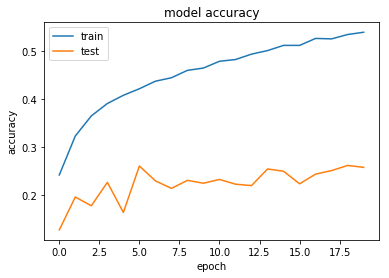

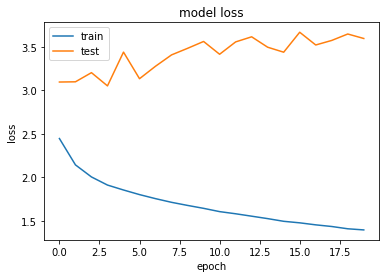

In [31]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
score = model.evaluate(test_data, test_target)

  32/4974 [..............................] - ETA: 2s

 160/4974 [..............................] - ETA: 2s

 352/4974 [=>............................] - ETA: 1s

 512/4974 [==>...........................] - ETA: 1s

 672/4974 [===>..........................] - ETA: 1s

 800/4974 [===>..........................] - ETA: 1s

 896/4974 [====>.........................] - ETA: 1s

 992/4974 [====>.........................] - ETA: 1s

1088/4974 [=====>........................] - ETA: 1s

1216/4974 [======>.......................] - ETA: 1s

1312/4974 [======>.......................] - ETA: 1s

1408/4974 [=======>......................] - ETA: 1s

1504/4974 [========>.....................] - ETA: 1s

1600/4974 [========>.....................] - ETA: 1s

1728/4974 [=========>....................] - ETA: 1s

1888/4974 [==========>...................] - ETA: 1s

2016/4974 [===========>..................] - ETA: 1s

2112/4974 [===========>..................] - ETA: 1s

2240/4974 [============>.................] - ETA: 1s

2368/4974 [=============>................] - ETA: 1s

2496/4974 [==============>...............] - ETA: 1s

2624/4974 [==============>...............] - ETA: 1s

2752/4974 [===============>..............] - ETA: 1s

2880/4974 [================>.............] - ETA: 0s

3008/4974 [=================>............] - ETA: 0s

3136/4974 [=================>............] - ETA: 0s

3296/4974 [==================>...........] - ETA: 0s

3424/4974 [===================>..........] - ETA: 0s

3584/4974 [====================>.........] - ETA: 0s

3744/4974 [=====================>........] - ETA: 0s

3904/4974 [======================>.......] - ETA: 0s

4064/4974 [=======================>......] - ETA: 0s

4224/4974 [========================>.....] - ETA: 0s

4384/4974 [=========================>....] - ETA: 0s

4576/4974 [==========================>...] - ETA: 0s

4704/4974 [===========================>..] - ETA: 0s

4864/4974 [============================>.] - ETA: 0s

[3.2948923146911642, 0.22175311622822866]


In [37]:
test_y = model.predict(test_data)
test_y = np.argmax(test_y, axis=1)
test_t = np.argmax(test_target, axis=1)
print(test_t.shape, test_y.shape)
acc = evaluate_vec(test_y, test_t).tolist()

print(format(acc.count(1) / len(acc), '.6f'), format(np.mean(acc), '.6f'))

(4974,) (4974,)
0.221753 0.295517


In [38]:
test_y

array([11, 15, 11, ..., 10, 10, 10])